# Setup

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
base_dir = 'LM_Query_Complexity/'  # TODO: path to `LM_Query_Complexity` on your file system
os.chdir(base_dir)

In [3]:
import collections
import datasets
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import torch
import time
# import ctranslate2
from transformers import AutoTokenizer

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device:', device)

device: cuda


## Code Llama

In [4]:
from transformers import LlamaForCausalLM, AutoTokenizer

In [5]:
model = LlamaForCausalLM.from_pretrained("codellama/CodeLlama-7b-hf").to(device)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [10]:
tokenizer = AutoTokenizer.from_pretrained("codellama/CodeLlama-7b-hf")

# Train error predictor

## Extract rep at error positions

In [7]:
import pickle
import torch
from transformers import AutoTokenizer, LlamaModel, GPT2Model
from tqdm import tqdm

# format of the generated results (a Python dict)
# prompt:
# - generaion_config1: generations1.1, generations1.2, generations1.3
# - generaion_config2: ....
with open('data/prompts_and_generations_task10_repeat10_merged.pkl', 'rb') as f:
    prompts_and_generations = pickle.load(f)

In [8]:
prompt = list(prompts_and_generations.keys())[0]
print(prompt)

def f(a, b):
    return a + b

List 8 test cases of the above function f, one in each line:
assert f(5, 5) == 10
assert f(1, 5) == 6
assert f(2, 8) == 10
assert f(6, 2) == 8
assert f(6, 9) == 15
assert f(4, 5) == 9
assert f(9, 6) == 15
assert f(6, 1) == 7

def knk(l, item):
    assert type(l) is list
    l.append(item)
    return l


List 8 test cases of the above function knk, one in each line:


In [9]:
function_name = prompt.split('above function ')[-1].replace(', one in each line:', '')
function_name

'knk'

In [10]:
num_demonstrations = 1
num_test_cases_per_function = int(prompt.split('\n')[-1].split(' test cases')[0].replace('List ', ''))
num_test_cases_per_function

8

In [ ]:
from src.code_lm_benchmark import (
    GenerateTestCaseTask,
    GenerateTestCaseTaskBenchmark,
    GenerateTestCaseTaskBenchmarkParallel,
    ErrorType,
)

task = GenerateTestCaseTask(
        num_demonstrations,
        num_test_cases_per_function,
        function_name_length=len(function_name),
        function_name=function_name,
    )

In [12]:
list(prompts_and_generations[prompt])

['top_p0.8',
 'argmax',
 'temperature0.2',
 'beam8_length_penalty-0.5',
 'beam8_length_penalty0',
 'beam8_length_penalty0.5']

In [13]:
generaion_config = list(prompts_and_generations[prompt])[0]
generaion_config

'top_p0.8'

In [14]:
len(prompts_and_generations[prompt][generaion_config])

10

In [15]:
print(prompts_and_generations[prompt][generaion_config][0])


assert knk([1, 2, 3], 4) == [1, 2, 3, 4]
assert knk([5, 6, 7], 8) == [5, 6, 7, 8]
assert knk([9, 10, 11], 12) == [9, 10, 11, 12]
assert knk([13, 14, 15], 16) == [13, 14, 1


In [16]:
token_ids = tokenizer(prompts_and_generations[prompt][generaion_config][0])['input_ids']
len(token_ids)

126

In [17]:
token_ids = tokenizer(prompts_and_generations[prompt][generaion_config][0])['input_ids']
error_token_pos, error_type = task.get_first_error_token(token_ids[1:], tokenizer, verbose=1)
print('error_token_pos', error_token_pos)
print('error_type', error_type)

Error Line:
assert knk([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error_token_pos 125
error_type ErrorType.EXPECTED_OUTPUT_NO_CLOSING_BRACKET


In [18]:
# TODO: these hidden representations need to be extracted.
# see the section "# extract hidden rep" in "src/train_err_pred.py" for details.
# This can be automatically done when training verifiers using "jobs/train_err_pred.sh" or "jobs/train_err_pred_array.sh".
# The file path may need to be updated.
with open('notebooks/data/0321_hiddens_codellama_testgen.pkl', 'rb') as f:
    hiddens = pickle.load(f)

In [19]:
type(hiddens)

dict

In [20]:
list(hiddens.keys())[0]

'def f(a, b):\n    return a + b\n\nList 8 test cases of the above function f, one in each line:\nassert f(5, 5) == 10\nassert f(1, 5) == 6\nassert f(2, 8) == 10\nassert f(6, 2) == 8\nassert f(6, 9) == 15\nassert f(4, 5) == 9\nassert f(9, 6) == 15\nassert f(6, 1) == 7\n\ndef knk(l, item):\n    assert type(l) is list\n    l.append(item)\n    return l\n\n\nList 8 test cases of the above function knk, one in each line:'

In [21]:
print(prompt + prompts_and_generations[prompt][generaion_config][0])

def f(a, b):
    return a + b

List 8 test cases of the above function f, one in each line:
assert f(5, 5) == 10
assert f(1, 5) == 6
assert f(2, 8) == 10
assert f(6, 2) == 8
assert f(6, 9) == 15
assert f(4, 5) == 9
assert f(9, 6) == 15
assert f(6, 1) == 7

def knk(l, item):
    assert type(l) is list
    l.append(item)
    return l


List 8 test cases of the above function knk, one in each line:
assert knk([1, 2, 3], 4) == [1, 2, 3, 4]
assert knk([5, 6, 7], 8) == [5, 6, 7, 8]
assert knk([9, 10, 11], 12) == [9, 10, 11, 12]
assert knk([13, 14, 15], 16) == [13, 14, 1


In [22]:
token_ids = tokenizer(prompt + prompts_and_generations[prompt][generaion_config][0], return_tensors="pt")['input_ids']
len(token_ids[0])

307

In [23]:
token_ids.shape

torch.Size([1, 307])

In [24]:
token_ids = tokenizer(prompt + prompts_and_generations[prompt][generaion_config][0])['input_ids']
len(token_ids)

307

In [25]:
hiddens[prompt][generaion_config][0].shape

torch.Size([1, 307, 4096])

In [99]:
errors_hiddens = {
        prompt: {
            generation_config_name: []
            for generation_config_name in ['top_p0.8','argmax','temperature0.2','beam8_length_penalty-0.5','beam8_length_penalty0','beam8_length_penalty0.5']
        }
        for prompt in prompts_and_generations
    }

In [100]:
correct_hiddens = {
        prompt: {
            generation_config_name: []
            for generation_config_name in ['top_p0.8','argmax','temperature0.2','beam8_length_penalty-0.5','beam8_length_penalty0','beam8_length_penalty0.5']
        }
        for prompt in prompts_and_generations
    }

In [101]:
errors_hiddens_path = 'notebooks/data/errors_hiddens4.pkl'
correct_hiddens_path = 'notebooks/data/correct_hiddens4.pkl'

if os.path.exists(errors_hiddens_path) and os.path.exists(correct_hiddens_path):
    print('loading reps')
    with open(errors_hiddens_path, 'rb') as f:
        errors_hiddens = pickle.load(f)
    with open(correct_hiddens_path, 'rb') as f:
        correct_hiddens = pickle.load(f)
    print('loaded reps')

else:
    from src.code_lm_benchmark import (
        GenerateTestCaseTask,
        GenerateTestCaseTaskBenchmark,
        GenerateTestCaseTaskBenchmarkParallel,
        ErrorType,
    )

    error_parsing_corner_cases = []
    num_reps_extracted = 0
    num_generations = 0

    for prompt in prompts_and_generations:
        function_name = prompt.split('above function ')[-1].replace(', one in each line:', '')
        assert len(function_name) == 3
        num_demonstrations = 1
        num_test_cases_per_function = int(prompt.split('\n')[-1].split(' test cases')[0].replace('List ', ''))
        assert num_test_cases_per_function == 8
        task = GenerateTestCaseTask(
            num_demonstrations,
            num_test_cases_per_function,
            function_name_length=len(function_name),
            function_name=function_name,
        )

        for generation_config_name in prompts_and_generations[prompt]:
            for i, generation in enumerate(prompts_and_generations[prompt][generation_config_name]):
                # print(prompt + generation)
                num_generations += 1
                token_ids_prompt = tokenizer(prompt)['input_ids']
                token_ids_prompt_and_generation = tokenizer(prompt + generation)['input_ids']
                assert token_ids_prompt_and_generation[-1] != tokenizer.eos_token_id  # may need to be updated if generate eos = True
                # token_ids_prompt_and_generation.append(tokenizer.eos_token_id)  # may need to be updated if generate eos = True
                token_ids_generation = token_ids_prompt_and_generation[len(token_ids_prompt):]

                hidden_rep = hiddens[prompt][generation_config_name][i]
                assert hidden_rep.shape[0] == 1
                assert len(token_ids_prompt_and_generation) == hidden_rep.shape[1]
                assert hidden_rep.shape[2] == 4096

                try:
                    first_error_result = task.get_first_error_token(token_ids_generation, tokenizer, verbose=1)
                except:
                    error_parsing_corner_cases.append(
                        (prompt, generation_config_name, i)
                    )
                    continue

                if first_error_result is not None:
                    error_token_pos_generation, error_type = first_error_result
                    print('error_type', error_type)
                    if error_type != ErrorType.EXTRA_CONTENT_AFTER_TASK_COMPLETION:
                        print('generation', generation)
                        error_token_pos_all = error_token_pos_generation + len(token_ids_prompt)
                        if error_token_pos_generation == len(token_ids_generation):  # may need to be updated if generate eos = True
                            error_token_pos_all -= 1
                            print('error: premature ending')
                        else:
                            print('error token', tokenizer.decode(token_ids_prompt_and_generation[error_token_pos_all]))
                        
                        errors_hiddens[prompt][generation_config_name].append(hidden_rep[0][error_token_pos_all])
                        num_reps_extracted += 1
                        for correct_pos in range(len(token_ids_prompt), error_token_pos_all):
                            correct_hiddens[prompt][generation_config_name].append(hidden_rep[0][correct_pos])
                            num_reps_extracted += 1
                else:
                    for correct_pos in range(len(token_ids_prompt), len(token_ids_prompt_and_generation)):
                        correct_hiddens[prompt][generation_config_name].append(hidden_rep[0][correct_pos])
                        num_reps_extracted += 1
                print('\n\n')

    with open(errors_hiddens_path, 'wb') as f:
        pickle.dump(errors_hiddens, f)

    with open(correct_hiddens_path, 'wb') as f:
        pickle.dump(correct_hiddens, f)

    print('num_generations', num_generations)
    print('num_reps_extracted', num_reps_extracted)
    

Error Line:
assert knk([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error_type ErrorType.EXPECTED_OUTPUT_NO_CLOSING_BRACKET
generation 
assert knk([1, 2, 3], 4) == [1, 2, 3, 4]
assert knk([5, 6, 7], 8) == [5, 6, 7, 8]
assert knk([9, 10, 11], 12) == [9, 10, 11, 12]
assert knk([13, 14, 15], 16) == [13, 14, 1
error: premature ending



Error Line:
def rev(s):
Error Token: 'def'
error_type ErrorType.EXTRA_CONTENT_AFTER_TASK_COMPLETION



Error Line:
assert knk([[1, 2]], 3) == [[1, 2], 3]
Error Token: 'assert'
error_type ErrorType.EXTRA_CONTENT_AFTER_TASK_COMPLETION



Error Line:
assert knk([1, 5, 2], 4) == [4, 1, 5, 2]
Error Token: '4'
error_type ErrorType.ASSERTION_FAILURE
generation 
assert knk([], 1) == [1]
assert knk([1], 2) == [1, 2]
assert knk([1, 2], 3) == [1, 2, 3]
assert knk([1, 3, 2], 4) == [1, 3, 2, 4]
assert knk([1, 5, 2], 4) == [4, 1, 5, 2]
assert knk([4, 1, 5, 3], 2) == [4, 1, 2, 5, 3]
assert knk([4, 2, 5, 3], 1) == [1, 4, 2, 5, 
error t

In [102]:
len(error_parsing_corner_cases)

0

In [103]:
errors_hiddens_reps = []
for prompt in errors_hiddens:
    for generation_config_name in ['top_p0.8','argmax','temperature0.2','beam8_length_penalty-0.5','beam8_length_penalty0','beam8_length_penalty0.5']:
        for rep in errors_hiddens[prompt][generation_config_name]:
            errors_hiddens_reps.append(rep.tolist())
len(errors_hiddens_reps)

294

In [104]:
correct_hiddens_reps = []
for prompt in correct_hiddens:
    for generation_config_name in ['top_p0.8','argmax','temperature0.2','beam8_length_penalty-0.5','beam8_length_penalty0','beam8_length_penalty0.5']:
        for rep in correct_hiddens[prompt][generation_config_name]:
            correct_hiddens_reps.append(rep.tolist())
len(correct_hiddens_reps)

30049

In [107]:
import random

correct_hiddens_reps_sampled = random.sample(correct_hiddens_reps, 300)
len(correct_hiddens_reps_sampled), len(correct_hiddens_reps_sampled[0])

(300, 4096)

In [108]:
from sklearn.manifold import TSNE
import numpy as np

all_intermediates = np.array(errors_hiddens_reps + correct_hiddens_reps_sampled)
X_embedded = TSNE(perplexity=30.0, random_state=0).fit_transform(all_intermediates)
print('X_embedded.shape', len(X_embedded), len(X_embedded[0]))

X_embedded.shape 594 2


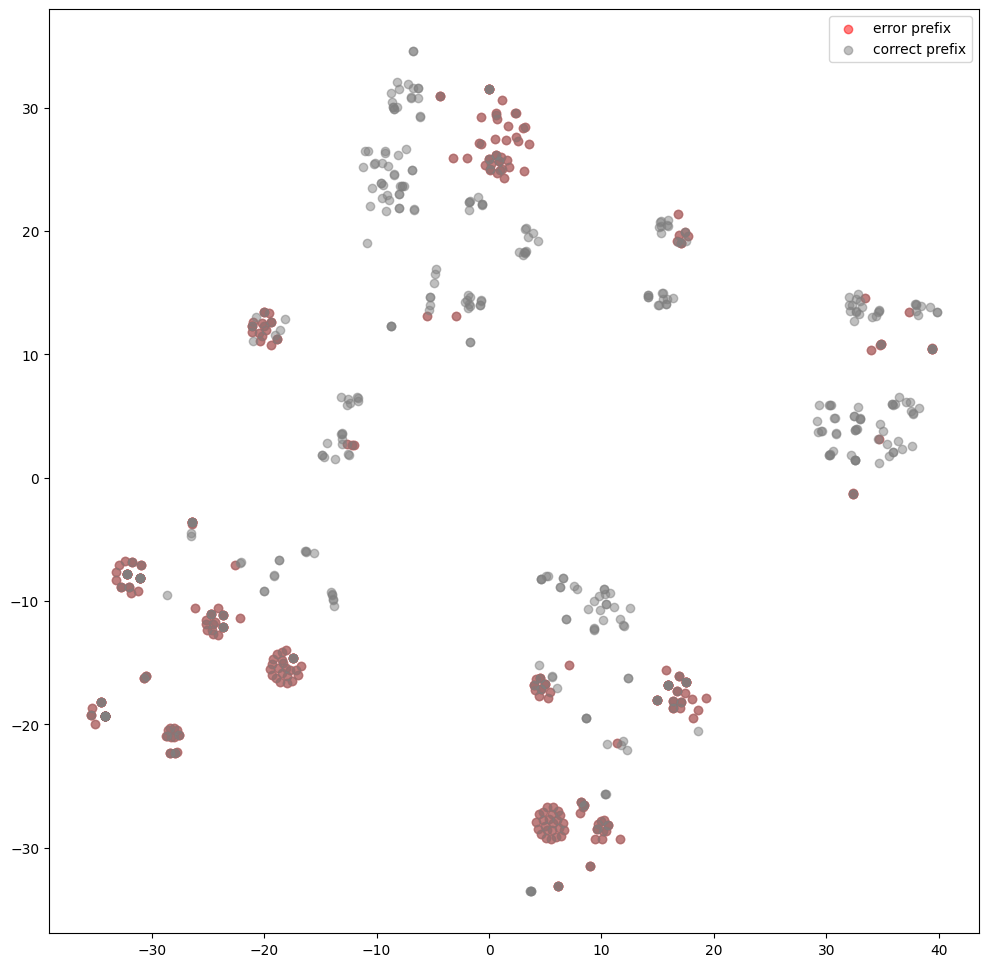

In [109]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))
plt.scatter(
    x=X_embedded[:len(errors_hiddens_reps), 0],
    y=X_embedded[:len(errors_hiddens_reps), 1],
    color='red',
    alpha=0.5,
    label='error prefix',
)
plt.scatter(
    x=X_embedded[-len(correct_hiddens_reps):, 0],
    y=X_embedded[-len(correct_hiddens_reps):, 1],
    color='grey',
    alpha=0.5,
    label='correct prefix',
)
plt.legend()
plt.show()

## Train error predictor

In [110]:
pn_ratio = len(correct_hiddens_reps) // len(errors_hiddens_reps)
pn_ratio

102

In [111]:
errors_hiddens_reps *= pn_ratio
len(errors_hiddens_reps)

29988

In [112]:
train_proportion = 0.9
train_idx_ends_positive = int(len(errors_hiddens_reps) * train_proportion)
train_idx_ends_ood_negative = int(len(correct_hiddens_reps) * train_proportion)

In [113]:
train_data = [
    [1] + rep
    for rep in errors_hiddens_reps[:train_idx_ends_positive]
] + [
    [0] + rep
    for rep in correct_hiddens_reps[:train_idx_ends_ood_negative]
]

test_data = [
    [1] + rep
    for rep in errors_hiddens_reps[train_idx_ends_positive:]
] + [
    [0] + rep
    for rep in correct_hiddens_reps[train_idx_ends_ood_negative:]
]

len(train_data), len(test_data)

(54033, 6004)

In [114]:
train_data = torch.tensor(train_data)
test_data = torch.tensor(test_data)

print(train_data.shape, test_data.shape)

torch.Size([54033, 4097]) torch.Size([6004, 4097])


In [121]:
# label proportion
sum(test_data[:, 0]) / len(test_data[:, 0])

tensor(0.4995)

In [115]:
from torch.utils.data import Dataset, DataLoader

class TrainDataset(Dataset):
    def __init__(self, data):
        self.data = data
    def __len__(self):
        return len(self.data)
    def __getitem__(self, ind):
        x = self.data[ind][1:]
        y = self.data[ind][0]
        return x, y

# class TestDataset(TrainDataset):
#     def __getitem__(self, ind):
#         x = self.data[ind]
#         return x

train_set = TrainDataset(train_data)
test_set  = TrainDataset(test_data)

batch_size = 2048
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_set,  batch_size=batch_size, shuffle=False)

In [116]:
import torch
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.linear = nn.Linear(4096, 2)
    def forward(self, x):
        out = self.linear(x)
        return out

model_err_pred = MLP().to(device)

criterion = nn.CrossEntropyLoss()

In [117]:
def test(model_err_pred, test_loader, criterion, device):
    model_err_pred.eval()
    all_ys = torch.tensor([]).to(device)
    all_preds = torch.tensor([]).to(device)

    losses = []
    with torch.no_grad():
        for batch_num, input_data in enumerate(test_loader):
            x, y = input_data
            x = x.to(device).float()
            y = y.type(torch.LongTensor).to(device)

            output = model_err_pred(x)
            loss = criterion(output, y)
            losses.append(loss.item())

            pred = output.argmax(dim=-1)

            all_ys = torch.concat([all_ys, y.detach()])
            all_preds = torch.concat([all_preds, pred.detach()])

    test_acc = sum(all_preds == all_ys) / len(all_ys)
    print('Test Loss %6.2f | test acc %.2f' % (sum(losses)/len(losses), test_acc))
    return test_acc

In [119]:
import pickle
import copy

cur_best_model_err_pred_save_path = 'notebooks/data/model_err_pred4.pkl'
cur_best_test_acc = 0.0

if os.path.exists(cur_best_model_err_pred_save_path):
    with open(cur_best_model_err_pred_save_path, 'rb') as f:
        model_err_pred = pickle.load(f)
else:
    model_err_pred = MLP().to(device)
    
    # training loop
    optimizer = torch.optim.AdamW(
        model_err_pred.parameters(),
        lr=0.003,
        weight_decay=0.1,
    )
    epochs = 10

    for epoch in range(epochs):
        losses = []
        for batch_num, input_data in enumerate(train_loader):
            optimizer.zero_grad()
            x, y = input_data
            x = x.to(device).float()
            y = y.type(torch.LongTensor).to(device)

            output = model_err_pred(x)
            loss = criterion(output, y)
            loss.backward()
            losses.append(loss.item())

            optimizer.step()

            if batch_num % 10 == 0:
                pred = output.argmax(dim=-1)
                print('\tEpoch %d | Batch %d | Loss %6.2f | train acc %.2f' % (epoch, batch_num, loss.item(), sum(pred == y) / len(y)))
            # break

        pred = output.argmax(dim=-1)
        print('Epoch %d | Loss %6.2f | train acc %.2f' % (epoch, sum(losses)/len(losses), sum(pred == y) / len(y)))
        test_acc = test(model_err_pred, test_loader, criterion, device)
        if test_acc >= cur_best_test_acc:
            with open(cur_best_model_err_pred_save_path, 'wb') as f:
                pickle.dump(model_err_pred, f)
            cur_best_test_acc = test_acc
        
        model_err_pred.train()

    print('final best_model_err_pred:')
    with open(cur_best_model_err_pred_save_path, 'rb') as f:
        cur_best_model_err_pred = pickle.load(f)
    test(cur_best_model_err_pred, test_loader, criterion, device)
    

	Epoch 0 | Batch 0 | Loss   0.72 | train acc 0.49
	Epoch 0 | Batch 10 | Loss   0.33 | train acc 0.90
	Epoch 0 | Batch 20 | Loss   0.18 | train acc 0.94
Epoch 0 | Loss   0.33 | train acc 0.95
Test Loss   0.09 | test acc 0.95
	Epoch 1 | Batch 0 | Loss   0.10 | train acc 0.95
	Epoch 1 | Batch 10 | Loss   0.08 | train acc 0.96
	Epoch 1 | Batch 20 | Loss   0.07 | train acc 0.98
Epoch 1 | Loss   0.09 | train acc 0.98
Test Loss   0.05 | test acc 0.98
	Epoch 2 | Batch 0 | Loss   0.07 | train acc 0.98
	Epoch 2 | Batch 10 | Loss   0.06 | train acc 0.98
	Epoch 2 | Batch 20 | Loss   0.06 | train acc 0.98
Epoch 2 | Loss   0.05 | train acc 0.99
Test Loss   0.04 | test acc 0.99
	Epoch 3 | Batch 0 | Loss   0.05 | train acc 0.98
	Epoch 3 | Batch 10 | Loss   0.05 | train acc 0.98
	Epoch 3 | Batch 20 | Loss   0.04 | train acc 0.98
Epoch 3 | Loss   0.05 | train acc 0.99
Test Loss   0.04 | test acc 0.99
	Epoch 4 | Batch 0 | Loss   0.05 | train acc 0.99
	Epoch 4 | Batch 10 | Loss   0.04 | train acc 0.99
	Ep

In [122]:
model_err_pred == cur_best_model_err_pred

False

In [123]:
model_err_pred = cur_best_model_err_pred

# Experiment: Redo incorrect continuations using argmax

In [41]:
generation_config_names = [
            'top_p0.8',
            'argmax',
            'temperature0.2',
            'beam8_length_penalty-2',
            'beam8_length_penalty-0.5',
            'beam8_length_penalty0.5',
            'beam8_length_penalty0',
            'beam8_length_penalty-10',
            'beam8_length_penalty10',
        ]
args = [
    {'top_p': 0.8},
    {'top_k': 1},
    {'temperature': 0.2},
    {'num_beams': 8},
    {'num_beams': 8, 'length_penalty': -0.5},
    {'num_beams': 8, 'length_penalty': 0.5},
    {'num_beams': 8, 'length_penalty': 0.0},
    {'num_beams': 8, 'length_penalty': -10.0},
    {'num_beams': 8, 'length_penalty': 10.0},
]
config2arg = dict(zip(
    generation_config_names,
    args,
))
config2arg

{'top_p0.8': {'top_p': 0.8},
 'argmax': {'top_k': 1},
 'temperature0.2': {'temperature': 0.2},
 'beam8_length_penalty-2': {'num_beams': 8},
 'beam8_length_penalty-0.5': {'num_beams': 8, 'length_penalty': -0.5},
 'beam8_length_penalty0.5': {'num_beams': 8, 'length_penalty': 0.5},
 'beam8_length_penalty0': {'num_beams': 8, 'length_penalty': 0.0},
 'beam8_length_penalty-10': {'num_beams': 8, 'length_penalty': -10.0},
 'beam8_length_penalty10': {'num_beams': 8, 'length_penalty': 10.0}}

## no backtrack, just argmax from error position all the way till end

In [42]:
model.device

device(type='cuda', index=0)

In [119]:
from src.code_lm_benchmark import (
    GenerateTestCaseTask,
    GenerateTestCaseTaskBenchmark,
    GenerateTestCaseTaskBenchmarkParallel,
    ErrorType,
)

error_parsing_corner_cases = []
num_errors = 0
num_correct_redo = 0

for prompt in reversed(prompts_and_generations):
    function_name = prompt.split('above function ')[-1].replace(', one in each line:', '')
    assert len(function_name) == 3
    num_demonstrations = 1
    num_test_cases_per_function = int(prompt.split('\n')[-1].split(' test cases')[0].replace('List ', ''))
    assert num_test_cases_per_function == 8
    task = GenerateTestCaseTask(
        num_demonstrations,
        num_test_cases_per_function,
        function_name_length=len(function_name),
        function_name=function_name,
    )

    for generation_config_name in prompts_and_generations[prompt]:
        for i, generation in enumerate(prompts_and_generations[prompt][generation_config_name]):
            # print(prompt + generation)
            token_ids_prompt = tokenizer(prompt)['input_ids']
            token_ids_prompt_and_generation = tokenizer(prompt + generation)['input_ids']
            token_ids_generation = token_ids_prompt_and_generation[len(token_ids_prompt):]

            # error_token_pos_generation = task.get_first_error_token(token_ids_generation, tokenizer, verbose=1)
            try:
                error_token_pos_generation, err_type = task.get_first_error_token(token_ids_generation, tokenizer, verbose=1)
            except:
                error_parsing_corner_cases.append(
                    (prompt, generation)
                )
                print(f'corner case old: {generation}')
                continue
            if error_token_pos_generation is None or err_type == ErrorType.EXTRA_CONTENT_AFTER_TASK_COMPLETION:
                print('correct old')
            else:
                if error_token_pos_generation == len(token_ids_generation):
                    print('error token old at end')
                else:
                    print('error token old:', tokenizer.decode(token_ids_generation[error_token_pos_generation]))
                num_errors += 1
                prompt_and_partial_generation_ids = token_ids_prompt + token_ids_generation[:error_token_pos_generation]
                # args = config2arg[generation_config_name]
                result = model.generate(
                    torch.tensor(
                        [prompt_and_partial_generation_ids],
                        device=device,
                    ),
                    max_tokens=None,
                    max_new_tokens=256,
                    top_k=1,  # argmax
                    do_sample=False,  # argmax
                    # **args,
                ).detach().tolist()[0]
                assert result[0] == tokenizer.bos_token_id
                assert result[:len(prompt_and_partial_generation_ids)] == prompt_and_partial_generation_ids
                new_token_ids_generation = result[len(token_ids_prompt):]
                try:
                    new_error_token_pos_generation, err_type = task.get_first_error_token(new_token_ids_generation, tokenizer, verbose=1)
                except:
                    error_parsing_corner_cases.append(
                        (prompt, result)
                    )
                    print(f'corner case new: {result}')
                    continue
                if new_error_token_pos_generation is None or err_type == ErrorType.EXTRA_CONTENT_AFTER_TASK_COMPLETION:
                    num_correct_redo += 1
                    print('correct new')
                else:
                    if new_error_token_pos_generation == len(new_token_ids_generation):
                        print('error token new at end')
                    else:
                        print('error token new:', tokenizer.decode(new_token_ids_generation[new_error_token_pos_generation]))


print('num_errors', num_errors)
print('num_correct_redo', num_correct_redo)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert ovs([], 1) = [1]
Error Token: '='
error token old: =


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def ovs2(l, item):
Error Token: 'def'
correct new
Error Line:
assert ovs([1, 2.3, 4+6j], 5) == [1, 3.3, 4+6j, 5]
Error Token: '3'
error token old: 3


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f(a, b):
Error Token: 'def'
correct new
Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 16]
Error Token: '6'
error token old: 6


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def ovs2(l, item):
Error Token: 'def'
correct new
Error Line:
assert ovs([1, 2], 3) == [1, 2, 4]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def ovs2(l, item):
Error Token: 'def'
correct new
Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 14, 15, 16]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def ovs2(l, item):
Error Token: 'def'
correct new
Error Line:
assert ovs([], 3) != [3,4]
Error Token: '!='
error token old: !=


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def ovs2(l, item):
Error Token: 'def'
correct new
Error Line:
def insertion_sort(arr):
Error Token: 'def'
correct old
Error Line:
def reverselist(l):
Error Token: 'def'
correct old
Error Line:
assert ovs([1, 2, 3], 4) == [
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def ovs2(l, item):
Error Token: 'def'
correct new
Error Line:
def nontriv(n):
Error Token: 'def'
correct old
Error Line:
def is_even(n):
Error Token: 'def'
correct old
Error Line:
def g(a):
Error Token: 'def'
correct old
Error Line:
assert ovs([1, 10, 100], 101) == [1, 10, 10, 101]
Error Token: ','
error token old: ,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def is_even(n):
Error Token: 'def'
correct new
Error Line:
assert ovs([1, 2], 3) == [1, 2, 4]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def ovs2(l, item):
Error Token: 'def'
correct new
Error Line:
def is_sorted(l):
Error Token: 'def'
correct old
Error Line:
assert ov([1, 3, 5], [7, 9]) == [1, 3, 5,[7, 9]]
Error Token: 'ov'
error token old: ov


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert ovs([1, 3, 5], 7) == [1, 3, 5, 7]
Error Token: 'assert'
correct new
Error Line:
def g(a, b):
Error Token: 'def'
correct old
Error Line:
assert ovs([1, 3, 5], 2) == [1, 2, 2, 3, 4, 5]
Error Token: '2'
error token old: 2


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def ovs2(l, item):
Error Token: 'def'
correct new
Error Line:
assert ovs([1, 2], 3) == [1, 2, 4]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def ovs2(l, item):
Error Token: 'def'
correct new
Error Line:
assert ovs([1, 3, 5], 2) == [1, 2, 2, 3, 4, 5]
Error Token: '2'
error token old: 2


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def ovs2(l, item):
Error Token: 'def'
correct new
Error Line:
assert ovs([1, 10, 100], 101) == [1, 10, 101]
Error Token: '1'
error token old: 1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def is_even(n):
Error Token: 'def'
correct new
Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def ovs2(l, item):
Error Token: 'def'
correct new
Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def ovs2(l, item):
Error Token: 'def'
correct new
Error Line:
assert ovs([1, 2, 3], 4) == [1, 2, 3, 4]
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def ovs2(l, item):
Error Token: 'def'
correct new
Error Line:
assert ovs([1, 2, 3], 4) == [1, 2, 3, 4]
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def ovs2(l, item):
Error Token: 'def'
correct new
Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def ovs2(l, item):
Error Token: 'def'
correct new
Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def ovs2(l, item):
Error Token: 'def'
correct new
Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def ovs2(l, item):
Error Token: 'def'
correct new
Error Line:

Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def ovs2(l, item):
Error Token: 'def'
correct new
Error Line:

Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def ovs2(l, item):
Error Token: 'def'
correct new
Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def ovs2(l, item):
Error Token: 'def'
correct new
Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def ovs2(l, item):
Error Token: 'def'
correct new
Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def ovs2(l, item):
Error Token: 'def'
correct new
Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def ovs2(l, item):
Error Token: 'def'
correct new
Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def ovs2(l, item):
Error Token: 'def'
correct new
Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def ovs2(l, item):
Error Token: 'def'
correct new
Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def ovs2(l, item):
Error Token: 'def'
correct new
Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def ovs2(l, item):
Error Token: 'def'
correct new
Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def ovs2(l, item):
Error Token: 'def'
correct new
Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def ovs2(l, item):
Error Token: 'def'
correct new
Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def ovs2(l, item):
Error Token: 'def'
correct new
Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def ovs2(l, item):
Error Token: 'def'
correct new
Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def ovs2(l, item):
Error Token: 'def'
correct new
Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def ovs2(l, item):
Error Token: 'def'
correct new
Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def ovs2(l, item):
Error Token: 'def'
correct new
Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def ovs2(l, item):
Error Token: 'def'
correct new
Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def ovs2(l, item):
Error Token: 'def'
correct new
Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def ovs2(l, item):
Error Token: 'def'
correct new
Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def ovs2(l, item):
Error Token: 'def'
correct new
Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def ovs2(l, item):
Error Token: 'def'
correct new
Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 14, 16]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def ovs2(l, item):
Error Token: 'def'
correct new
Error Line:
assert mcl([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcl2(l, item):
Error Token: 'def'
correct new
Error Line:
assert mcl([1, 2], 4) == [1, 4, 2]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcl2(l, item):
Error Token: 'def'
correct new
Error Line:
def rmv(l, item):
Error Token: 'def'
correct old
Error Line:
assert mcl([1, 2, 3], 4) == [1, 2, 4]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcl2(l, item):
Error Token: 'def'
correct new
Error Line:
assert not mcl([1], 2) == [1, 2]
Error Token: 'not'
error token old: not


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcr(l, item):
Error Token: 'def'
correct new
No Errors
corner case old: 
assert mcl([], 1) == [1]
assert mcl([2, 3], 4) == [2, 3, 4]
assert mcl([5, 6], 7) == [5, 6, 7]
assert mcl([8, 9], 10) == [8, 9, 10]
assert mcl([11, 12], 13) == [11, 12, 13]
assert mcl([14, 15], 16) == [14, 15, 16]
assert mcl([17, 18], 19) == [17, 18, 19]
assert mcl([20, 21], 22) == [20, 21, 22]
Error Line:
def alist(al):
Error Token: 'def'
correct old
No Errors
corner case old: 
assert mcl([], 1) == [1]
assert mcl([2, 3, 4], 5) == [2, 3, 4, 5]
assert mcl([1, 2], 3) == [1, 2, 3]
assert mcl([1, 1, 1], 2) == [1, 1, 1, 2]
assert mcl([], "hi") == ["hi"]
assert mcl(["hello"], "world") == ["hello", "world"]
assert mcl([1, 2, 3], "bye") == [1, 2, 3, "bye"]
assert mcl([1, 1], 2) ==  [1, 1, 2]

No Errors
corner case old: 
assert mcl([1, 2], 3) == [1, 2, 3]
assert mcl([], 1) == [1]
assert mcl([4, 5], 6) == [4, 5, 6]
assert mcl([2, 1], 0) == [2, 1, 0]
assert mcl([], 10) == [10]
assert mcl([], 9) == [9]
assert 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcr(l, item):
Error Token: 'def'
correct new
Error Line:
assert mcl([1, 2], 3) == [1, 2, 4]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcl2(l, item):
Error Token: 'def'
correct new
Error Line:
def is_sorted(l):
Error Token: 'def'
correct old
Error Line:
def mcd(l):
Error Token: 'def'
correct old
Error Line:
def mcd(d, key, value):
Error Token: 'def'
correct old
Error Line:
assert mcl([1, 2], 3) == [1, 2, 4]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcl2(l, item):
Error Token: 'def'
correct new
Error Line:
assert mcl([1, 2], 3) == [1, 2, 4]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcl2(l, item):
Error Token: 'def'
correct new
Error Line:
assert mcl([1, 2], 3) == [1, 2, 4]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcl2(l, item):
Error Token: 'def'
correct new
Error Line:
def mcr(l, item):
Error Token: 'def'
correct old
Error Line:
assert mcl([1.1, 2.2], 3.3) == [1.1, 2.2, 3.3]
Error Token: 'assert'
correct old
Error Line:
assert mcl([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcl2(l, item):
Error Token: 'def'
correct new
Error Line:
assert mcl([1, 2], 3) == [1, 2, 4]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcl2(l, item):
Error Token: 'def'
correct new
Error Line:
assert mcl([1, 2], 4) == [1, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcl2(l, item):
Error Token: 'def'
correct new
Error Line:
assert mcl([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcl2(l, item):
Error Token: 'def'
correct new
Error Line:
assert mcl([1, 2], 4) == [1, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcl2(l, item):
Error Token: 'def'
correct new
Error Line:
assert mcl([1, 2, 3], 4) == [1, 2, 3, 4]
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcl2(l, item):
Error Token: 'def'
correct new
Error Line:
assert mcl([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcl2(l, item):
Error Token: 'def'
correct new
Error Line:
assert mcl([1, 2], 4) == [1, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcl2(l, item):
Error Token: 'def'
correct new
Error Line:
assert mcl([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert mcl([1, 2, 3, 4,
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert mcl([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcl2(l, item):
Error Token: 'def'
correct new
Error Line:

Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcl2(l, item):
Error Token: 'def'
correct new
Error Line:
assert mcl([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcl2(l, item):
Error Token: 'def'
correct new
Error Line:
assert mcl([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcl2(l, item):
Error Token: 'def'
correct new
Error Line:
assert mcl([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcl2(l, item):
Error Token: 'def'
correct new
Error Line:
assert mcl([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcl2(l, item):
Error Token: 'def'
correct new
Error Line:
assert mcl([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcl2(l, item):
Error Token: 'def'
correct new
No Errors
corner case old: 
assert mcl([], 1) == [1]
assert mcl([], 2) == [2]
assert mcl([], 3) == [3]
assert mcl([], 4) == [4]
assert mcl([], 5) == [5]
assert mcl([], 6) == [6]
assert mcl([], 7) == [7]
assert mcl([], 8) == [8]

Error Line:
assert mcl([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcl2(l, item):
Error Token: 'def'
correct new
Error Line:
assert mcl([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcl2(l, item):
Error Token: 'def'
correct new
Error Line:
assert mcl([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcl2(l, item):
Error Token: 'def'
correct new
Error Line:
assert mcl([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcl2(l, item):
Error Token: 'def'
correct new
Error Line:
assert mcl([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcl2(l, item):
Error Token: 'def'
correct new
Error Line:
assert mcl([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcl2(l, item):
Error Token: 'def'
correct new
No Errors
corner case old: 
assert mcl([], 1) == [1]
assert mcl([], 2) == [2]
assert mcl([], 3) == [3]
assert mcl([], 4) == [4]
assert mcl([], 5) == [5]
assert mcl([], 6) == [6]
assert mcl([], 7) == [7]
assert mcl([], 8) == [8]

Error Line:
assert mcl([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcl2(l, item):
Error Token: 'def'
correct new
Error Line:
assert mcl([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcl2(l, item):
Error Token: 'def'
correct new
No Errors
corner case old: 
assert mcl([], 1) == [1]
assert mcl([], 2) == [2]
assert mcl([], 3) == [3]
assert mcl([], 4) == [4]
assert mcl([], 5) == [5]
assert mcl([], 6) == [6]
assert mcl([], 7) == [7]
assert mcl([], 8) == [8]

Error Line:
assert mcl([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcl2(l, item):
Error Token: 'def'
correct new
Error Line:
assert mcl([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcr(l, item):
Error Token: 'def'
correct new
Error Line:
assert mcl([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcl2(l, item):
Error Token: 'def'
correct new
No Errors
corner case old: 
assert mcl([], 1) == [1]
assert mcl([], 2) == [2]
assert mcl([], 3) == [3]
assert mcl([], 4) == [4]
assert mcl([], 5) == [5]
assert mcl([], 6) == [6]
assert mcl([], 7) == [7]
assert mcl([], 8) == [8]

Error Line:
assert mcl([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcl2(l, item):
Error Token: 'def'
correct new
Error Line:
def sq(n):
Error Token: 'def'
error token old: def


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f(a, b):
Error Token: 'def'
error token new: def
Error Line:
assert zmf([12, 13, 14], 15) == [12, 13, 15, 15]
Error Token: '5'
error token old: 5


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f2(a, b):
Error Token: 'def'
correct new
No Errors
corner case old: 
assert zmf([], 1) == [1]
assert zmf([2, 3], 4) == [2, 3, 4]
assert zmf([5, 6], 7) == [5, 6, 7]
assert zmf([8, 9], 0) == [8, 9, 0]
assert zmf([1, 2], 3) == [1, 2, 3]
assert zmf([4, 5], 6) == [4, 5, 6]
assert zmf([7, 8], 9) == [7, 8, 9]
assert zmf([10, 11], 12) == [10, 11, 12]

Error Line:
def y(s):
Error Token: 'def'
correct old
Error Line:
assert zmf([], 9) != []
Error Token: '!='
error token old: !=


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f2(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f2(a, b):
Error Token: 'def'
correct new
No Errors
corner case old: 
assert zmf([], 0) == [0]
assert zmf([1], 2) == [1, 2]
assert zmf([4,5,6], 7) == [4, 5, 6, 7]
assert zmf([], "a") == ["a"]
assert zmf(["a"], "b") == ["a", "b"]
assert zmf([], {}) == [{}]
assert zmf([], 1.5) == [1.5]
assert zmf([], None) == [None]

Error Line:
assert rmf([7,1,2], 9) == [7, 1, 2, 9]
Error Token: 'rm'
error token old: rm


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f2(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([], ()) == [(])
Error Token: 'assert'
correct old
Error Line:
assert zmf([1, 2, 3], 9) == [1, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f2(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([1, 2], 3) == [1, 2, 4]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([1, 2], 3) == [1, 2, 4]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([1, 2], 3) == [1, 2, 4]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f2(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([1, 2], 3) == [1, 2, 4]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([1, 10, 100], 101) == [1, 10, 10
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([1, 2], 3) == [1, 2, 4]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([1, 2], 3) == [1, 2, 4]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f(a, b):
Error Token: 'def'
correct new
Error Line:
def f(a, b):
Error Token: 'def'
error token old: def


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f(a, b):
Error Token: 'def'
error token new: def
Error Line:
def f(a, b):
Error Token: 'def'
error token old: def


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f(a, b):
Error Token: 'def'
error token new: def
Error Line:
assert zmf([10, 11, 12], 13) == [10, 11, 13]
Error Token: '3'
error token old: 3


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f2(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([1, 2], 4) == [1, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([1, 2], 4) == [1, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([1, 2], 4) == [1, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f(a, b):
Error Token: 'def'
correct new
Error Line:

Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f(a, b):
Error Token: 'def'
correct new
Error Line:

Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f(a, b):
Error Token: 'def'
correct new
Error Line:

Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f2(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f2(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f2(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f2(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f2(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f2(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f2(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f2(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f2(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f2(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f2(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f2(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f2(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f2(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f2(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f2(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f2(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f2(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f2(a, b):
Error Token: 'def'
correct new
Error Line:
assert cyk([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def is_palindrome(s):
Error Token: 'def'
correct new
Error Line:
assert cyk([1, 6, 7, 8], 9) == [1, 6, 7, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def is_palindrome(s):
Error Token: 'def'
correct new
Error Line:
assert cyk([1, 7, 9, 2], 4) == [1, 7, 9, 4]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def cyk_test(l, item):
Error Token: 'def'
correct new
Error Line:
assert cyk([], []) == []
Error Token: '[]'
error token old: []


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([], []) == []
Error Token: '[]'
error token new: []
Error Line:
assert cyk([1, 5, 3, 4], 2) == [1, 5, 3, 2, 4]
Error Token: '2'
error token old: 2


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def cyk_2(l, item):
Error Token: 'def'
correct new
Error Line:
def rotate(L, n):
Error Token: 'def'
correct old
Error Line:
def cyk_min(l):
Error Token: 'def'
correct old
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1, 2, 3, 4,
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert cyk([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def is_palindrome(s):
Error Token: 'def'
correct new
Error Line:
assert cyk([1, 3, 5, 7], 9) == [1, 3, 5, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def cyk_2(l, item):
Error Token: 'def'
correct new
Error Line:
def f(a, b):
Error Token: 'def'
correct old
Error Line:
def is_prime(n):
Error Token: 'def'
correct old
Error Line:
assert cyk([1, 0, 3], 4) == [
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def is_palindrome(s):
Error Token: 'def'
correct new
Error Line:
assert cyk([1,2,3,4,5], 6) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def is_palindrome(s):
Error Token: 'def'
correct new
Error Line:
assert cyk([1, 0, 3], 4) == [
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def is_palindrome(s):
Error Token: 'def'
correct new
Error Line:
def f(a, b):
Error Token: 'def'
correct old
Error Line:
assert cyk([1,
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def cyk_2(l, item):
Error Token: 'def'
correct new
Error Line:
def cyk_test(l, item):
Error Token: 'def'
correct old
Error Line:
assert cyk([1, 2], 3) == [1, 2, 4]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f(a, b):
Error Token: 'def'
correct new
No Errors
corner case old: 
assert cyk([], 1) == [1]
assert cyk([1, 2, 3], 4) == [1, 2, 3, 4]
assert cyk([1, 3, 5], 2) == [1, 3, 5, 2]
assert cyk([1, 5, 7], 8) == [1, 5, 7, 8]
assert cyk([1, 6, 9], 4) == [1, 6, 9, 4]
assert cyk([2, 4, 6], 5) == [2, 4, 6, 5]
assert cyk([2, 6, 8], 7) == [2, 6, 8, 7]
assert cyk([3, 4, 5], 6) == [3, 4, 5, 6]

Error Line:
assert cyk([1,2,3,4,5], 6) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def cyk_2(l, item):
Error Token: 'def'
correct new
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1, 2, 3, 4,
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1, 2, 3, 4,
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1, 2, 3, 4,
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1, 2, 3, 4,
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1, 2, 3, 4,
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1, 2, 3, 4,
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1, 2, 3, 4,
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1, 2, 3, 4,
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1, 2, 3, 4,
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert cyk([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f(a, b):
Error Token: 'def'
correct new
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1, 2, 3, 4,
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1, 2, 3, 4,
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1, 2, 3, 4,
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert cyk([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f(a, b):
Error Token: 'def'
correct new
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1, 2, 3, 4,
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert cyk([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f(a, b):
Error Token: 'def'
correct new
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1, 2, 3, 4,
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 3, 4]
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f(a, b):
Error Token: 'def'
correct new
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1, 2, 3, 4,
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1, 2, 3, 4,
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1, 2, 3, 4,
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert cyk([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def is_palindrome(s):
Error Token: 'def'
correct new
Error Line:
assert cyk([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def is_palindrome(s):
Error Token: 'def'
correct new
Error Line:
assert cyk([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f(a, b):
Error Token: 'def'
correct new
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1, 2, 3, 4,
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1, 2, 3, 4,
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1, 2, 3, 4,
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1, 2, 3, 4,
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1, 2, 3, 4,
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1, 2, 3, 4,
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert heh([1, 2, 4], 3) == [1, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def heh(l, item):
Error Token: 'def'
correct new
Error Line:
assert heh([], {1:1, 2:3}.items()) == [{1: 1, 2: 3}.items()]
Error Token: 'assert'
correct old
Error Line:
def fun(n):
Error Token: 'def'
correct old
Error Line:
assert heh([1, 2], 'a') == [1, 3, 'a']
Error Token: '3'
error token old: 3


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def heh(l, item):
Error Token: 'def'
correct new
No Errors
corner case old: 
assert heh([], 3) == [3]
assert heh([1,2,3], 4) == [1,2,3,4]
assert heh([5,6], 7) == [5,6,7]
assert heh([], 9) == [9]
assert heh([10], 11) == [10,11]
assert heh([12,13], 14) == [12,13,14]
assert heh([15,16], 17) == [15,16,17]
assert heh([18,19], 20) == [18,19,20]

Error Line:
def test(fn):
Error Token: 'def'
error token old: def


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def heh(l, item):
Error Token: 'def'
error token new: def
Error Line:
assert heh([1, 6, 4, 8], 2) == [1, 6, 4, 2, 8]
Error Token: '2'
error token old: 2


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def heh(l, item):
Error Token: 'def'
correct new
Error Line:
assert heh([], 3) != [3]
Error Token: '!='
error token old: !=


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def heh(l, item):
Error Token: 'def'
correct new
Error Line:
def main():
Error Token: 'def'
correct old
Error Line:
def heh2(l):
Error Token: 'def'
correct old
Error Line:
assert heh([17, 19, 23], 29) == [17, 19, 2
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def heh2(l, item):
Error Token: 'def'
correct new
Error Line:
assert heh([1, 4, 5, 6], 7) == [1, 4, 5, 7]
Error Token: '7'
error token old: 7


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def heh2(l, item):
Error Token: 'def'
correct new
Error Line:
assert heh([17, 19, 23], 29) == [17, 19, 2
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def heh2(l, item):
Error Token: 'def'
correct new
Error Line:
def heh(l, item):
Error Token: 'def'
correct old
Error Line:
assert heh([17, 19, 23], 29) == [17, 19, 2
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def heh2(l, item):
Error Token: 'def'
correct new
Error Line:
assert heh([], True) == [True]
Error Token: 'assert'
correct old
Error Line:
def g(a, b):
Error Token: 'def'
correct old
Error Line:
def g(a, b):
Error Token: 'def'
correct old
Error Line:
assert heh([1, 3, 5, 7], 9) == [1, 3, 5, 6, 7, 9]
Error Token: '6'
error token old: 6


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def heh2(l, item):
Error Token: 'def'
correct new
Error Line:
def heh(l, item):
Error Token: 'def'
correct old
Error Line:
def heh(l, item):
Error Token: 'def'
correct old
Error Line:
assert heh([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert heh([1, 2, 3, 4,
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert heh([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def heh2(l, item):
Error Token: 'def'
correct new
Error Line:

Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def heh2(l, item):
Error Token: 'def'
correct new
Error Line:
assert heh([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def heh(l, item):
Error Token: 'def'
correct new
Error Line:

Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def heh(l, item):
Error Token: 'def'
correct new
Error Line:
assert heh([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def heh(l, item):
Error Token: 'def'
correct new
Error Line:
assert heh([], 3) == [3]
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def heh(l, item):
Error Token: 'def'
correct new
Error Line:

Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def heh(l, item):
Error Token: 'def'
correct new
Error Line:

Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def heh(l, item):
Error Token: 'def'
correct new
Error Line:
assert heh([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert heh([1, 2, 3, 4,
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert heh([1, 2], 4) == [1, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def heh(l, item):
Error Token: 'def'
correct new
Error Line:
assert heh([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def heh(l, item):
Error Token: 'def'
correct new
Error Line:
assert heh([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def heh(l, item):
Error Token: 'def'
correct new
Error Line:

Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def heh(l, item):
Error Token: 'def'
correct new
Error Line:
assert heh([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert heh([1, 2, 3, 4,
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert heh([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def heh(l, item):
Error Token: 'def'
correct new
Error Line:
assert heh([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def heh(l, item):
Error Token: 'def'
correct new
Error Line:
assert heh([1, 2], 4) == [1, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def heh(l, item):
Error Token: 'def'
correct new
Error Line:
assert heh([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert heh([1, 2, 3, 4,
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert heh([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert heh([1, 2, 3, 4,
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert heh([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def heh2(l, item):
Error Token: 'def'
correct new
Error Line:
assert heh([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def heh2(l, item):
Error Token: 'def'
correct new
Error Line:
assert heh([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def heh2(l, item):
Error Token: 'def'
correct new
Error Line:
assert heh([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def heh2(l, item):
Error Token: 'def'
correct new
Error Line:
assert heh([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def heh2(l, item):
Error Token: 'def'
correct new
Error Line:
assert heh([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def heh2(l, item):
Error Token: 'def'
correct new
No Errors
corner case old: 
assert heh([], 1) == [1]
assert heh([], 2) == [2]
assert heh([], 3) == [3]
assert heh([], 4) == [4]
assert heh([], 5) == [5]
assert heh([], 6) == [6]
assert heh([], 7) == [7]
assert heh([], 8) == [8]

Error Line:
assert heh([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def heh2(l, item):
Error Token: 'def'
correct new
Error Line:
assert heh([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def heh2(l, item):
Error Token: 'def'
correct new
Error Line:
assert heh([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def heh(l, item):
Error Token: 'def'
correct new
Error Line:
assert fgu([1,2,3], 4) == [1,wrong_answer,3,4]
Error Token: 'wr'
error token old: wr


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:
def fgs(s, item):
Error Token: 'def'
correct old
No Errors
corner case old: 
assert fgu([], 1) == [1]
assert fgu([1, 2], 3) == [1, 2, 3]
assert fgu([4, 5, 6], 7) == [4, 5, 6, 7]
assert fgu([8, 9], 10) == [8, 9, 10]
assert fgu([11, 12], 13) == [11, 12, 13]
assert fgu([14, 15], 16) == [14, 15, 16]
assert fgu([17, 18], 19) == [17, 18, 19]
assert fgu([20, 21], 22) == [20, 21, 22]

Error Line:
assert fgu([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
No Errors
corner case old: 
assert fgu([], 1) == [1]
assert fgu([], 2) == [2]
assert fgu([], 3) == [3]
assert fgu([1], 4) == [1, 4]
assert fgu([1], 5) == [1, 5]
assert fgu([1], 6) == [1, 6]
assert fgu([1, 2], 7) == [1, 2, 7]
assert fgu([1, 3, 2], 4) == [1, 3, 2, 4]

Error Line:
def fguf(l, item):
Error Token: 'def'
correct old
No Errors
corner case old: 
assert fgu([], 1) == [1]
assert fgu([1], 2) == [1, 2]
assert fgu([1, 2], 3) == [1, 2, 3]
assert fgu([1, 3, 5], 7) == [1, 3, 5, 7]
assert fgu([4, 6, 9], 8) == [4, 6, 9, 8]
assert fgu([1, 1, 1], 2) == [1,1,1,2]
assert fgu([], 0) == [0]
assert fgu([1], 0) == [1, 0]

Error Line:
def combine(first, second):
Error Token: 'def'
correct old
No Errors
corner case old: 
assert fgu([], 1) == [1]
assert fgu([], 2) == [2]
assert fgu([1], 1) == [1, 1]
assert fgu([1], 2) == [1, 2]
assert fgu([1, 2], 1) == [1, 2, 1]
assert fgu([2, 4], 1) == [2, 4, 1]
assert fgu([4, 3], 5) == [4, 3, 5]
assert fgu([4

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:
assert fgu([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:
assert fgu([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:
def fg(l):
Error Token: 'def'
correct old
Error Line:
def g(a, b):
Error Token: 'def'
correct old
Error Line:
assert fgu([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:
assert fgu([1, 1+2j, 3], 4+5j) == [1, 1+2j, 4+5j]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:
def fg(l):
Error Token: 'def'
correct old
Error Line:
assert fgu([1, 2], 3) == [1, 2, 4]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:
assert fgu([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:
assert fgu([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:

Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:
assert fgu([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:
assert fgu([1, 2], 4) == [1, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:
assert fgu([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:
assert fgu([1, 2], 4) == [1, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:
assert fgu([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:

Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:
assert fgu([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:

Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:
assert fgu([], 1) == [1]
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:
assert fgu([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:
assert fgu([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:
assert fgu([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:
assert fgu([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:
assert fgu([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:
assert fgu([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:
assert fgu([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:
assert fgu([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:
assert fgu([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:
assert fgu([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:
assert fgu([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:
assert fgu([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:
assert fgu([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:
assert fgu([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:
assert fgu([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:
assert fgu([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:
assert fgu([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:
assert fgu([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:
assert fgu([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:
assert fgu([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:
assert knk([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk_2(l, item):
Error Token: 'def'
correct new
Error Line:
def rev(s):
Error Token: 'def'
correct old
Error Line:
assert knk([[1, 2]], 3) == [[1, 2], 3]
Error Token: 'assert'
correct old
Error Line:
assert knk([1, 5, 2], 4) == [4, 1, 5, 2]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk_2(l, item):
Error Token: 'def'
correct new
Error Line:
assert knk([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk_2(l, item):
Error Token: 'def'
correct new
Error Line:
assert knk([12, 13, 14], 15) == [12, 13, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk_2(l, item):
Error Token: 'def'
correct new
Error Line:
def g(l):
Error Token: 'def'
correct old
Error Line:
def g(a):
Error Token: 'def'
correct old
Error Line:
assert knk([1, 2], 3) == [1, 2, 4]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk(l, item):
Error Token: 'def'
correct new
Error Line:
def zl(a, b):
Error Token: 'def'
correct old
Error Line:
assert knk([1, 10, 100], 101) == [1, 10, 10
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk_2(l, item):
Error Token: 'def'
correct new
Error Line:
assert knk([1, 10, 100], 101) == [1, 10, 10
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk_2(l, item):
Error Token: 'def'
correct new
Error Line:
assert knk([1, 0.5, -1], 0.25) == [1, 0.5, -1, 0.25]
Error Token: 'assert'
correct old
Error Line:
assert knk([1, 10, 100], 1000) == [1, 10, 10, 1000]
Error Token: ','
error token old: ,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk_2(l, item):
Error Token: 'def'
correct new
Error Line:
assert knk([1, 4, 9], atoi('a')) == [1, 4, 9, 'a']
Error Token: 'at'
error token old: at


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk_2(l, item):
Error Token: 'def'
correct new
Error Line:
def g(a, b):
Error Token: 'def'
correct old
Error Line:
assert knk([1, 10, 100], 101) == [1, 10, 10
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk_2(l, item):
Error Token: 'def'
correct new
Error Line:
assert knk([1, 10, 100], 1000) == [1, 10, 10, 1000]
Error Token: ','
error token old: ,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk_2(l, item):
Error Token: 'def'
correct new
Error Line:
def g(a):
Error Token: 'def'
correct old
Error Line:
assert knk([1, 10, 100], 101) == [1, 10, 10
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk_2(l, item):
Error Token: 'def'
correct new
Error Line:
assert knk([1, 10, 100], 101) == [1, 10, 101, 100]
Error Token: '1'
error token old: 1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk_2(l, item):
Error Token: 'def'
correct new
Error Line:
assert knk([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk_2(l, item):
Error Token: 'def'
correct new
invalid syntax
Error Line:
assert knk([1, 1, 2], 3) ==
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk_2(l, item):
Error Token: 'def'
correct new
Error Line:
assert knk([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk_2(l, item):
Error Token: 'def'
correct new
Error Line:

Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk(l, item):
Error Token: 'def'
correct new
Error Line:

Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk(l, item):
Error Token: 'def'
correct new
Error Line:

Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk(l, item):
Error Token: 'def'
correct new
Error Line:
assert knk([1, 2], 4) == [1, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk(l, item):
Error Token: 'def'
correct new
Error Line:
assert knk([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk(l, item):
Error Token: 'def'
correct new
Error Line:
assert knk([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk(l, item):
Error Token: 'def'
correct new
Error Line:
assert knk([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk(l, item):
Error Token: 'def'
correct new
Error Line:
assert knk([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk_2(l, item):
Error Token: 'def'
correct new
Error Line:

Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk_2(l, item):
Error Token: 'def'
correct new
Error Line:
assert knk([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk(l, item):
Error Token: 'def'
correct new
Error Line:
assert knk([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk_2(l, item):
Error Token: 'def'
correct new
Error Line:
assert knk([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk(l, item):
Error Token: 'def'
correct new
Error Line:
assert knk([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk_2(l, item):
Error Token: 'def'
correct new
Error Line:
assert knk([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk(l, item):
Error Token: 'def'
correct new
Error Line:
assert knk([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk_2(l, item):
Error Token: 'def'
correct new
Error Line:
assert knk([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk_2(l, item):
Error Token: 'def'
correct new
Error Line:
assert knk([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk_2(l, item):
Error Token: 'def'
correct new
Error Line:
assert knk([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk(l, item):
Error Token: 'def'
correct new
Error Line:
assert knk([13, 14, 15], 16) == [13, 14, 14, 16]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk_2(l, item):
Error Token: 'def'
correct new
Error Line:
assert knk([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk_2(l, item):
Error Token: 'def'
correct new
Error Line:
assert knk([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk_2(l, item):
Error Token: 'def'
correct new
Error Line:
assert knk([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk_2(l, item):
Error Token: 'def'
correct new
Error Line:
assert knk([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk_2(l, item):
Error Token: 'def'
correct new
Error Line:
assert knk([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk_2(l, item):
Error Token: 'def'
correct new
Error Line:
assert knk([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk_2(l, item):
Error Token: 'def'
correct new
Error Line:
assert knk([1, 4, 2, 3], 5) == [1, 4, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk_2(l, item):
Error Token: 'def'
correct new
Error Line:
assert knk([13, 14, 15], 16) == [13, 14, 14, 16]
Error Token: '4'
error token old: 4
Error Line:
def knk_2(l, item):
Error Token: 'def'
correct new
num_errors 294
num_correct_redo 259


In [120]:
print('num_errors', num_errors)
print('num_correct_redo', num_correct_redo)

num_errors 294
num_correct_redo 259


## no backtrack, just argmax from error position, then sample all the way till end

In [43]:
model.config.do_sample

False

In [44]:
import gc
import torch

from src.code_lm_benchmark import (
    GenerateTestCaseTask,
    GenerateTestCaseTaskBenchmark,
    GenerateTestCaseTaskBenchmarkParallel,
    ErrorType,
)

error_parsing_corner_cases = []
num_errors = 0
num_correct_redo = 0

for prompt in reversed(prompts_and_generations):
    function_name = prompt.split('above function ')[-1].replace(', one in each line:', '')
    assert len(function_name) == 3
    num_demonstrations = 1
    num_test_cases_per_function = int(prompt.split('\n')[-1].split(' test cases')[0].replace('List ', ''))
    assert num_test_cases_per_function == 8
    task = GenerateTestCaseTask(
        num_demonstrations,
        num_test_cases_per_function,
        function_name_length=len(function_name),
        function_name=function_name,
    )

    for generation_config_name in prompts_and_generations[prompt]:
        for i, generation in enumerate(prompts_and_generations[prompt][generation_config_name]):
            # print(prompt + generation)
            token_ids_prompt = tokenizer(prompt)['input_ids']
            token_ids_prompt_and_generation = tokenizer(prompt + generation)['input_ids']
            token_ids_generation = token_ids_prompt_and_generation[len(token_ids_prompt):]

            # error_token_pos_generation = task.get_first_error_token(token_ids_generation, tokenizer, verbose=1)
            try:
                error_token_pos_generation, err_type = task.get_first_error_token(token_ids_generation, tokenizer, verbose=1)
            except:
                error_parsing_corner_cases.append(
                    (prompt, generation)
                )
                print(f'corner case old: {generation}')
                continue
            if error_token_pos_generation is None or err_type == ErrorType.EXTRA_CONTENT_AFTER_TASK_COMPLETION:
                print('correct old')
            else:
                if error_token_pos_generation == len(token_ids_generation):
                    print('error token old at end')
                else:
                    print('error token old:', tokenizer.decode(token_ids_generation[error_token_pos_generation]))
                num_errors += 1
                prompt_and_partial_generation_ids = token_ids_prompt + token_ids_generation[:error_token_pos_generation]
                
                # argmax portion
                result_argmax = model.generate(
                    torch.tensor(
                        [prompt_and_partial_generation_ids],
                        device=device,
                    ),
                    max_tokens=None,
                    max_new_tokens=1,
                    top_k=1,  # argmax
                    do_sample=False,  # argmax
                )

                # sampling portion
                args = config2arg[generation_config_name]
                result = model.generate(
                    result_argmax,
                    max_tokens=None,
                    max_new_tokens=256,
                    do_sample=True,
                    **args,
                ).detach().tolist()[0]
                gc.collect()
                torch.cuda.empty_cache()
                assert result[0] == tokenizer.bos_token_id
                assert result[:len(prompt_and_partial_generation_ids)] == prompt_and_partial_generation_ids
                new_token_ids_generation = result[len(token_ids_prompt):]
                try:
                    new_error_token_pos_generation, err_type = task.get_first_error_token(new_token_ids_generation, tokenizer, verbose=1)
                except:
                    error_parsing_corner_cases.append(
                        (prompt, result)
                    )
                    print(f'corner case new: {result}')
                    continue
                if new_error_token_pos_generation is None or err_type == ErrorType.EXTRA_CONTENT_AFTER_TASK_COMPLETION:
                    num_correct_redo += 1
                    print('correct new')
                else:
                    if new_error_token_pos_generation == len(new_token_ids_generation):
                        print('error token new at end')
                    else:
                        print('error token new:', tokenizer.decode(new_token_ids_generation[new_error_token_pos_generation]))


print('num_errors', num_errors)
print('num_correct_redo', num_correct_redo)

/home/t-yuchenli/venv/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:537: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `1` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert ovs([], 1) = [1]
Error Token: '='
error token old: =


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def lis(l):
Error Token: 'def'
correct new
Error Line:
assert ovs([1, 2.3, 4+6j], 5) == [1, 3.3, 4+6j, 5]
Error Token: '3'
error token old: 3


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def lt(l1, l2):
Error Token: 'def'
correct new
Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 16]
Error Token: '6'
error token old: 6


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def g(a, b):
Error Token: 'def'
correct new
Error Line:
assert ovs([1, 2], 3) == [1, 2, 4]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert ovs([1, 2, 3, 4, 5], 0) == [0, 1, 2, 3, 4, 5]
Error Token: '0'
error token new: 0
Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 14, 15, 16]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def my_abs(n):
Error Token: 'def'
correct new
Error Line:
assert ovs([], 3) != [3,4]
Error Token: '!='
error token old: !=


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def p(x, y):
Error Token: 'def'
correct new
Error Line:
def insertion_sort(arr):
Error Token: 'def'
correct old
Error Line:
def reverselist(l):
Error Token: 'def'
correct old
Error Line:
assert ovs([1, 2, 3], 4) == [
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def add(a, b):
Error Token: 'def'
correct new
Error Line:
def nontriv(n):
Error Token: 'def'
correct old
Error Line:
def is_even(n):
Error Token: 'def'
correct old
Error Line:
def g(a):
Error Token: 'def'
correct old
Error Line:
assert ovs([1, 10, 100], 101) == [1, 10, 10, 101]
Error Token: ','
error token old: ,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def is_even(n):
Error Token: 'def'
correct new
Error Line:
assert ovs([1, 2], 3) == [1, 2, 4]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def ovs2(l, item):
Error Token: 'def'
correct new
Error Line:
def is_sorted(l):
Error Token: 'def'
correct old
Error Line:
assert ov([1, 3, 5], [7, 9]) == [1, 3, 5,[7, 9]]
Error Token: 'ov'
error token old: ov


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert ovs([1, 3, 5], 7) == [1, 3, 5, 7]
Error Token: 'assert'
correct new
Error Line:
def g(a, b):
Error Token: 'def'
correct old
Error Line:
assert ovs([1, 3, 5], 2) == [1, 2, 2, 3, 4, 5]
Error Token: '2'
error token old: 2


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def ovs2(l, item):
Error Token: 'def'
correct new
Error Line:
assert ovs([1, 2], 3) == [1, 2, 4]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def ovs2(l, item):
Error Token: 'def'
correct new
Error Line:
assert ovs([1, 3, 5], 2) == [1, 2, 2, 3, 4, 5]
Error Token: '2'
error token old: 2


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def is_even(n):
Error Token: 'def'
correct new
Error Line:
assert ovs([1, 10, 100], 101) == [1, 10, 101]
Error Token: '1'
error token old: 1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def is_even(n):
Error Token: 'def'
correct new
Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 15
Error Token: '</s>'
error token new: </s>
Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 15
Error Token: '</s>'
error token new: </s>
Error Line:
assert ovs([1, 2, 3], 4) == [1, 2, 3, 4]
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:

Error Token: '</s>'
error token new: </s>
Error Line:
assert ovs([1, 2, 3], 4) == [1, 2, 3, 4]
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:

Error Token: '</s>'
error token new: </s>
Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 15
Error Token: '</s>'
error token new: </s>
Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 15
Error Token: '</s>'
error token new: </s>
Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 15
Error Token: '</s>'
error token new: </s>
Error Line:

Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert
Error Token: '</s>'
error token new: </s>
Error Line:

Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert
Error Token: '</s>'
error token new: </s>
Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 15
Error Token: '</s>'
error token new: </s>
Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29945, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29896, 29892, 29871, 29945, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29947, 29892, 29871, 29946, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29953, 29892, 29871, 29906, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29941, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 13, 1753, 288, 4270, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 29898, 667,

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29945, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29896, 29892, 29871, 29945, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29947, 29892, 29871, 29946, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29953, 29892, 29871, 29906, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29941, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 13, 1753, 288, 4270, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 29898, 667,

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29945, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29896, 29892, 29871, 29945, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29947, 29892, 29871, 29946, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29953, 29892, 29871, 29906, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29941, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 13, 1753, 288, 4270, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 29898, 667,

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29945, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29896, 29892, 29871, 29945, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29947, 29892, 29871, 29946, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29953, 29892, 29871, 29906, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29941, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 13, 1753, 288, 4270, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 29898, 667,

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29945, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29896, 29892, 29871, 29945, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29947, 29892, 29871, 29946, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29953, 29892, 29871, 29906, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29941, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 13, 1753, 288, 4270, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 29898, 667,

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29945, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29896, 29892, 29871, 29945, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29947, 29892, 29871, 29946, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29953, 29892, 29871, 29906, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29941, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 13, 1753, 288, 4270, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 29898, 667,

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29945, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29896, 29892, 29871, 29945, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29947, 29892, 29871, 29946, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29953, 29892, 29871, 29906, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29941, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 13, 1753, 288, 4270, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 29898, 667,

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29945, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29896, 29892, 29871, 29945, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29947, 29892, 29871, 29946, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29953, 29892, 29871, 29906, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29941, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 13, 1753, 288, 4270, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 29898, 667,

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29945, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29896, 29892, 29871, 29945, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29947, 29892, 29871, 29946, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29953, 29892, 29871, 29906, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29941, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 13, 1753, 288, 4270, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 29898, 667,

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29945, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29896, 29892, 29871, 29945, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29947, 29892, 29871, 29946, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29953, 29892, 29871, 29906, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29941, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 13, 1753, 288, 4270, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 29898, 667,

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29945, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29896, 29892, 29871, 29945, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29947, 29892, 29871, 29946, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29953, 29892, 29871, 29906, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29941, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 13, 1753, 288, 4270, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 29898, 667,

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29945, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29896, 29892, 29871, 29945, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29947, 29892, 29871, 29946, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29953, 29892, 29871, 29906, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29941, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 13, 1753, 288, 4270, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 29898, 667,

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29945, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29896, 29892, 29871, 29945, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29947, 29892, 29871, 29946, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29953, 29892, 29871, 29906, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29941, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 13, 1753, 288, 4270, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 29898, 667,

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert ovs([33, 34, 35], 36) == [33, 34, 35, 36]
Error Token: 'assert'
correct new
Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29945, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29896, 29892, 29871, 29945, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29947, 29892, 29871, 29946, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29953, 29892, 29871, 29906, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29941, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 13, 1753, 288, 4270, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 29898, 667,

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert o
Error Token: 'o'
error token new: o
Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29945, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29896, 29892, 29871, 29945, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29947, 29892, 29871, 29946, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29953, 29892, 29871, 29906, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29941, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 13, 1753, 288, 4270, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 29898, 667,

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29945, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29896, 29892, 29871, 29945, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29947, 29892, 29871, 29946, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29953, 29892, 29871, 29906, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29941, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 13, 1753, 288, 4270, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 29898, 667,

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29945, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29896, 29892, 29871, 29945, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29947, 29892, 29871, 29946, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29953, 29892, 29871, 29906, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29941, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 13, 1753, 288, 4270, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 29898, 667,

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29945, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29896, 29892, 29871, 29945, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29947, 29892, 29871, 29946, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29953, 29892, 29871, 29906, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29941, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 13, 1753, 288, 4270, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 29898, 667,

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcd(a, b):
Error Token: 'def'
correct new
Error Line:
assert mcl([1, 2], 4) == [1, 4, 2]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def flatten(l):
Error Token: 'def'
correct new
Error Line:
def rmv(l, item):
Error Token: 'def'
correct old
Error Line:
assert mcl([1, 2, 3], 4) == [1, 2, 4]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def remove_at(l, pos):
Error Token: 'def'
correct new
Error Line:
assert not mcl([1], 2) == [1, 2]
Error Token: 'not'
error token old: not


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcll(l, item):
Error Token: 'def'
correct new
No Errors
corner case old: 
assert mcl([], 1) == [1]
assert mcl([2, 3], 4) == [2, 3, 4]
assert mcl([5, 6], 7) == [5, 6, 7]
assert mcl([8, 9], 10) == [8, 9, 10]
assert mcl([11, 12], 13) == [11, 12, 13]
assert mcl([14, 15], 16) == [14, 15, 16]
assert mcl([17, 18], 19) == [17, 18, 19]
assert mcl([20, 21], 22) == [20, 21, 22]
Error Line:
def alist(al):
Error Token: 'def'
correct old
No Errors
corner case old: 
assert mcl([], 1) == [1]
assert mcl([2, 3, 4], 5) == [2, 3, 4, 5]
assert mcl([1, 2], 3) == [1, 2, 3]
assert mcl([1, 1, 1], 2) == [1, 1, 1, 2]
assert mcl([], "hi") == ["hi"]
assert mcl(["hello"], "world") == ["hello", "world"]
assert mcl([1, 2, 3], "bye") == [1, 2, 3, "bye"]
assert mcl([1, 1], 2) ==  [1, 1, 2]

No Errors
corner case old: 
assert mcl([1, 2], 3) == [1, 2, 3]
assert mcl([], 1) == [1]
assert mcl([4, 5], 6) == [4, 5, 6]
assert mcl([2, 1], 0) == [2, 1, 0]
assert mcl([], 10) == [10]
assert mcl([], 9) == [9]
assert

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert mcl([8, 9, 0], 1) == [8, 9, 0, 1]
Error Token: 'assert'
correct new
Error Line:
assert mcl([1, 2], 3) == [1, 2, 4]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcl2(l, item):
Error Token: 'def'
correct new
Error Line:
def is_sorted(l):
Error Token: 'def'
correct old
Error Line:
def mcd(l):
Error Token: 'def'
correct old
Error Line:
def mcd(d, key, value):
Error Token: 'def'
correct old
Error Line:
assert mcl([1, 2], 3) == [1, 2, 4]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcl2(l, item):
Error Token: 'def'
correct new
Error Line:
assert mcl([1, 2], 3) == [1, 2, 4]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcl2(l, item):
Error Token: 'def'
correct new
Error Line:
assert mcl([1, 2], 3) == [1, 2, 4]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcl2(l, item):
Error Token: 'def'
correct new
Error Line:
def mcr(l, item):
Error Token: 'def'
correct old
Error Line:
assert mcl([1.1, 2.2], 3.3) == [1.1, 2.2, 3.3]
Error Token: 'assert'
correct old
Error Line:
assert mcl([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcr(l, item):
Error Token: 'def'
correct new
Error Line:
assert mcl([1, 2], 3) == [1, 2, 4]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcl2(l, item):
Error Token: 'def'
correct new
Error Line:
assert mcl([1, 2], 4) == [1, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert mcl([1, 2], 4) == [1, 2
Error Token: '</s>'
error token new: </s>
Error Line:
assert mcl([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert mcl([1, 2], 3) == [1, 2, 3
Error Token: '</s>'
error token new: </s>
Error Line:
assert mcl([1, 2], 4) == [1, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert mcl([1, 2], 4) == [1, 2
Error Token: '</s>'
error token new: </s>
Error Line:
assert mcl([1, 2, 3], 4) == [1, 2, 3, 4]
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:

Error Token: '</s>'
error token new: </s>
Error Line:
assert mcl([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert mcl([1, 2], 3) == [1, 2, 3
Error Token: '</s>'
error token new: </s>
Error Line:
assert mcl([1, 2], 4) == [1, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert mcl([1, 2], 4) == [1, 2
Error Token: '</s>'
error token new: </s>
Error Line:
assert mcl([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert mcl([1, 2, 3], 4) == [1, 2, 3
Error Token: '</s>'
error token new: </s>
Error Line:
assert mcl([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert mcl([13, 14, 15], 16) == [13, 14, 15
Error Token: '</s>'
error token new: </s>
Error Line:

Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert
Error Token: '</s>'
error token new: </s>
Error Line:
assert mcl([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert mcl([13, 14, 15], 16) == [13, 14, 15
Error Token: '</s>'
error token new: </s>
Error Line:
assert mcl([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert m
Error Token: 'm'
error token new: m
Error Line:
assert mcl([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert m
Error Token: 'm'
error token new: m
Error Line:
assert mcl([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert m
Error Token: 'm'
error token new: m
Error Line:
assert mcl([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert m
Error Token: 'm'
error token new: m
No Errors
corner case old: 
assert mcl([], 1) == [1]
assert mcl([], 2) == [2]
assert mcl([], 3) == [3]
assert mcl([], 4) == [4]
assert mcl([], 5) == [5]
assert mcl([], 6) == [6]
assert mcl([], 7) == [7]
assert mcl([], 8) == [8]

Error Line:
assert mcl([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert m
Error Token: 'm'
error token new: m
Error Line:
assert mcl([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert m
Error Token: 'm'
error token new: m
Error Line:
assert mcl([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert m
Error Token: 'm'
error token new: m
Error Line:
assert mcl([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert m
Error Token: 'm'
error token new: m
Error Line:
assert mcl([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert m
Error Token: 'm'
error token new: m
Error Line:
assert mcl([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29953, 29892, 29871, 29945, 29897, 1275, 29871, 29896, 29896, 13, 9294, 285, 29898, 29946, 29892, 29871, 29955, 29897, 1275, 29871, 29896, 29896, 13, 9294, 285, 29898, 29941, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29953, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29946, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29955, 29892, 29871, 29941, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29953, 29892, 29871, 29906, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29955, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29953, 13, 13, 1753, 286, 695, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 2988

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29953, 29892, 29871, 29945, 29897, 1275, 29871, 29896, 29896, 13, 9294, 285, 29898, 29946, 29892, 29871, 29955, 29897, 1275, 29871, 29896, 29896, 13, 9294, 285, 29898, 29941, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29953, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29946, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29955, 29892, 29871, 29941, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29953, 29892, 29871, 29906, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29955, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29953, 13, 13, 1753, 286, 695, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 2988

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29953, 29892, 29871, 29945, 29897, 1275, 29871, 29896, 29896, 13, 9294, 285, 29898, 29946, 29892, 29871, 29955, 29897, 1275, 29871, 29896, 29896, 13, 9294, 285, 29898, 29941, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29953, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29946, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29955, 29892, 29871, 29941, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29953, 29892, 29871, 29906, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29955, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29953, 13, 13, 1753, 286, 695, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 2988

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29953, 29892, 29871, 29945, 29897, 1275, 29871, 29896, 29896, 13, 9294, 285, 29898, 29946, 29892, 29871, 29955, 29897, 1275, 29871, 29896, 29896, 13, 9294, 285, 29898, 29941, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29953, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29946, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29955, 29892, 29871, 29941, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29953, 29892, 29871, 29906, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29955, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29953, 13, 13, 1753, 286, 695, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 2988

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcr(l, item):
Error Token: 'def'
correct new
Error Line:
assert mcl([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29953, 29892, 29871, 29945, 29897, 1275, 29871, 29896, 29896, 13, 9294, 285, 29898, 29946, 29892, 29871, 29955, 29897, 1275, 29871, 29896, 29896, 13, 9294, 285, 29898, 29941, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29953, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29946, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29955, 29892, 29871, 29941, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29953, 29892, 29871, 29906, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29955, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29953, 13, 13, 1753, 286, 695, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 2988

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29953, 29892, 29871, 29945, 29897, 1275, 29871, 29896, 29896, 13, 9294, 285, 29898, 29946, 29892, 29871, 29955, 29897, 1275, 29871, 29896, 29896, 13, 9294, 285, 29898, 29941, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29953, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29946, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29955, 29892, 29871, 29941, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29953, 29892, 29871, 29906, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29955, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29953, 13, 13, 1753, 286, 695, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 2988

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mymax(a, b):
Error Token: 'def'
error token new: def
Error Line:
assert zmf([12, 13, 14], 15) == [12, 13, 15, 15]
Error Token: '5'
error token old: 5


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def lf(l):
Error Token: 'def'
correct new
No Errors
corner case old: 
assert zmf([], 1) == [1]
assert zmf([2, 3], 4) == [2, 3, 4]
assert zmf([5, 6], 7) == [5, 6, 7]
assert zmf([8, 9], 0) == [8, 9, 0]
assert zmf([1, 2], 3) == [1, 2, 3]
assert zmf([4, 5], 6) == [4, 5, 6]
assert zmf([7, 8], 9) == [7, 8, 9]
assert zmf([10, 11], 12) == [10, 11, 12]

Error Line:
def y(s):
Error Token: 'def'
correct old
Error Line:
assert zmf([], 9) != []
Error Token: '!='
error token old: !=


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def zf(l, item):
Error Token: 'def'
correct new
Error Line:
assert zmf([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def my_filter(predicate, l):
Error Token: 'def'
correct new
No Errors
corner case old: 
assert zmf([], 0) == [0]
assert zmf([1], 2) == [1, 2]
assert zmf([4,5,6], 7) == [4, 5, 6, 7]
assert zmf([], "a") == ["a"]
assert zmf(["a"], "b") == ["a", "b"]
assert zmf([], {}) == [{}]
assert zmf([], 1.5) == [1.5]
assert zmf([], None) == [None]

Error Line:
assert rmf([7,1,2], 9) == [7, 1, 2, 9]
Error Token: 'rm'
error token old: rm


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def rvf(l):
Error Token: 'def'
correct new
Error Line:
assert zmf([], ()) == [(])
Error Token: 'assert'
correct old
Error Line:
assert zmf([1, 2, 3], 9) == [1, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f1(x):
Error Token: 'def'
correct new
Error Line:
assert zmf([1, 2], 3) == [1, 2, 4]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([1, 2], 3) == [1, 2, 4]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([1, 2], 3) == [1, 2, 4]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def zmf2(l, item):
Error Token: 'def'
correct new
Error Line:
assert zmf([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f2(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([1, 2], 3) == [1, 2, 4]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([1, 10, 100], 101) == [1, 10, 10
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([1, 2], 3) == [1, 2, 4]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f2(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([1, 2], 3) == [1, 2, 4]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f2(a, b):
Error Token: 'def'
correct new
Error Line:
def f(a, b):
Error Token: 'def'
error token old: def


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def zf(l):
Error Token: 'def'
error token new: def
Error Line:
def f(a, b):
Error Token: 'def'
error token old: def


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f2(a, b):
Error Token: 'def'
error token new: def
Error Line:
assert zmf([10, 11, 12], 13) == [10, 11, 13]
Error Token: '3'
error token old: 3


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([1, 2], 4) == [1, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert zmf([1, 2], 4) == [1, 2
Error Token: '</s>'
error token new: </s>
Error Line:
assert zmf([1, 2], 4) == [1, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert zmf([1, 2], 4) == [1, 2
Error Token: '</s>'
error token new: </s>
Error Line:
assert zmf([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert zmf([1, 2], 3) == [1, 2, 3
Error Token: '</s>'
error token new: </s>
Error Line:
assert zmf([1, 2], 4) == [1, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert zmf([1, 2], 4) == [1, 2
Error Token: '</s>'
error token new: </s>
Error Line:

Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert
Error Token: '</s>'
error token new: </s>
Error Line:

Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert
Error Token: '</s>'
error token new: </s>
Error Line:

Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert
Error Token: '</s>'
error token new: </s>
Error Line:
assert zmf([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert zmf([1, 2], 3) == [1, 2, 3
Error Token: '</s>'
error token new: </s>
Error Line:
assert zmf([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert zmf([1, 2], 3) == [1, 2, 3
Error Token: '</s>'
error token new: </s>
Error Line:
assert zmf([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert zmf([1, 2], 3) == [1, 2, 3
Error Token: '</s>'
error token new: </s>
Error Line:
assert zmf([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:

Error Token: '</s>'
error token new: </s>
Error Line:
assert zmf([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:

Error Token: '</s>'
error token new: </s>
Error Line:
assert zmf([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:

Error Token: '</s>'
error token new: </s>
Error Line:
assert zmf([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:

Error Token: '</s>'
error token new: </s>
Error Line:
assert zmf([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:

Error Token: '</s>'
error token new: </s>
Error Line:
assert zmf([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:

Error Token: '</s>'
error token new: </s>
Error Line:
assert zmf([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:

Error Token: '</s>'
error token new: </s>
Error Line:
assert zmf([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:

Error Token: '</s>'
error token new: </s>
Error Line:
assert zmf([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:

Error Token: '</s>'
error token new: </s>
Error Line:
assert zmf([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:

Error Token: '</s>'
error token new: </s>
Error Line:
assert zmf([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29929, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29955, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29941, 29892, 29871, 29945, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29896, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29929, 29892, 29871, 29896, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29929, 29892, 29871, 29896, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29906, 29892, 29871, 29946, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29953, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29906, 13, 13, 1753, 12162, 29888, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 2

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29929, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29955, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29941, 29892, 29871, 29945, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29896, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29929, 29892, 29871, 29896, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29929, 29892, 29871, 29896, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29906, 29892, 29871, 29946, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29953, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29906, 13, 13, 1753, 12162, 29888, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 2

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29929, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29955, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29941, 29892, 29871, 29945, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29896, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29929, 29892, 29871, 29896, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29929, 29892, 29871, 29896, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29906, 29892, 29871, 29946, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29953, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29906, 13, 13, 1753, 12162, 29888, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 2

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29929, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29955, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29941, 29892, 29871, 29945, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29896, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29929, 29892, 29871, 29896, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29929, 29892, 29871, 29896, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29906, 29892, 29871, 29946, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29953, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29906, 13, 13, 1753, 12162, 29888, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 2

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29929, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29955, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29941, 29892, 29871, 29945, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29896, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29929, 29892, 29871, 29896, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29929, 29892, 29871, 29896, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29906, 29892, 29871, 29946, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29953, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29906, 13, 13, 1753, 12162, 29888, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 2

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert zmf([9, 10, 11], 12) == [9, 10, 11, 12]
Error Token: 'assert'
correct new
Error Line:
assert zmf([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29929, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29955, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29941, 29892, 29871, 29945, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29896, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29929, 29892, 29871, 29896, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29929, 29892, 29871, 29896, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29906, 29892, 29871, 29946, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29953, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29906, 13, 13, 1753, 12162, 29888, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 2

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29929, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29955, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29941, 29892, 29871, 29945, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29896, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29929, 29892, 29871, 29896, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29929, 29892, 29871, 29896, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29906, 29892, 29871, 29946, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29953, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29906, 13, 13, 1753, 12162, 29888, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 2

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29929, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29955, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29941, 29892, 29871, 29945, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29896, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29929, 29892, 29871, 29896, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29929, 29892, 29871, 29896, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29906, 29892, 29871, 29946, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29953, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29906, 13, 13, 1753, 12162, 29888, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 2

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29929, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29955, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29941, 29892, 29871, 29945, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29896, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29929, 29892, 29871, 29896, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29929, 29892, 29871, 29896, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29906, 29892, 29871, 29946, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29953, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29906, 13, 13, 1753, 12162, 29888, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 2

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def is_palindrome(l):
Error Token: 'def'
correct new
Error Line:
assert cyk([1, 6, 7, 8], 9) == [1, 6, 7, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def cyk_test(l, item):
Error Token: 'def'
correct new
Error Line:
assert cyk([1, 7, 9, 2], 4) == [1, 7, 9, 4]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def sum(lst):
Error Token: 'def'
correct new
Error Line:
assert cyk([], []) == []
Error Token: '[]'
error token old: []


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([], []) == []
Error Token: '[]'
error token new: []
Error Line:
assert cyk([1, 5, 3, 4], 2) == [1, 5, 3, 2, 4]
Error Token: '2'
error token old: 2


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def reverse(s):
Error Token: 'def'
correct new
Error Line:
def rotate(L, n):
Error Token: 'def'
correct old
Error Line:
def cyk_min(l):
Error Token: 'def'
correct old
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f(a, b):
Error Token: 'def'
correct new
Error Line:
assert cyk([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def sum_list(l):
Error Token: 'def'
correct new
Error Line:
assert cyk([1, 3, 5, 7], 9) == [1, 3, 5, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mux(l, n):
Error Token: 'def'
correct new
Error Line:
def f(a, b):
Error Token: 'def'
correct old
Error Line:
def is_prime(n):
Error Token: 'def'
correct old
Error Line:
assert cyk([1, 0, 3], 4) == [
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def is_prime(n):
Error Token: 'def'
correct new
Error Line:
assert cyk([1,2,3,4,5], 6) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def is_palindrome(s):
Error Token: 'def'
correct new
Error Line:
assert cyk([1, 0, 3], 4) == [
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f(a, b):
Error Token: 'def'
correct new
Error Line:
def f(a, b):
Error Token: 'def'
correct old
Error Line:
assert cyk([1,
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def is_palindrome(s):
Error Token: 'def'
correct new
Error Line:
def cyk_test(l, item):
Error Token: 'def'
correct old
Error Line:
assert cyk([1, 2], 3) == [1, 2, 4]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f(a, b):
Error Token: 'def'
correct new
No Errors
corner case old: 
assert cyk([], 1) == [1]
assert cyk([1, 2, 3], 4) == [1, 2, 3, 4]
assert cyk([1, 3, 5], 2) == [1, 3, 5, 2]
assert cyk([1, 5, 7], 8) == [1, 5, 7, 8]
assert cyk([1, 6, 9], 4) == [1, 6, 9, 4]
assert cyk([2, 4, 6], 5) == [2, 4, 6, 5]
assert cyk([2, 6, 8], 7) == [2, 6, 8, 7]
assert cyk([3, 4, 5], 6) == [3, 4, 5, 6]

Error Line:
assert cyk([1,2,3,4,5], 6) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def cyk_test():
Error Token: 'def'
correct new
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 3
Error Token: '</s>'
error token new: </s>
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 3
Error Token: '</s>'
error token new: </s>
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 3
Error Token: '</s>'
error token new: </s>
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 3
Error Token: '</s>'
error token new: </s>
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 3
Error Token: '</s>'
error token new: </s>
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 3
Error Token: '</s>'
error token new: </s>
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 3
Error Token: '</s>'
error token new: </s>
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 3
Error Token: '</s>'
error token new: </s>
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 3
Error Token: '</s>'
error token new: </s>
Error Line:
assert cyk([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1, 2], 3) == [1, 2, 3
Error Token: '</s>'
error token new: </s>
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1, 2, 3, 4, 
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1, 2, 3, 4, 
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1, 2, 3, 4, 
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert cyk([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:

Error Token: '</s>'
error token new: </s>
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1, 2, 3, 4, 
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert cyk([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:

Error Token: '</s>'
error token new: </s>
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1, 2, 3, 4, 
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 3, 4]
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:

Error Token: '</s>'
error token new: </s>
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1, 2, 3, 4, 
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1, 2, 3, 4, 
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1, 2, 3, 4, 
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert cyk([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29946, 29892, 29871, 29906, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29947, 29892, 29871, 29896, 29897, 1275, 29871, 29929, 13, 9294, 285, 29898, 29955, 29892, 29871, 29896, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29955, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29947, 29892, 29871, 29945, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29946, 29892, 29871, 29906, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29955, 29892, 29871, 29941, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29896, 29892, 29871, 29896, 29897, 1275, 29871, 29906, 13, 13, 1753, 5094, 29895, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 29898, 667, 2989

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29946, 29892, 29871, 29906, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29947, 29892, 29871, 29896, 29897, 1275, 29871, 29929, 13, 9294, 285, 29898, 29955, 29892, 29871, 29896, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29955, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29947, 29892, 29871, 29945, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29946, 29892, 29871, 29906, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29955, 29892, 29871, 29941, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29896, 29892, 29871, 29896, 29897, 1275, 29871, 29906, 13, 13, 1753, 5094, 29895, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 29898, 667, 2989

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29946, 29892, 29871, 29906, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29947, 29892, 29871, 29896, 29897, 1275, 29871, 29929, 13, 9294, 285, 29898, 29955, 29892, 29871, 29896, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29955, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29947, 29892, 29871, 29945, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29946, 29892, 29871, 29906, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29955, 29892, 29871, 29941, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29896, 29892, 29871, 29896, 29897, 1275, 29871, 29906, 13, 13, 1753, 5094, 29895, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 29898, 667, 2989

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1, 2, 3, 4, 
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1, 2, 3, 4, 
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1, 2, 3, 4, 
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1, 2, 3, 4, 
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1, 2, 3, 4, 
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1, 2, 3, 4, 
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert heh([1, 2, 4], 3) == [1, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def b(x):
Error Token: 'def'
correct new
Error Line:
assert heh([], {1:1, 2:3}.items()) == [{1: 1, 2: 3}.items()]
Error Token: 'assert'
correct old
Error Line:
def fun(n):
Error Token: 'def'
correct old
Error Line:
assert heh([1, 2], 'a') == [1, 3, 'a']
Error Token: '3'
error token old: 3


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def heh2(l, item):
Error Token: 'def'
correct new
No Errors
corner case old: 
assert heh([], 3) == [3]
assert heh([1,2,3], 4) == [1,2,3,4]
assert heh([5,6], 7) == [5,6,7]
assert heh([], 9) == [9]
assert heh([10], 11) == [10,11]
assert heh([12,13], 14) == [12,13,14]
assert heh([15,16], 17) == [15,16,17]
assert heh([18,19], 20) == [18,19,20]

Error Line:
def test(fn):
Error Token: 'def'
error token old: def


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f(a, b):
Error Token: 'def'
error token new: def
Error Line:
assert heh([1, 6, 4, 8], 2) == [1, 6, 4, 2, 8]
Error Token: '2'
error token old: 2


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f_test_cases(f, *test_cases):
Error Token: 'def'
correct new
Error Line:
assert heh([], 3) != [3]
Error Token: '!='
error token old: !=


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert heh([], 2) == [2]
Error Token: 'assert'
correct new
Error Line:
def main():
Error Token: 'def'
correct old
Error Line:
def heh2(l):
Error Token: 'def'
correct old
Error Line:
assert heh([17, 19, 23], 29) == [17, 19, 2
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def heh2(l, item):
Error Token: 'def'
correct new
Error Line:
assert heh([1, 4, 5, 6], 7) == [1, 4, 5, 7]
Error Token: '7'
error token old: 7


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def heh(l, item):
Error Token: 'def'
correct new
Error Line:
assert heh([17, 19, 23], 29) == [17, 19, 2
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def heh2(l, item):
Error Token: 'def'
correct new
Error Line:
def heh(l, item):
Error Token: 'def'
correct old
Error Line:
assert heh([17, 19, 23], 29) == [17, 19, 2
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def heh2(l, item):
Error Token: 'def'
correct new
Error Line:
assert heh([], True) == [True]
Error Token: 'assert'
correct old
Error Line:
def g(a, b):
Error Token: 'def'
correct old
Error Line:
def g(a, b):
Error Token: 'def'
correct old
Error Line:
assert heh([1, 3, 5, 7], 9) == [1, 3, 5, 6, 7, 9]
Error Token: '6'
error token old: 6


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def heh2(l, item):
Error Token: 'def'
correct new
Error Line:
def heh(l, item):
Error Token: 'def'
correct old
Error Line:
def heh(l, item):
Error Token: 'def'
correct old
Error Line:
assert heh([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert heh([1, 2, 3], 4) == [1, 2, 3
Error Token: '</s>'
error token new: </s>
Error Line:
assert heh([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert heh([1, 2, 3], 4) == [1, 2, 3
Error Token: '</s>'
error token new: </s>
Error Line:

Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert
Error Token: '</s>'
error token new: </s>
Error Line:
assert heh([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert heh([1, 2], 3) == [1, 2, 3
Error Token: '</s>'
error token new: </s>
Error Line:

Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert
Error Token: '</s>'
error token new: </s>
Error Line:
assert heh([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert heh([1, 2], 3) == [1, 2, 3
Error Token: '</s>'
error token new: </s>
Error Line:
assert heh([], 3) == [3]
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:

Error Token: '</s>'
error token new: </s>
Error Line:

Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert
Error Token: '</s>'
error token new: </s>
Error Line:

Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert he
Error Token: 'he'
error token new: he
Error Line:
assert heh([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert heh([1, 2, 3], 4) == [1, 2, 3
Error Token: '</s>'
error token new: </s>
Error Line:
assert heh([1, 2], 4) == [1, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:

Error Token: '</s>'
error token new: </s>
Error Line:
assert heh([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:

Error Token: '</s>'
error token new: </s>
Error Line:
assert heh([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:

Error Token: '</s>'
error token new: </s>
Error Line:

Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert
Error Token: '</s>'
error token new: </s>
Error Line:
assert heh([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert heh([1, 2, 3, 4, 
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert heh([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:

Error Token: '</s>'
error token new: </s>
Error Line:
assert heh([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:

Error Token: '</s>'
error token new: </s>
Error Line:
assert heh([1, 2], 4) == [1, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:

Error Token: '</s>'
error token new: </s>
Error Line:
assert heh([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert heh([1, 2, 3, 4, 
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert heh([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert heh([1, 2, 3, 4, 
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert heh([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29941, 29892, 29871, 29941, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29929, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29945, 13, 9294, 285, 29898, 29929, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29945, 13, 9294, 285, 29898, 29946, 29892, 29871, 29946, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29953, 29892, 29871, 29896, 29897, 1275, 29871, 29955, 13, 9294, 285, 29898, 29941, 29892, 29871, 29896, 29897, 1275, 29871, 29946, 13, 9294, 285, 29898, 29906, 29892, 29871, 29941, 29897, 1275, 29871, 29945, 13, 9294, 285, 29898, 29946, 29892, 29871, 29906, 29897, 1275, 29871, 29953, 13, 13, 1753, 540, 29882, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 29898, 667, 29897, 13, 1

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29941, 29892, 29871, 29941, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29929, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29945, 13, 9294, 285, 29898, 29929, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29945, 13, 9294, 285, 29898, 29946, 29892, 29871, 29946, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29953, 29892, 29871, 29896, 29897, 1275, 29871, 29955, 13, 9294, 285, 29898, 29941, 29892, 29871, 29896, 29897, 1275, 29871, 29946, 13, 9294, 285, 29898, 29906, 29892, 29871, 29941, 29897, 1275, 29871, 29945, 13, 9294, 285, 29898, 29946, 29892, 29871, 29906, 29897, 1275, 29871, 29953, 13, 13, 1753, 540, 29882, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 29898, 667, 29897, 13, 1

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29941, 29892, 29871, 29941, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29929, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29945, 13, 9294, 285, 29898, 29929, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29945, 13, 9294, 285, 29898, 29946, 29892, 29871, 29946, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29953, 29892, 29871, 29896, 29897, 1275, 29871, 29955, 13, 9294, 285, 29898, 29941, 29892, 29871, 29896, 29897, 1275, 29871, 29946, 13, 9294, 285, 29898, 29906, 29892, 29871, 29941, 29897, 1275, 29871, 29945, 13, 9294, 285, 29898, 29946, 29892, 29871, 29906, 29897, 1275, 29871, 29953, 13, 13, 1753, 540, 29882, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 29898, 667, 29897, 13, 1

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29941, 29892, 29871, 29941, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29929, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29945, 13, 9294, 285, 29898, 29929, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29945, 13, 9294, 285, 29898, 29946, 29892, 29871, 29946, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29953, 29892, 29871, 29896, 29897, 1275, 29871, 29955, 13, 9294, 285, 29898, 29941, 29892, 29871, 29896, 29897, 1275, 29871, 29946, 13, 9294, 285, 29898, 29906, 29892, 29871, 29941, 29897, 1275, 29871, 29945, 13, 9294, 285, 29898, 29946, 29892, 29871, 29906, 29897, 1275, 29871, 29953, 13, 13, 1753, 540, 29882, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 29898, 667, 29897, 13, 1

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29941, 29892, 29871, 29941, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29929, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29945, 13, 9294, 285, 29898, 29929, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29945, 13, 9294, 285, 29898, 29946, 29892, 29871, 29946, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29953, 29892, 29871, 29896, 29897, 1275, 29871, 29955, 13, 9294, 285, 29898, 29941, 29892, 29871, 29896, 29897, 1275, 29871, 29946, 13, 9294, 285, 29898, 29906, 29892, 29871, 29941, 29897, 1275, 29871, 29945, 13, 9294, 285, 29898, 29946, 29892, 29871, 29906, 29897, 1275, 29871, 29953, 13, 13, 1753, 540, 29882, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 29898, 667, 29897, 13, 1

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29941, 29892, 29871, 29941, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29929, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29945, 13, 9294, 285, 29898, 29929, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29945, 13, 9294, 285, 29898, 29946, 29892, 29871, 29946, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29953, 29892, 29871, 29896, 29897, 1275, 29871, 29955, 13, 9294, 285, 29898, 29941, 29892, 29871, 29896, 29897, 1275, 29871, 29946, 13, 9294, 285, 29898, 29906, 29892, 29871, 29941, 29897, 1275, 29871, 29945, 13, 9294, 285, 29898, 29946, 29892, 29871, 29906, 29897, 1275, 29871, 29953, 13, 13, 1753, 540, 29882, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 29898, 667, 29897, 13, 1

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29941, 29892, 29871, 29941, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29929, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29945, 13, 9294, 285, 29898, 29929, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29945, 13, 9294, 285, 29898, 29946, 29892, 29871, 29946, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29953, 29892, 29871, 29896, 29897, 1275, 29871, 29955, 13, 9294, 285, 29898, 29941, 29892, 29871, 29896, 29897, 1275, 29871, 29946, 13, 9294, 285, 29898, 29906, 29892, 29871, 29941, 29897, 1275, 29871, 29945, 13, 9294, 285, 29898, 29946, 29892, 29871, 29906, 29897, 1275, 29871, 29953, 13, 13, 1753, 540, 29882, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 29898, 667, 29897, 13, 1

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29941, 29892, 29871, 29941, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29929, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29945, 13, 9294, 285, 29898, 29929, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29945, 13, 9294, 285, 29898, 29946, 29892, 29871, 29946, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29953, 29892, 29871, 29896, 29897, 1275, 29871, 29955, 13, 9294, 285, 29898, 29941, 29892, 29871, 29896, 29897, 1275, 29871, 29946, 13, 9294, 285, 29898, 29906, 29892, 29871, 29941, 29897, 1275, 29871, 29945, 13, 9294, 285, 29898, 29946, 29892, 29871, 29906, 29897, 1275, 29871, 29953, 13, 13, 1753, 540, 29882, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 29898, 667, 29897, 13, 1

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29941, 29892, 29871, 29941, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29929, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29945, 13, 9294, 285, 29898, 29929, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29945, 13, 9294, 285, 29898, 29946, 29892, 29871, 29946, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29953, 29892, 29871, 29896, 29897, 1275, 29871, 29955, 13, 9294, 285, 29898, 29941, 29892, 29871, 29896, 29897, 1275, 29871, 29946, 13, 9294, 285, 29898, 29906, 29892, 29871, 29941, 29897, 1275, 29871, 29945, 13, 9294, 285, 29898, 29946, 29892, 29871, 29906, 29897, 1275, 29871, 29953, 13, 13, 1753, 540, 29882, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 29898, 667, 29897, 13, 1

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fgt(l, item):
Error Token: 'def'
correct new
Error Line:
def fgs(s, item):
Error Token: 'def'
correct old
No Errors
corner case old: 
assert fgu([], 1) == [1]
assert fgu([1, 2], 3) == [1, 2, 3]
assert fgu([4, 5, 6], 7) == [4, 5, 6, 7]
assert fgu([8, 9], 10) == [8, 9, 10]
assert fgu([11, 12], 13) == [11, 12, 13]
assert fgu([14, 15], 16) == [14, 15, 16]
assert fgu([17, 18], 19) == [17, 18, 19]
assert fgu([20, 21], 22) == [20, 21, 22]

Error Line:
assert fgu([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fgs(l, item):
Error Token: 'def'
correct new
No Errors
corner case old: 
assert fgu([], 1) == [1]
assert fgu([], 2) == [2]
assert fgu([], 3) == [3]
assert fgu([1], 4) == [1, 4]
assert fgu([1], 5) == [1, 5]
assert fgu([1], 6) == [1, 6]
assert fgu([1, 2], 7) == [1, 2, 7]
assert fgu([1, 3, 2], 4) == [1, 3, 2, 4]

Error Line:
def fguf(l, item):
Error Token: 'def'
correct old
No Errors
corner case old: 
assert fgu([], 1) == [1]
assert fgu([1], 2) == [1, 2]
assert fgu([1, 2], 3) == [1, 2, 3]
assert fgu([1, 3, 5], 7) == [1, 3, 5, 7]
assert fgu([4, 6, 9], 8) == [4, 6, 9, 8]
assert fgu([1, 1, 1], 2) == [1,1,1,2]
assert fgu([], 0) == [0]
assert fgu([1], 0) == [1, 0]

Error Line:
def combine(first, second):
Error Token: 'def'
correct old
No Errors
corner case old: 
assert fgu([], 1) == [1]
assert fgu([], 2) == [2]
assert fgu([1], 1) == [1, 1]
assert fgu([1], 2) == [1, 2]
assert fgu([1, 2], 1) == [1, 2, 1]
assert fgu([2, 4], 1) == [2, 4, 1]
assert fgu([4, 3], 5) == [4, 3, 5]
assert

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:
assert fgu([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert fgu([1, 2, 3], 4) == [1, 2, 3, 4]
Error Token: 'assert'
correct new
Error Line:
assert fgu([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:
def fg(l):
Error Token: 'def'
correct old
Error Line:
def g(a, b):
Error Token: 'def'
correct old
Error Line:
assert fgu([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:
assert fgu([1, 1+2j, 3], 4+5j) == [1, 1+2j, 4+5j]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:
def fg(l):
Error Token: 'def'
correct old
Error Line:
assert fgu([1, 2], 3) == [1, 2, 4]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:
assert fgu([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:
assert fgu([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:

Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert f
Error Token: 'f'
error token new: f
Error Line:
assert fgu([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert fgu([13, 14, 15], 16) == [13, 14, 15
Error Token: '</s>'
error token new: </s>
Error Line:
assert fgu([1, 2], 4) == [1, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert fgu([1, 2], 4) == [1, 2
Error Token: '</s>'
error token new: </s>
Error Line:
assert fgu([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert fgu([13, 14, 15], 16) == [13, 14, 15
Error Token: '</s>'
error token new: </s>
Error Line:
assert fgu([1, 2], 4) == [1, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert fgu([1, 2], 4) == [1, 2
Error Token: '</s>'
error token new: </s>
Error Line:
assert fgu([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert fgu([13, 14, 15], 16) == [13, 14, 15
Error Token: '</s>'
error token new: </s>
Error Line:

Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29946, 29892, 29871, 29946, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29906, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29896, 13, 9294, 285, 29898, 29955, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29906, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29929, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29955, 13, 9294, 285, 29898, 29953, 29892, 29871, 29945, 29897, 1275, 29871, 29896, 29896, 13, 13, 1753, 285, 2543, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 439

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert fgu([1, 2], 3) == [1, 2, 3
Error Token: '</s>'
error token new: </s>
Error Line:

Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert
Error Token: '</s>'
error token new: </s>
Error Line:
assert fgu([], 1) == [1]
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:

Error Token: '</s>'
error token new: </s>
Error Line:
assert fgu([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29946, 29892, 29871, 29946, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29906, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29896, 13, 9294, 285, 29898, 29955, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29906, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29929, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29955, 13, 9294, 285, 29898, 29953, 29892, 29871, 29945, 29897, 1275, 29871, 29896, 29896, 13, 13, 1753, 285, 2543, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 439

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29946, 29892, 29871, 29946, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29906, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29896, 13, 9294, 285, 29898, 29955, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29906, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29929, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29955, 13, 9294, 285, 29898, 29953, 29892, 29871, 29945, 29897, 1275, 29871, 29896, 29896, 13, 13, 1753, 285, 2543, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 439

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29946, 29892, 29871, 29946, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29906, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29896, 13, 9294, 285, 29898, 29955, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29906, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29929, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29955, 13, 9294, 285, 29898, 29953, 29892, 29871, 29945, 29897, 1275, 29871, 29896, 29896, 13, 13, 1753, 285, 2543, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 439

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29946, 29892, 29871, 29946, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29906, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29896, 13, 9294, 285, 29898, 29955, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29906, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29929, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29955, 13, 9294, 285, 29898, 29953, 29892, 29871, 29945, 29897, 1275, 29871, 29896, 29896, 13, 13, 1753, 285, 2543, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 439

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29946, 29892, 29871, 29946, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29906, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29896, 13, 9294, 285, 29898, 29955, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29906, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29929, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29955, 13, 9294, 285, 29898, 29953, 29892, 29871, 29945, 29897, 1275, 29871, 29896, 29896, 13, 13, 1753, 285, 2543, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 439

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29946, 29892, 29871, 29946, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29906, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29896, 13, 9294, 285, 29898, 29955, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29906, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29929, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29955, 13, 9294, 285, 29898, 29953, 29892, 29871, 29945, 29897, 1275, 29871, 29896, 29896, 13, 13, 1753, 285, 2543, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 439

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29946, 29892, 29871, 29946, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29906, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29896, 13, 9294, 285, 29898, 29955, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29906, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29929, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29955, 13, 9294, 285, 29898, 29953, 29892, 29871, 29945, 29897, 1275, 29871, 29896, 29896, 13, 13, 1753, 285, 2543, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 439

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29946, 29892, 29871, 29946, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29906, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29896, 13, 9294, 285, 29898, 29955, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29906, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29929, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29955, 13, 9294, 285, 29898, 29953, 29892, 29871, 29945, 29897, 1275, 29871, 29896, 29896, 13, 13, 1753, 285, 2543, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 439

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29946, 29892, 29871, 29946, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29906, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29896, 13, 9294, 285, 29898, 29955, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29906, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29929, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29955, 13, 9294, 285, 29898, 29953, 29892, 29871, 29945, 29897, 1275, 29871, 29896, 29896, 13, 13, 1753, 285, 2543, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 439

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29946, 29892, 29871, 29946, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29906, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29896, 13, 9294, 285, 29898, 29955, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29906, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29929, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29955, 13, 9294, 285, 29898, 29953, 29892, 29871, 29945, 29897, 1275, 29871, 29896, 29896, 13, 13, 1753, 285, 2543, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 439

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29946, 29892, 29871, 29946, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29906, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29896, 13, 9294, 285, 29898, 29955, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29906, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29929, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29955, 13, 9294, 285, 29898, 29953, 29892, 29871, 29945, 29897, 1275, 29871, 29896, 29896, 13, 13, 1753, 285, 2543, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 439

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29946, 29892, 29871, 29946, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29906, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29896, 13, 9294, 285, 29898, 29955, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29906, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29929, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29955, 13, 9294, 285, 29898, 29953, 29892, 29871, 29945, 29897, 1275, 29871, 29896, 29896, 13, 13, 1753, 285, 2543, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 439

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29946, 29892, 29871, 29946, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29906, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29896, 13, 9294, 285, 29898, 29955, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29906, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29929, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29955, 13, 9294, 285, 29898, 29953, 29892, 29871, 29945, 29897, 1275, 29871, 29896, 29896, 13, 13, 1753, 285, 2543, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 439

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29946, 29892, 29871, 29946, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29906, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29896, 13, 9294, 285, 29898, 29955, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29906, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29929, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29955, 13, 9294, 285, 29898, 29953, 29892, 29871, 29945, 29897, 1275, 29871, 29896, 29896, 13, 13, 1753, 285, 2543, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 439

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29946, 29892, 29871, 29946, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29906, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29896, 13, 9294, 285, 29898, 29955, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29906, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29929, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29955, 13, 9294, 285, 29898, 29953, 29892, 29871, 29945, 29897, 1275, 29871, 29896, 29896, 13, 13, 1753, 285, 2543, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 439

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29946, 29892, 29871, 29946, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29906, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29896, 13, 9294, 285, 29898, 29955, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29906, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29929, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29955, 13, 9294, 285, 29898, 29953, 29892, 29871, 29945, 29897, 1275, 29871, 29896, 29896, 13, 13, 1753, 285, 2543, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 439

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert fgu([4, 5, 6, 7], 8) == [4, 5, 
Error Token: '</s>'
error token new: </s>
Error Line:
assert fgu([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29946, 29892, 29871, 29946, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29906, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29896, 13, 9294, 285, 29898, 29955, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29906, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29929, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29955, 13, 9294, 285, 29898, 29953, 29892, 29871, 29945, 29897, 1275, 29871, 29896, 29896, 13, 13, 1753, 285, 2543, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 439

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29946, 29892, 29871, 29946, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29906, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29896, 13, 9294, 285, 29898, 29955, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29906, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29929, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29955, 13, 9294, 285, 29898, 29953, 29892, 29871, 29945, 29897, 1275, 29871, 29896, 29896, 13, 13, 1753, 285, 2543, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 439

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29946, 29892, 29871, 29946, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29906, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29896, 13, 9294, 285, 29898, 29955, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29906, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29929, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29955, 13, 9294, 285, 29898, 29953, 29892, 29871, 29945, 29897, 1275, 29871, 29896, 29896, 13, 13, 1753, 285, 2543, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 439

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def c(a, b):
Error Token: 'def'
correct new
Error Line:
def rev(s):
Error Token: 'def'
correct old
Error Line:
assert knk([[1, 2]], 3) == [[1, 2], 3]
Error Token: 'assert'
correct old
Error Line:
assert knk([1, 5, 2], 4) == [4, 1, 5, 2]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def remove_vowel(word):
Error Token: 'def'
correct new
Error Line:
assert knk([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def is_palindrome(l):
Error Token: 'def'
correct new
Error Line:
assert knk([12, 13, 14], 15) == [12, 13, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def rev(l):
Error Token: 'def'
correct new
Error Line:
def g(l):
Error Token: 'def'
correct old
Error Line:
def g(a):
Error Token: 'def'
correct old
Error Line:
assert knk([1, 2], 3) == [1, 2, 4]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk_2(l, item):
Error Token: 'def'
correct new
Error Line:
def zl(a, b):
Error Token: 'def'
correct old
Error Line:
assert knk([1, 10, 100], 101) == [1, 10, 10
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk_2(l, item):
Error Token: 'def'
correct new
Error Line:
assert knk([1, 10, 100], 101) == [1, 10, 10
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk_2(l, item):
Error Token: 'def'
correct new
Error Line:
assert knk([1, 0.5, -1], 0.25) == [1, 0.5, -1, 0.25]
Error Token: 'assert'
correct old
Error Line:
assert knk([1, 10, 100], 1000) == [1, 10, 10, 1000]
Error Token: ','
error token old: ,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk_2(l, item):
Error Token: 'def'
correct new
Error Line:
assert knk([1, 4, 9], atoi('a')) == [1, 4, 9, 'a']
Error Token: 'at'
error token old: at


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk_2(l, item):
Error Token: 'def'
correct new
Error Line:
def g(a, b):
Error Token: 'def'
correct old
Error Line:
assert knk([1, 10, 100], 101) == [1, 10, 10
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def g(a, b):
Error Token: 'def'
correct new
Error Line:
assert knk([1, 10, 100], 1000) == [1, 10, 10, 1000]
Error Token: ','
error token old: ,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk_2(l, item):
Error Token: 'def'
correct new
Error Line:
def g(a):
Error Token: 'def'
correct old
Error Line:
assert knk([1, 10, 100], 101) == [1, 10, 10
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f(a, b):
Error Token: 'def'
correct new
Error Line:
assert knk([1, 10, 100], 101) == [1, 10, 101, 100]
Error Token: '1'
error token old: 1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f(a, b):
Error Token: 'def'
correct new
Error Line:
assert knk([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert knk([13, 14, 15], 16) == [13, 14, 15
Error Token: '</s>'
error token new: </s>
invalid syntax
Error Line:
assert knk([1, 1, 2], 3) ==
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert knk([1, 1, 2], 3) == [
Error Token: '</s>'
error token new: </s>
Error Line:
assert knk([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert knk([13, 14, 15], 16) == [13, 14, 15
Error Token: '</s>'
error token new: </s>
Error Line:

Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert
Error Token: '</s>'
error token new: </s>
Error Line:

Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert
Error Token: '</s>'
error token new: </s>
Error Line:

Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert
Error Token: '</s>'
error token new: </s>
Error Line:
assert knk([1, 2], 4) == [1, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert knk([1, 2], 4) == [1, 2
Error Token: '</s>'
error token new: </s>
Error Line:
assert knk([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert knk([1, 2], 3) == [1, 2, 3
Error Token: '</s>'
error token new: </s>
Error Line:
assert knk([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert knk([1, 2], 3) == [1, 2, 3
Error Token: '</s>'
error token new: </s>
Error Line:
assert knk([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert knk([1, 2], 3) == [1, 2, 3
Error Token: '</s>'
error token new: </s>
Error Line:
assert knk([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:

Error Token: '</s>'
error token new: </s>
Error Line:

Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert kn
Error Token: 'kn'
error token new: kn
Error Line:
assert knk([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:

Error Token: '</s>'
error token new: </s>
Error Line:
assert knk([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:

Error Token: '</s>'
error token new: </s>
Error Line:
assert knk([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:

Error Token: '</s>'
error token new: </s>
Error Line:
assert knk([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:

Error Token: '</s>'
error token new: </s>
Error Line:
assert knk([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:

Error Token: '</s>'
error token new: </s>
Error Line:
assert knk([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:

Error Token: '</s>'
error token new: </s>
Error Line:
assert knk([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:

Error Token: '</s>'
error token new: </s>
Error Line:
assert knk([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:

Error Token: '</s>'
error token new: </s>
Error Line:
assert knk([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert knk([1, 2, 3], 4) == [1, 2, 3, 4]
Error Token: 'assert'
correct new
Error Line:
assert knk([13, 14, 15], 16) == [13, 14, 14, 16]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29945, 29892, 29871, 29945, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29896, 29892, 29871, 29945, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29906, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29953, 29892, 29871, 29906, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29953, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29945, 13, 9294, 285, 29898, 29946, 29892, 29871, 29945, 29897, 1275, 29871, 29929, 13, 9294, 285, 29898, 29929, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29945, 13, 9294, 285, 29898, 29953, 29892, 29871, 29896, 29897, 1275, 29871, 29955, 13, 13, 1753, 889, 29895, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 29898, 667

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29945, 29892, 29871, 29945, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29896, 29892, 29871, 29945, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29906, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29953, 29892, 29871, 29906, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29953, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29945, 13, 9294, 285, 29898, 29946, 29892, 29871, 29945, 29897, 1275, 29871, 29929, 13, 9294, 285, 29898, 29929, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29945, 13, 9294, 285, 29898, 29953, 29892, 29871, 29896, 29897, 1275, 29871, 29955, 13, 13, 1753, 889, 29895, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 29898, 667

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29945, 29892, 29871, 29945, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29896, 29892, 29871, 29945, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29906, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29953, 29892, 29871, 29906, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29953, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29945, 13, 9294, 285, 29898, 29946, 29892, 29871, 29945, 29897, 1275, 29871, 29929, 13, 9294, 285, 29898, 29929, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29945, 13, 9294, 285, 29898, 29953, 29892, 29871, 29896, 29897, 1275, 29871, 29955, 13, 13, 1753, 889, 29895, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 29898, 667

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29945, 29892, 29871, 29945, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29896, 29892, 29871, 29945, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29906, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29953, 29892, 29871, 29906, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29953, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29945, 13, 9294, 285, 29898, 29946, 29892, 29871, 29945, 29897, 1275, 29871, 29929, 13, 9294, 285, 29898, 29929, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29945, 13, 9294, 285, 29898, 29953, 29892, 29871, 29896, 29897, 1275, 29871, 29955, 13, 13, 1753, 889, 29895, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 29898, 667

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29945, 29892, 29871, 29945, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29896, 29892, 29871, 29945, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29906, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29953, 29892, 29871, 29906, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29953, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29945, 13, 9294, 285, 29898, 29946, 29892, 29871, 29945, 29897, 1275, 29871, 29929, 13, 9294, 285, 29898, 29929, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29945, 13, 9294, 285, 29898, 29953, 29892, 29871, 29896, 29897, 1275, 29871, 29955, 13, 13, 1753, 889, 29895, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 29898, 667

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29945, 29892, 29871, 29945, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29896, 29892, 29871, 29945, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29906, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29953, 29892, 29871, 29906, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29953, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29945, 13, 9294, 285, 29898, 29946, 29892, 29871, 29945, 29897, 1275, 29871, 29929, 13, 9294, 285, 29898, 29929, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29945, 13, 9294, 285, 29898, 29953, 29892, 29871, 29896, 29897, 1275, 29871, 29955, 13, 13, 1753, 889, 29895, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 29898, 667

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29945, 29892, 29871, 29945, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29896, 29892, 29871, 29945, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29906, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29953, 29892, 29871, 29906, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29953, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29945, 13, 9294, 285, 29898, 29946, 29892, 29871, 29945, 29897, 1275, 29871, 29929, 13, 9294, 285, 29898, 29929, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29945, 13, 9294, 285, 29898, 29953, 29892, 29871, 29896, 29897, 1275, 29871, 29955, 13, 13, 1753, 889, 29895, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 29898, 667

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f(a, b):
Error Token: 'def'
correct new
Error Line:
assert knk([13, 14, 15], 16) == [13, 14, 14, 16]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29945, 29892, 29871, 29945, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29896, 29892, 29871, 29945, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29906, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29953, 29892, 29871, 29906, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29953, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29945, 13, 9294, 285, 29898, 29946, 29892, 29871, 29945, 29897, 1275, 29871, 29929, 13, 9294, 285, 29898, 29929, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29945, 13, 9294, 285, 29898, 29953, 29892, 29871, 29896, 29897, 1275, 29871, 29955, 13, 13, 1753, 889, 29895, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 29898, 667

In [45]:
print('num_errors', num_errors)
print('num_correct_redo', num_correct_redo)

num_errors 294
num_correct_redo 88


## backtrack 4 pos, argmax from error position all the way till end

In [43]:
import gc
import torch

from src.code_lm_benchmark import (
    GenerateTestCaseTask,
    GenerateTestCaseTaskBenchmark,
    GenerateTestCaseTaskBenchmarkParallel,
    ErrorType,
)

error_parsing_corner_cases = []
num_errors = 0
num_correct_redo = 0

for prompt in reversed(prompts_and_generations):
    function_name = prompt.split('above function ')[-1].replace(', one in each line:', '')
    assert len(function_name) == 3
    num_demonstrations = 1
    num_test_cases_per_function = int(prompt.split('\n')[-1].split(' test cases')[0].replace('List ', ''))
    assert num_test_cases_per_function == 8
    task = GenerateTestCaseTask(
        num_demonstrations,
        num_test_cases_per_function,
        function_name_length=len(function_name),
        function_name=function_name,
    )

    for generation_config_name in prompts_and_generations[prompt]:
        for i, generation in enumerate(prompts_and_generations[prompt][generation_config_name]):
            # print(prompt + generation)
            token_ids_prompt = tokenizer(prompt)['input_ids']
            token_ids_prompt_and_generation = tokenizer(prompt + generation)['input_ids']
            token_ids_generation = token_ids_prompt_and_generation[len(token_ids_prompt):]

            # error_token_pos_generation = task.get_first_error_token(token_ids_generation, tokenizer, verbose=1)
            try:
                error_token_pos_generation, err_type = task.get_first_error_token(token_ids_generation, tokenizer, verbose=1)
            except:
                error_parsing_corner_cases.append(
                    (prompt, generation)
                )
                print(f'corner case old: {generation}')
                continue
            if error_token_pos_generation is None or err_type == ErrorType.EXTRA_CONTENT_AFTER_TASK_COMPLETION:
                print('correct old')
            else:
                if error_token_pos_generation == len(token_ids_generation):
                    print('error token old at end')
                else:
                    print('error token old:', tokenizer.decode(token_ids_generation[error_token_pos_generation]))
                num_errors += 1
                keep_until = max(1, error_token_pos_generation - 3)
                prompt_and_partial_generation_ids = token_ids_prompt + token_ids_generation[:keep_until]
                
                # argmax portion
                result = model.generate(
                    torch.tensor(
                        [prompt_and_partial_generation_ids],
                        device=device,
                    ),
                    max_tokens=None,
                    max_new_tokens=256,
                    top_k=1,  # argmax
                    do_sample=False,  # argmax
                ).detach().tolist()[0]

                gc.collect()
                torch.cuda.empty_cache()
                assert result[0] == tokenizer.bos_token_id
                assert result[:len(prompt_and_partial_generation_ids)] == prompt_and_partial_generation_ids
                new_token_ids_generation = result[len(token_ids_prompt):]
                try:
                    new_error_token_pos_generation, err_type = task.get_first_error_token(new_token_ids_generation, tokenizer, verbose=1)
                except:
                    error_parsing_corner_cases.append(
                        (prompt, result)
                    )
                    print(f'corner case new: {result}')
                    continue
                if new_error_token_pos_generation is None or err_type == ErrorType.EXTRA_CONTENT_AFTER_TASK_COMPLETION:
                    num_correct_redo += 1
                    print('correct new')
                else:
                    if new_error_token_pos_generation == len(new_token_ids_generation):
                        print('error token new at end')
                    else:
                        print('error token new:', tokenizer.decode(new_token_ids_generation[new_error_token_pos_generation]))


print('num_errors', num_errors)
print('num_correct_redo', num_correct_redo)

/home/t-yuchenli/venv/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:537: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `1` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert ovs([], 1) = [1]
Error Token: '='
error token old: =


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def ovs2(l, item):
Error Token: 'def'
correct new
Error Line:
assert ovs([1, 2.3, 4+6j], 5) == [1, 3.3, 4+6j, 5]
Error Token: '3'
error token old: 3


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f(a, b):
Error Token: 'def'
correct new
Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 16]
Error Token: '6'
error token old: 6


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def ovs2(l, item):
Error Token: 'def'
correct new
Error Line:
assert ovs([1, 2], 3) == [1, 2, 4]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def ovs2(l, item):
Error Token: 'def'
correct new
Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 14, 15, 16]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def ovs2(l, item):
Error Token: 'def'
correct new
Error Line:
assert ovs([], 3) != [3,4]
Error Token: '!='
error token old: !=


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert ovs([1,2], 3) == [1,2,3]
Error Token: 'assert'
correct new
Error Line:
def insertion_sort(arr):
Error Token: 'def'
correct old
Error Line:
def reverselist(l):
Error Token: 'def'
correct old
Error Line:
assert ovs([1, 2, 3], 4) == [
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def ovs2(l, item):
Error Token: 'def'
correct new
Error Line:
def nontriv(n):
Error Token: 'def'
correct old
Error Line:
def is_even(n):
Error Token: 'def'
correct old
Error Line:
def g(a):
Error Token: 'def'
correct old
Error Line:
assert ovs([1, 10, 100], 101) == [1, 10, 10, 101]
Error Token: ','
error token old: ,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def is_even(n):
Error Token: 'def'
correct new
Error Line:
assert ovs([1, 2], 3) == [1, 2, 4]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def ovs2(l, item):
Error Token: 'def'
correct new
Error Line:
def is_sorted(l):
Error Token: 'def'
correct old
Error Line:
assert ov([1, 3, 5], [7, 9]) == [1, 3, 5,[7, 9]]
Error Token: 'ov'
error token old: ov


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert ovs([1, 3, 5], 7) == [1, 3, 5, 7]
Error Token: 'assert'
correct new
Error Line:
def g(a, b):
Error Token: 'def'
correct old
Error Line:
assert ovs([1, 3, 5], 2) == [1, 2, 2, 3, 4, 5]
Error Token: '2'
error token old: 2


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def ovs2(l, item):
Error Token: 'def'
correct new
Error Line:
assert ovs([1, 2], 3) == [1, 2, 4]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def ovs2(l, item):
Error Token: 'def'
correct new
Error Line:
assert ovs([1, 3, 5], 2) == [1, 2, 2, 3, 4, 5]
Error Token: '2'
error token old: 2


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def ovs2(l, item):
Error Token: 'def'
correct new
Error Line:
assert ovs([1, 10, 100], 101) == [1, 10, 101]
Error Token: '1'
error token old: 1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def is_even(n):
Error Token: 'def'
correct new
Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def ovs2(l, item):
Error Token: 'def'
correct new
Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def ovs2(l, item):
Error Token: 'def'
correct new
Error Line:
assert ovs([1, 2, 3], 4) == [1, 2, 3, 4]
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def ovs2(l, item):
Error Token: 'def'
correct new
Error Line:
assert ovs([1, 2, 3], 4) == [1, 2, 3, 4]
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def ovs2(l, item):
Error Token: 'def'
correct new
Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def ovs2(l, item):
Error Token: 'def'
correct new
Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def ovs2(l, item):
Error Token: 'def'
correct new
Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def ovs2(l, item):
Error Token: 'def'
correct new
Error Line:

Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def ovs2(l, item):
Error Token: 'def'
correct new
Error Line:

Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def ovs2(l, item):
Error Token: 'def'
correct new
Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def ovs2(l, item):
Error Token: 'def'
correct new
Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def ovs2(l, item):
Error Token: 'def'
correct new
Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def ovs2(l, item):
Error Token: 'def'
correct new
Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def ovs2(l, item):
Error Token: 'def'
correct new
Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def ovs2(l, item):
Error Token: 'def'
correct new
Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def ovs2(l, item):
Error Token: 'def'
correct new
Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def ovs2(l, item):
Error Token: 'def'
correct new
Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def ovs2(l, item):
Error Token: 'def'
correct new
Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def ovs2(l, item):
Error Token: 'def'
correct new
Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def ovs2(l, item):
Error Token: 'def'
correct new
Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def ovs2(l, item):
Error Token: 'def'
correct new
Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def ovs2(l, item):
Error Token: 'def'
correct new
Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def ovs2(l, item):
Error Token: 'def'
correct new
Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def ovs2(l, item):
Error Token: 'def'
correct new
Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def ovs2(l, item):
Error Token: 'def'
correct new
Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def ovs2(l, item):
Error Token: 'def'
correct new
Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def ovs2(l, item):
Error Token: 'def'
correct new
Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def ovs2(l, item):
Error Token: 'def'
correct new
Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def ovs2(l, item):
Error Token: 'def'
correct new
Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def ovs2(l, item):
Error Token: 'def'
correct new
Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 14, 16]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def ovs2(l, item):
Error Token: 'def'
correct new
Error Line:
assert mcl([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcl2(l, item):
Error Token: 'def'
correct new
Error Line:
assert mcl([1, 2], 4) == [1, 4, 2]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcl2(l, item):
Error Token: 'def'
correct new
Error Line:
def rmv(l, item):
Error Token: 'def'
correct old
Error Line:
assert mcl([1, 2, 3], 4) == [1, 2, 4]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcl2(l, item):
Error Token: 'def'
correct new
Error Line:
assert not mcl([1], 2) == [1, 2]
Error Token: 'not'
error token old: not


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcr(l, item):
Error Token: 'def'
correct new
No Errors
corner case old: 
assert mcl([], 1) == [1]
assert mcl([2, 3], 4) == [2, 3, 4]
assert mcl([5, 6], 7) == [5, 6, 7]
assert mcl([8, 9], 10) == [8, 9, 10]
assert mcl([11, 12], 13) == [11, 12, 13]
assert mcl([14, 15], 16) == [14, 15, 16]
assert mcl([17, 18], 19) == [17, 18, 19]
assert mcl([20, 21], 22) == [20, 21, 22]
Error Line:
def alist(al):
Error Token: 'def'
correct old
No Errors
corner case old: 
assert mcl([], 1) == [1]
assert mcl([2, 3, 4], 5) == [2, 3, 4, 5]
assert mcl([1, 2], 3) == [1, 2, 3]
assert mcl([1, 1, 1], 2) == [1, 1, 1, 2]
assert mcl([], "hi") == ["hi"]
assert mcl(["hello"], "world") == ["hello", "world"]
assert mcl([1, 2, 3], "bye") == [1, 2, 3, "bye"]
assert mcl([1, 1], 2) ==  [1, 1, 2]

No Errors
corner case old: 
assert mcl([1, 2], 3) == [1, 2, 3]
assert mcl([], 1) == [1]
assert mcl([4, 5], 6) == [4, 5, 6]
assert mcl([2, 1], 0) == [2, 1, 0]
assert mcl([], 10) == [10]
assert mcl([], 9) == [9]
assert 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcr(l, item):
Error Token: 'def'
correct new
Error Line:
assert mcl([1, 2], 3) == [1, 2, 4]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcl2(l, item):
Error Token: 'def'
correct new
Error Line:
def is_sorted(l):
Error Token: 'def'
correct old
Error Line:
def mcd(l):
Error Token: 'def'
correct old
Error Line:
def mcd(d, key, value):
Error Token: 'def'
correct old
Error Line:
assert mcl([1, 2], 3) == [1, 2, 4]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcl2(l, item):
Error Token: 'def'
correct new
Error Line:
assert mcl([1, 2], 3) == [1, 2, 4]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcl2(l, item):
Error Token: 'def'
correct new
Error Line:
assert mcl([1, 2], 3) == [1, 2, 4]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcl2(l, item):
Error Token: 'def'
correct new
Error Line:
def mcr(l, item):
Error Token: 'def'
correct old
Error Line:
assert mcl([1.1, 2.2], 3.3) == [1.1, 2.2, 3.3]
Error Token: 'assert'
correct old
Error Line:
assert mcl([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcl2(l, item):
Error Token: 'def'
correct new
Error Line:
assert mcl([1, 2], 3) == [1, 2, 4]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcl2(l, item):
Error Token: 'def'
correct new
Error Line:
assert mcl([1, 2], 4) == [1, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcl2(l, item):
Error Token: 'def'
correct new
Error Line:
assert mcl([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcl2(l, item):
Error Token: 'def'
correct new
Error Line:
assert mcl([1, 2], 4) == [1, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcl2(l, item):
Error Token: 'def'
correct new
Error Line:
assert mcl([1, 2, 3], 4) == [1, 2, 3, 4]
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcl2(l, item):
Error Token: 'def'
correct new
Error Line:
assert mcl([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcl2(l, item):
Error Token: 'def'
correct new
Error Line:
assert mcl([1, 2], 4) == [1, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcl2(l, item):
Error Token: 'def'
correct new
Error Line:
assert mcl([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert mcl([1, 2, 3,
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert mcl([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcl2(l, item):
Error Token: 'def'
correct new
Error Line:

Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcl2(l, item):
Error Token: 'def'
correct new
Error Line:
assert mcl([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcl2(l, item):
Error Token: 'def'
correct new
Error Line:
assert mcl([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcl2(l, item):
Error Token: 'def'
correct new
Error Line:
assert mcl([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcl2(l, item):
Error Token: 'def'
correct new
Error Line:
assert mcl([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcl2(l, item):
Error Token: 'def'
correct new
Error Line:
assert mcl([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcl2(l, item):
Error Token: 'def'
correct new
No Errors
corner case old: 
assert mcl([], 1) == [1]
assert mcl([], 2) == [2]
assert mcl([], 3) == [3]
assert mcl([], 4) == [4]
assert mcl([], 5) == [5]
assert mcl([], 6) == [6]
assert mcl([], 7) == [7]
assert mcl([], 8) == [8]

Error Line:
assert mcl([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcl2(l, item):
Error Token: 'def'
correct new
Error Line:
assert mcl([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcl2(l, item):
Error Token: 'def'
correct new
Error Line:
assert mcl([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcl2(l, item):
Error Token: 'def'
correct new
Error Line:
assert mcl([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcl2(l, item):
Error Token: 'def'
correct new
Error Line:
assert mcl([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcl2(l, item):
Error Token: 'def'
correct new
Error Line:
assert mcl([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcl2(l, item):
Error Token: 'def'
correct new
No Errors
corner case old: 
assert mcl([], 1) == [1]
assert mcl([], 2) == [2]
assert mcl([], 3) == [3]
assert mcl([], 4) == [4]
assert mcl([], 5) == [5]
assert mcl([], 6) == [6]
assert mcl([], 7) == [7]
assert mcl([], 8) == [8]

Error Line:
assert mcl([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcl2(l, item):
Error Token: 'def'
correct new
Error Line:
assert mcl([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcl2(l, item):
Error Token: 'def'
correct new
No Errors
corner case old: 
assert mcl([], 1) == [1]
assert mcl([], 2) == [2]
assert mcl([], 3) == [3]
assert mcl([], 4) == [4]
assert mcl([], 5) == [5]
assert mcl([], 6) == [6]
assert mcl([], 7) == [7]
assert mcl([], 8) == [8]

Error Line:
assert mcl([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcl2(l, item):
Error Token: 'def'
correct new
Error Line:
assert mcl([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcr(l, item):
Error Token: 'def'
correct new
Error Line:
assert mcl([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcl2(l, item):
Error Token: 'def'
correct new
No Errors
corner case old: 
assert mcl([], 1) == [1]
assert mcl([], 2) == [2]
assert mcl([], 3) == [3]
assert mcl([], 4) == [4]
assert mcl([], 5) == [5]
assert mcl([], 6) == [6]
assert mcl([], 7) == [7]
assert mcl([], 8) == [8]

Error Line:
assert mcl([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcl2(l, item):
Error Token: 'def'
correct new
Error Line:
def sq(n):
Error Token: 'def'
error token old: def


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f(a, b):
Error Token: 'def'
error token new: def
Error Line:
assert zmf([12, 13, 14], 15) == [12, 13, 15, 15]
Error Token: '5'
error token old: 5


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f2(a, b):
Error Token: 'def'
correct new
No Errors
corner case old: 
assert zmf([], 1) == [1]
assert zmf([2, 3], 4) == [2, 3, 4]
assert zmf([5, 6], 7) == [5, 6, 7]
assert zmf([8, 9], 0) == [8, 9, 0]
assert zmf([1, 2], 3) == [1, 2, 3]
assert zmf([4, 5], 6) == [4, 5, 6]
assert zmf([7, 8], 9) == [7, 8, 9]
assert zmf([10, 11], 12) == [10, 11, 12]

Error Line:
def y(s):
Error Token: 'def'
correct old
Error Line:
assert zmf([], 9) != []
Error Token: '!='
error token old: !=


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f2(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f2(a, b):
Error Token: 'def'
correct new
No Errors
corner case old: 
assert zmf([], 0) == [0]
assert zmf([1], 2) == [1, 2]
assert zmf([4,5,6], 7) == [4, 5, 6, 7]
assert zmf([], "a") == ["a"]
assert zmf(["a"], "b") == ["a", "b"]
assert zmf([], {}) == [{}]
assert zmf([], 1.5) == [1.5]
assert zmf([], None) == [None]

Error Line:
assert rmf([7,1,2], 9) == [7, 1, 2, 9]
Error Token: 'rm'
error token old: rm


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f2(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([], ()) == [(])
Error Token: 'assert'
correct old
Error Line:
assert zmf([1, 2, 3], 9) == [1, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f2(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([1, 2], 3) == [1, 2, 4]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([1, 2], 3) == [1, 2, 4]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([1, 2], 3) == [1, 2, 4]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f2(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([1, 2], 3) == [1, 2, 4]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([1, 10, 100], 101) == [1, 10, 10
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([1, 2], 3) == [1, 2, 4]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([1, 2], 3) == [1, 2, 4]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f(a, b):
Error Token: 'def'
correct new
Error Line:
def f(a, b):
Error Token: 'def'
error token old: def


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f(a, b):
Error Token: 'def'
error token new: def
Error Line:
def f(a, b):
Error Token: 'def'
error token old: def


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f2(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([10, 11, 12], 13) == [10, 11, 13]
Error Token: '3'
error token old: 3


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f2(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([1, 2], 4) == [1, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([1, 2], 4) == [1, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([1, 2], 4) == [1, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f(a, b):
Error Token: 'def'
correct new
Error Line:

Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f(a, b):
Error Token: 'def'
correct new
Error Line:

Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f(a, b):
Error Token: 'def'
correct new
Error Line:

Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f2(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f2(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f2(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f2(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f2(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f2(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f2(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f2(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f2(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f2(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f2(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f2(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f2(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f2(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f2(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f2(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f2(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f2(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f2(a, b):
Error Token: 'def'
correct new
Error Line:
assert cyk([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def is_palindrome(s):
Error Token: 'def'
correct new
Error Line:
assert cyk([1, 6, 7, 8], 9) == [1, 6, 7, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def is_palindrome(s):
Error Token: 'def'
correct new
Error Line:
assert cyk([1, 7, 9, 2], 4) == [1, 7, 9, 4]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def cyk_test(l, item):
Error Token: 'def'
correct new
Error Line:
assert cyk([], []) == []
Error Token: '[]'
error token old: []


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def cyk2(l, item):
Error Token: 'def'
correct new
Error Line:
assert cyk([1, 5, 3, 4], 2) == [1, 5, 3, 2, 4]
Error Token: '2'
error token old: 2


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def cyk_2(l, item):
Error Token: 'def'
correct new
Error Line:
def rotate(L, n):
Error Token: 'def'
correct old
Error Line:
def cyk_min(l):
Error Token: 'def'
correct old
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1, 2, 3,
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert cyk([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def is_palindrome(s):
Error Token: 'def'
correct new
Error Line:
assert cyk([1, 3, 5, 7], 9) == [1, 3, 5, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def cyk_2(l, item):
Error Token: 'def'
correct new
Error Line:
def f(a, b):
Error Token: 'def'
correct old
Error Line:
def is_prime(n):
Error Token: 'def'
correct old
Error Line:
assert cyk([1, 0, 3], 4) == [
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def is_palindrome(s):
Error Token: 'def'
correct new
Error Line:
assert cyk([1,2,3,4,5], 6) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def is_palindrome(s):
Error Token: 'def'
correct new
Error Line:
assert cyk([1, 0, 3], 4) == [
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def is_palindrome(s):
Error Token: 'def'
correct new
Error Line:
def f(a, b):
Error Token: 'def'
correct old
Error Line:
assert cyk([1,
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def cyk_2(l, item):
Error Token: 'def'
correct new
Error Line:
def cyk_test(l, item):
Error Token: 'def'
correct old
Error Line:
assert cyk([1, 2], 3) == [1, 2, 4]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f(a, b):
Error Token: 'def'
correct new
No Errors
corner case old: 
assert cyk([], 1) == [1]
assert cyk([1, 2, 3], 4) == [1, 2, 3, 4]
assert cyk([1, 3, 5], 2) == [1, 3, 5, 2]
assert cyk([1, 5, 7], 8) == [1, 5, 7, 8]
assert cyk([1, 6, 9], 4) == [1, 6, 9, 4]
assert cyk([2, 4, 6], 5) == [2, 4, 6, 5]
assert cyk([2, 6, 8], 7) == [2, 6, 8, 7]
assert cyk([3, 4, 5], 6) == [3, 4, 5, 6]

Error Line:
assert cyk([1,2,3,4,5], 6) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def cyk_2(l, item):
Error Token: 'def'
correct new
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1, 2, 3,
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1, 2, 3,
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1, 2, 3,
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1, 2, 3,
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1, 2, 3,
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1, 2, 3,
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1, 2, 3,
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1, 2, 3,
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1, 2, 3,
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert cyk([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f(a, b):
Error Token: 'def'
correct new
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1, 2, 3,
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1, 2, 3,
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1, 2, 3,
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert cyk([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f(a, b):
Error Token: 'def'
correct new
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1, 2, 3,
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert cyk([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f(a, b):
Error Token: 'def'
correct new
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1, 2, 3,
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 3, 4]
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f(a, b):
Error Token: 'def'
correct new
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1, 2, 3,
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1, 2, 3,
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1, 2, 3,
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert cyk([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def is_palindrome(s):
Error Token: 'def'
correct new
Error Line:
assert cyk([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def is_palindrome(s):
Error Token: 'def'
correct new
Error Line:
assert cyk([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f(a, b):
Error Token: 'def'
correct new
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1, 2, 3,
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1, 2, 3,
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1, 2, 3,
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1, 2, 3,
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1, 2, 3,
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1, 2, 3,
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert heh([1, 2, 4], 3) == [1, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def heh(l, item):
Error Token: 'def'
correct new
Error Line:
assert heh([], {1:1, 2:3}.items()) == [{1: 1, 2: 3}.items()]
Error Token: 'assert'
correct old
Error Line:
def fun(n):
Error Token: 'def'
correct old
Error Line:
assert heh([1, 2], 'a') == [1, 3, 'a']
Error Token: '3'
error token old: 3


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def heh(l, item):
Error Token: 'def'
correct new
No Errors
corner case old: 
assert heh([], 3) == [3]
assert heh([1,2,3], 4) == [1,2,3,4]
assert heh([5,6], 7) == [5,6,7]
assert heh([], 9) == [9]
assert heh([10], 11) == [10,11]
assert heh([12,13], 14) == [12,13,14]
assert heh([15,16], 17) == [15,16,17]
assert heh([18,19], 20) == [18,19,20]

Error Line:
def test(fn):
Error Token: 'def'
error token old: def


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def heh(l, item):
Error Token: 'def'
correct new
Error Line:
assert heh([1, 6, 4, 8], 2) == [1, 6, 4, 2, 8]
Error Token: '2'
error token old: 2


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def heh(l, item):
Error Token: 'def'
correct new
Error Line:
assert heh([], 3) != [3]
Error Token: '!='
error token old: !=


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def heh(l, item):
Error Token: 'def'
correct new
Error Line:
def main():
Error Token: 'def'
correct old
Error Line:
def heh2(l):
Error Token: 'def'
correct old
Error Line:
assert heh([17, 19, 23], 29) == [17, 19, 2
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def heh2(l, item):
Error Token: 'def'
correct new
Error Line:
assert heh([1, 4, 5, 6], 7) == [1, 4, 5, 7]
Error Token: '7'
error token old: 7


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def heh2(l, item):
Error Token: 'def'
correct new
Error Line:
assert heh([17, 19, 23], 29) == [17, 19, 2
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def heh2(l, item):
Error Token: 'def'
correct new
Error Line:
def heh(l, item):
Error Token: 'def'
correct old
Error Line:
assert heh([17, 19, 23], 29) == [17, 19, 2
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def heh2(l, item):
Error Token: 'def'
correct new
Error Line:
assert heh([], True) == [True]
Error Token: 'assert'
correct old
Error Line:
def g(a, b):
Error Token: 'def'
correct old
Error Line:
def g(a, b):
Error Token: 'def'
correct old
Error Line:
assert heh([1, 3, 5, 7], 9) == [1, 3, 5, 6, 7, 9]
Error Token: '6'
error token old: 6


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def heh2(l, item):
Error Token: 'def'
correct new
Error Line:
def heh(l, item):
Error Token: 'def'
correct old
Error Line:
def heh(l, item):
Error Token: 'def'
correct old
Error Line:
assert heh([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert heh([1, 2, 3,
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert heh([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def heh2(l, item):
Error Token: 'def'
correct new
Error Line:

Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def heh2(l, item):
Error Token: 'def'
correct new
Error Line:
assert heh([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def heh(l, item):
Error Token: 'def'
correct new
Error Line:

Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def heh(l, item):
Error Token: 'def'
correct new
Error Line:
assert heh([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def heh(l, item):
Error Token: 'def'
correct new
Error Line:
assert heh([], 3) == [3]
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def heh(l, item):
Error Token: 'def'
correct new
Error Line:

Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def heh(l, item):
Error Token: 'def'
correct new
Error Line:

Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def heh(l, item):
Error Token: 'def'
correct new
Error Line:
assert heh([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert heh([1, 2, 3,
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert heh([1, 2], 4) == [1, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def heh(l, item):
Error Token: 'def'
correct new
Error Line:
assert heh([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def heh(l, item):
Error Token: 'def'
correct new
Error Line:
assert heh([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def heh(l, item):
Error Token: 'def'
correct new
Error Line:

Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def heh(l, item):
Error Token: 'def'
correct new
Error Line:
assert heh([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert heh([1, 2, 3,
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert heh([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def heh(l, item):
Error Token: 'def'
correct new
Error Line:
assert heh([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def heh(l, item):
Error Token: 'def'
correct new
Error Line:
assert heh([1, 2], 4) == [1, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def heh(l, item):
Error Token: 'def'
correct new
Error Line:
assert heh([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert heh([1, 2, 3,
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert heh([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert heh([1, 2, 3,
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert heh([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def heh2(l, item):
Error Token: 'def'
correct new
Error Line:
assert heh([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def heh2(l, item):
Error Token: 'def'
correct new
Error Line:
assert heh([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def heh2(l, item):
Error Token: 'def'
correct new
Error Line:
assert heh([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def heh2(l, item):
Error Token: 'def'
correct new
Error Line:
assert heh([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def heh2(l, item):
Error Token: 'def'
correct new
Error Line:
assert heh([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def heh2(l, item):
Error Token: 'def'
correct new
No Errors
corner case old: 
assert heh([], 1) == [1]
assert heh([], 2) == [2]
assert heh([], 3) == [3]
assert heh([], 4) == [4]
assert heh([], 5) == [5]
assert heh([], 6) == [6]
assert heh([], 7) == [7]
assert heh([], 8) == [8]

Error Line:
assert heh([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def heh2(l, item):
Error Token: 'def'
correct new
Error Line:
assert heh([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def heh2(l, item):
Error Token: 'def'
correct new
Error Line:
assert heh([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def heh(l, item):
Error Token: 'def'
correct new
Error Line:
assert fgu([1,2,3], 4) == [1,wrong_answer,3,4]
Error Token: 'wr'
error token old: wr


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:
def fgs(s, item):
Error Token: 'def'
correct old
No Errors
corner case old: 
assert fgu([], 1) == [1]
assert fgu([1, 2], 3) == [1, 2, 3]
assert fgu([4, 5, 6], 7) == [4, 5, 6, 7]
assert fgu([8, 9], 10) == [8, 9, 10]
assert fgu([11, 12], 13) == [11, 12, 13]
assert fgu([14, 15], 16) == [14, 15, 16]
assert fgu([17, 18], 19) == [17, 18, 19]
assert fgu([20, 21], 22) == [20, 21, 22]

Error Line:
assert fgu([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
No Errors
corner case old: 
assert fgu([], 1) == [1]
assert fgu([], 2) == [2]
assert fgu([], 3) == [3]
assert fgu([1], 4) == [1, 4]
assert fgu([1], 5) == [1, 5]
assert fgu([1], 6) == [1, 6]
assert fgu([1, 2], 7) == [1, 2, 7]
assert fgu([1, 3, 2], 4) == [1, 3, 2, 4]

Error Line:
def fguf(l, item):
Error Token: 'def'
correct old
No Errors
corner case old: 
assert fgu([], 1) == [1]
assert fgu([1], 2) == [1, 2]
assert fgu([1, 2], 3) == [1, 2, 3]
assert fgu([1, 3, 5], 7) == [1, 3, 5, 7]
assert fgu([4, 6, 9], 8) == [4, 6, 9, 8]
assert fgu([1, 1, 1], 2) == [1,1,1,2]
assert fgu([], 0) == [0]
assert fgu([1], 0) == [1, 0]

Error Line:
def combine(first, second):
Error Token: 'def'
correct old
No Errors
corner case old: 
assert fgu([], 1) == [1]
assert fgu([], 2) == [2]
assert fgu([1], 1) == [1, 1]
assert fgu([1], 2) == [1, 2]
assert fgu([1, 2], 1) == [1, 2, 1]
assert fgu([2, 4], 1) == [2, 4, 1]
assert fgu([4, 3], 5) == [4, 3, 5]
assert fgu([4

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:
assert fgu([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:
assert fgu([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:
def fg(l):
Error Token: 'def'
correct old
Error Line:
def g(a, b):
Error Token: 'def'
correct old
Error Line:
assert fgu([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:
assert fgu([1, 1+2j, 3], 4+5j) == [1, 1+2j, 4+5j]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:
def fg(l):
Error Token: 'def'
correct old
Error Line:
assert fgu([1, 2], 3) == [1, 2, 4]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:
assert fgu([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:
assert fgu([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:

Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:
assert fgu([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:
assert fgu([1, 2], 4) == [1, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:
assert fgu([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:
assert fgu([1, 2], 4) == [1, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:
assert fgu([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:

Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:
assert fgu([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:

Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:
assert fgu([], 1) == [1]
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:
assert fgu([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:
assert fgu([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:
assert fgu([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:
assert fgu([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:
assert fgu([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:
assert fgu([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:
assert fgu([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:
assert fgu([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:
assert fgu([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:
assert fgu([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:
assert fgu([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:
assert fgu([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:
assert fgu([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:
assert fgu([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:
assert fgu([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:
assert fgu([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:
assert fgu([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:
assert fgu([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:
assert fgu([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:
assert fgu([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:
assert knk([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk_2(l, item):
Error Token: 'def'
correct new
Error Line:
def rev(s):
Error Token: 'def'
correct old
Error Line:
assert knk([[1, 2]], 3) == [[1, 2], 3]
Error Token: 'assert'
correct old
Error Line:
assert knk([1, 5, 2], 4) == [4, 1, 5, 2]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk_2(l, item):
Error Token: 'def'
correct new
Error Line:
assert knk([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk_2(l, item):
Error Token: 'def'
correct new
Error Line:
assert knk([12, 13, 14], 15) == [12, 13, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk_2(l, item):
Error Token: 'def'
correct new
Error Line:
def g(l):
Error Token: 'def'
correct old
Error Line:
def g(a):
Error Token: 'def'
correct old
Error Line:
assert knk([1, 2], 3) == [1, 2, 4]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk(l, item):
Error Token: 'def'
correct new
Error Line:
def zl(a, b):
Error Token: 'def'
correct old
Error Line:
assert knk([1, 10, 100], 101) == [1, 10, 10
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk_2(l, item):
Error Token: 'def'
correct new
Error Line:
assert knk([1, 10, 100], 101) == [1, 10, 10
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk_2(l, item):
Error Token: 'def'
correct new
Error Line:
assert knk([1, 0.5, -1], 0.25) == [1, 0.5, -1, 0.25]
Error Token: 'assert'
correct old
Error Line:
assert knk([1, 10, 100], 1000) == [1, 10, 10, 1000]
Error Token: ','
error token old: ,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk_2(l, item):
Error Token: 'def'
correct new
Error Line:
assert knk([1, 4, 9], atoi('a')) == [1, 4, 9, 'a']
Error Token: 'at'
error token old: at


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk_2(l, item):
Error Token: 'def'
correct new
Error Line:
def g(a, b):
Error Token: 'def'
correct old
Error Line:
assert knk([1, 10, 100], 101) == [1, 10, 10
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk_2(l, item):
Error Token: 'def'
correct new
Error Line:
assert knk([1, 10, 100], 1000) == [1, 10, 10, 1000]
Error Token: ','
error token old: ,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk_2(l, item):
Error Token: 'def'
correct new
Error Line:
def g(a):
Error Token: 'def'
correct old
Error Line:
assert knk([1, 10, 100], 101) == [1, 10, 10
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk_2(l, item):
Error Token: 'def'
correct new
Error Line:
assert knk([1, 10, 100], 101) == [1, 10, 101, 100]
Error Token: '1'
error token old: 1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk_2(l, item):
Error Token: 'def'
correct new
Error Line:
assert knk([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk_2(l, item):
Error Token: 'def'
correct new
invalid syntax
Error Line:
assert knk([1, 1, 2], 3) ==
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk_2(l, item):
Error Token: 'def'
correct new
Error Line:
assert knk([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk_2(l, item):
Error Token: 'def'
correct new
Error Line:

Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk(l, item):
Error Token: 'def'
correct new
Error Line:

Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk(l, item):
Error Token: 'def'
correct new
Error Line:

Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk(l, item):
Error Token: 'def'
correct new
Error Line:
assert knk([1, 2], 4) == [1, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk(l, item):
Error Token: 'def'
correct new
Error Line:
assert knk([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk(l, item):
Error Token: 'def'
correct new
Error Line:
assert knk([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk(l, item):
Error Token: 'def'
correct new
Error Line:
assert knk([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk(l, item):
Error Token: 'def'
correct new
Error Line:
assert knk([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk_2(l, item):
Error Token: 'def'
correct new
Error Line:

Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk_2(l, item):
Error Token: 'def'
correct new
Error Line:
assert knk([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk(l, item):
Error Token: 'def'
correct new
Error Line:
assert knk([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk_2(l, item):
Error Token: 'def'
correct new
Error Line:
assert knk([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk(l, item):
Error Token: 'def'
correct new
Error Line:
assert knk([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk_2(l, item):
Error Token: 'def'
correct new
Error Line:
assert knk([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk(l, item):
Error Token: 'def'
correct new
Error Line:
assert knk([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk_2(l, item):
Error Token: 'def'
correct new
Error Line:
assert knk([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk_2(l, item):
Error Token: 'def'
correct new
Error Line:
assert knk([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk_2(l, item):
Error Token: 'def'
correct new
Error Line:
assert knk([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk(l, item):
Error Token: 'def'
correct new
Error Line:
assert knk([13, 14, 15], 16) == [13, 14, 14, 16]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk_2(l, item):
Error Token: 'def'
correct new
Error Line:
assert knk([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk_2(l, item):
Error Token: 'def'
correct new
Error Line:
assert knk([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk_2(l, item):
Error Token: 'def'
correct new
Error Line:
assert knk([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk_2(l, item):
Error Token: 'def'
correct new
Error Line:
assert knk([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk_2(l, item):
Error Token: 'def'
correct new
Error Line:
assert knk([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk_2(l, item):
Error Token: 'def'
correct new
Error Line:
assert knk([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk_2(l, item):
Error Token: 'def'
correct new
Error Line:
assert knk([1, 4, 2, 3], 5) == [1, 4, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk_2(l, item):
Error Token: 'def'
correct new
Error Line:
assert knk([13, 14, 15], 16) == [13, 14, 14, 16]
Error Token: '4'
error token old: 4
Error Line:
def knk_2(l, item):
Error Token: 'def'
correct new
num_errors 294
num_correct_redo 262


In [44]:
print('num_errors', num_errors)
print('num_correct_redo', num_correct_redo)

num_errors 294
num_correct_redo 262


## backtrack 4 positions, argmax till error position, then sample all the way till end

In [45]:
import gc
import torch

from src.code_lm_benchmark import (
    GenerateTestCaseTask,
    GenerateTestCaseTaskBenchmark,
    GenerateTestCaseTaskBenchmarkParallel,
    ErrorType,
)

error_parsing_corner_cases = []
num_errors = 0
num_correct_redo = 0

for prompt in reversed(prompts_and_generations):
    function_name = prompt.split('above function ')[-1].replace(', one in each line:', '')
    assert len(function_name) == 3
    num_demonstrations = 1
    num_test_cases_per_function = int(prompt.split('\n')[-1].split(' test cases')[0].replace('List ', ''))
    assert num_test_cases_per_function == 8
    task = GenerateTestCaseTask(
        num_demonstrations,
        num_test_cases_per_function,
        function_name_length=len(function_name),
        function_name=function_name,
    )

    for generation_config_name in prompts_and_generations[prompt]:
        for i, generation in enumerate(prompts_and_generations[prompt][generation_config_name]):
            # print(prompt + generation)
            token_ids_prompt = tokenizer(prompt)['input_ids']
            token_ids_prompt_and_generation = tokenizer(prompt + generation)['input_ids']
            token_ids_generation = token_ids_prompt_and_generation[len(token_ids_prompt):]

            # error_token_pos_generation = task.get_first_error_token(token_ids_generation, tokenizer, verbose=1)
            try:
                error_token_pos_generation, err_type = task.get_first_error_token(token_ids_generation, tokenizer, verbose=1)
            except:
                error_parsing_corner_cases.append(
                    (prompt, generation)
                )
                print(f'corner case old: {generation}')
                continue
            if error_token_pos_generation is None or err_type == ErrorType.EXTRA_CONTENT_AFTER_TASK_COMPLETION:
                print('correct old')
            else:
                if error_token_pos_generation == len(token_ids_generation):
                    print('error token old at end')
                else:
                    print('error token old:', tokenizer.decode(token_ids_generation[error_token_pos_generation]))
                num_errors += 1
                keep_until = max(1, error_token_pos_generation - 3)
                prompt_and_partial_generation_ids = token_ids_prompt + token_ids_generation[:keep_until]
                
                # argmax portion
                result_argmax = model.generate(
                    torch.tensor(
                        [prompt_and_partial_generation_ids],
                        device=device,
                    ),
                    max_tokens=None,
                    max_new_tokens=4,
                    top_k=1,  # argmax
                    do_sample=False,  # argmax
                )

                # sampling portion
                args = config2arg[generation_config_name]
                result = model.generate(
                    result_argmax,
                    max_tokens=None,
                    max_new_tokens=256,
                    do_sample=True,
                    **args,
                ).detach().tolist()[0]

                gc.collect()
                torch.cuda.empty_cache()
                assert result[0] == tokenizer.bos_token_id
                assert result[:len(prompt_and_partial_generation_ids)] == prompt_and_partial_generation_ids
                new_token_ids_generation = result[len(token_ids_prompt):]
                try:
                    new_error_token_pos_generation, err_type = task.get_first_error_token(new_token_ids_generation, tokenizer, verbose=1)
                except:
                    error_parsing_corner_cases.append(
                        (prompt, result)
                    )
                    print(f'corner case new: {result}')
                    continue
                if new_error_token_pos_generation is None or err_type == ErrorType.EXTRA_CONTENT_AFTER_TASK_COMPLETION:
                    num_correct_redo += 1
                    print('correct new')
                else:
                    if new_error_token_pos_generation == len(new_token_ids_generation):
                        print('error token new at end')
                    else:
                        print('error token new:', tokenizer.decode(new_token_ids_generation[new_error_token_pos_generation]))


print('num_errors', num_errors)
print('num_correct_redo', num_correct_redo)

/home/t-yuchenli/venv/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:537: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `1` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert ovs([], 1) = [1]
Error Token: '='
error token old: =


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def find_min(l):
Error Token: 'def'
correct new
Error Line:
assert ovs([1, 2.3, 4+6j], 5) == [1, 3.3, 4+6j, 5]
Error Token: '3'
error token old: 3


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert ovs(['a', 'b', 'c'], 'x') == ['a', 'b', 'c', 'x']
Error Token: 'assert'
correct new
Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 16]
Error Token: '6'
error token old: 6


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f(a, b):
Error Token: 'def'
correct new
Error Line:
assert ovs([1, 2], 3) == [1, 2, 4]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def l_diff(l, l2):
Error Token: 'def'
correct new
Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 14, 15, 16]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def g(a, b):
Error Token: 'def'
correct new
Error Line:
assert ovs([], 3) != [3,4]
Error Token: '!='
error token old: !=


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def len_(l):
Error Token: 'def'
correct new
Error Line:
def insertion_sort(arr):
Error Token: 'def'
correct old
Error Line:
def reverselist(l):
Error Token: 'def'
correct old
Error Line:
assert ovs([1, 2, 3], 4) == [
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def g(a, b):
Error Token: 'def'
error token new: def
Error Line:
def nontriv(n):
Error Token: 'def'
correct old
Error Line:
def is_even(n):
Error Token: 'def'
correct old
Error Line:
def g(a):
Error Token: 'def'
correct old
Error Line:
assert ovs([1, 10, 100], 101) == [1, 10, 10, 101]
Error Token: ','
error token old: ,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def is_even(n):
Error Token: 'def'
correct new
Error Line:
assert ovs([1, 2], 3) == [1, 2, 4]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f(a, b):
Error Token: 'def'
correct new
Error Line:
def is_sorted(l):
Error Token: 'def'
correct old
Error Line:
assert ov([1, 3, 5], [7, 9]) == [1, 3, 5,[7, 9]]
Error Token: 'ov'
error token old: ov


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert ovs([1, 3, 5], 7) == [1, 3, 5, 7]
Error Token: 'assert'
correct new
Error Line:
def g(a, b):
Error Token: 'def'
correct old
Error Line:
assert ovs([1, 3, 5], 2) == [1, 2, 2, 3, 4, 5]
Error Token: '2'
error token old: 2


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def is_odd(n):
Error Token: 'def'
correct new
Error Line:
assert ovs([1, 2], 3) == [1, 2, 4]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def ovs2(l, item):
Error Token: 'def'
correct new
Error Line:
assert ovs([1, 3, 5], 2) == [1, 2, 2, 3, 4, 5]
Error Token: '2'
error token old: 2


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def is_even(n):
Error Token: 'def'
correct new
Error Line:
assert ovs([1, 10, 100], 101) == [1, 10, 101]
Error Token: '1'
error token old: 1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def is_even(n):
Error Token: 'def'
correct new
Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 15
Error Token: '</s>'
error token new: </s>
Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 15
Error Token: '</s>'
error token new: </s>
Error Line:
assert ovs([1, 2, 3], 4) == [1, 2, 3, 4]
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:

Error Token: '</s>'
error token new: </s>
Error Line:
assert ovs([1, 2, 3], 4) == [1, 2, 3, 4]
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:

Error Token: '</s>'
error token new: </s>
Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 15
Error Token: '</s>'
error token new: </s>
Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 15
Error Token: '</s>'
error token new: </s>
Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 15
Error Token: '</s>'
error token new: </s>
Error Line:

Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert
Error Token: '</s>'
error token new: </s>
Error Line:

Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert
Error Token: '</s>'
error token new: </s>
Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 15
Error Token: '</s>'
error token new: </s>
Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29945, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29896, 29892, 29871, 29945, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29947, 29892, 29871, 29946, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29953, 29892, 29871, 29906, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29941, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 13, 1753, 288, 4270, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 29898, 667,

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29945, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29896, 29892, 29871, 29945, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29947, 29892, 29871, 29946, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29953, 29892, 29871, 29906, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29941, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 13, 1753, 288, 4270, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 29898, 667,

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29945, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29896, 29892, 29871, 29945, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29947, 29892, 29871, 29946, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29953, 29892, 29871, 29906, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29941, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 13, 1753, 288, 4270, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 29898, 667,

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:

Error Token: '</s>'
error token new: </s>
Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29945, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29896, 29892, 29871, 29945, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29947, 29892, 29871, 29946, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29953, 29892, 29871, 29906, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29941, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 13, 1753, 288, 4270, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 29898, 667,

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29945, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29896, 29892, 29871, 29945, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29947, 29892, 29871, 29946, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29953, 29892, 29871, 29906, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29941, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 13, 1753, 288, 4270, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 29898, 667,

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29945, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29896, 29892, 29871, 29945, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29947, 29892, 29871, 29946, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29953, 29892, 29871, 29906, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29941, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 13, 1753, 288, 4270, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 29898, 667,

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29945, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29896, 29892, 29871, 29945, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29947, 29892, 29871, 29946, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29953, 29892, 29871, 29906, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29941, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 13, 1753, 288, 4270, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 29898, 667,

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29945, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29896, 29892, 29871, 29945, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29947, 29892, 29871, 29946, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29953, 29892, 29871, 29906, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29941, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 13, 1753, 288, 4270, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 29898, 667,

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29945, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29896, 29892, 29871, 29945, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29947, 29892, 29871, 29946, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29953, 29892, 29871, 29906, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29941, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 13, 1753, 288, 4270, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 29898, 667,

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29945, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29896, 29892, 29871, 29945, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29947, 29892, 29871, 29946, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29953, 29892, 29871, 29906, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29941, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 13, 1753, 288, 4270, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 29898, 667,

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29945, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29896, 29892, 29871, 29945, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29947, 29892, 29871, 29946, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29953, 29892, 29871, 29906, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29941, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 13, 1753, 288, 4270, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 29898, 667,

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29945, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29896, 29892, 29871, 29945, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29947, 29892, 29871, 29946, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29953, 29892, 29871, 29906, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29941, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 13, 1753, 288, 4270, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 29898, 667,

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29945, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29896, 29892, 29871, 29945, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29947, 29892, 29871, 29946, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29953, 29892, 29871, 29906, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29941, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 13, 1753, 288, 4270, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 29898, 667,

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert ovs([33, 34, 35], 36) == [33, 34, 35, 36]
Error Token: 'assert'
correct new
Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29945, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29896, 29892, 29871, 29945, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29947, 29892, 29871, 29946, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29953, 29892, 29871, 29906, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29941, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 13, 1753, 288, 4270, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 29898, 667,

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29945, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29896, 29892, 29871, 29945, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29947, 29892, 29871, 29946, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29953, 29892, 29871, 29906, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29941, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 13, 1753, 288, 4270, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 29898, 667,

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29945, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29896, 29892, 29871, 29945, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29947, 29892, 29871, 29946, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29953, 29892, 29871, 29906, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29941, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 13, 1753, 288, 4270, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 29898, 667,

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29945, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29896, 29892, 29871, 29945, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29947, 29892, 29871, 29946, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29953, 29892, 29871, 29906, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29941, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 13, 1753, 288, 4270, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 29898, 667,

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29945, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29896, 29892, 29871, 29945, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29947, 29892, 29871, 29946, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29953, 29892, 29871, 29906, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29941, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 13, 1753, 288, 4270, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 29898, 667,

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcl2(l, item):
Error Token: 'def'
correct new
Error Line:
assert mcl([1, 2], 4) == [1, 4, 2]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def is_even(a):
Error Token: 'def'
correct new
Error Line:
def rmv(l, item):
Error Token: 'def'
correct old
Error Line:
assert mcl([1, 2, 3], 4) == [1, 2, 4]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def lm(l, item):
Error Token: 'def'
correct new
Error Line:
assert not mcl([1], 2) == [1, 2]
Error Token: 'not'
error token old: not


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fl(l):
Error Token: 'def'
correct new
No Errors
corner case old: 
assert mcl([], 1) == [1]
assert mcl([2, 3], 4) == [2, 3, 4]
assert mcl([5, 6], 7) == [5, 6, 7]
assert mcl([8, 9], 10) == [8, 9, 10]
assert mcl([11, 12], 13) == [11, 12, 13]
assert mcl([14, 15], 16) == [14, 15, 16]
assert mcl([17, 18], 19) == [17, 18, 19]
assert mcl([20, 21], 22) == [20, 21, 22]
Error Line:
def alist(al):
Error Token: 'def'
correct old
No Errors
corner case old: 
assert mcl([], 1) == [1]
assert mcl([2, 3, 4], 5) == [2, 3, 4, 5]
assert mcl([1, 2], 3) == [1, 2, 3]
assert mcl([1, 1, 1], 2) == [1, 1, 1, 2]
assert mcl([], "hi") == ["hi"]
assert mcl(["hello"], "world") == ["hello", "world"]
assert mcl([1, 2, 3], "bye") == [1, 2, 3, "bye"]
assert mcl([1, 1], 2) ==  [1, 1, 2]

No Errors
corner case old: 
assert mcl([1, 2], 3) == [1, 2, 3]
assert mcl([], 1) == [1]
assert mcl([4, 5], 6) == [4, 5, 6]
assert mcl([2, 1], 0) == [2, 1, 0]
assert mcl([], 10) == [10]
assert mcl([], 9) == [9]
assert mcl([],

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def is_pal(s):
Error Token: 'def'
correct new
Error Line:
assert mcl([1, 2], 3) == [1, 2, 4]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcl2(l, item):
Error Token: 'def'
correct new
Error Line:
def is_sorted(l):
Error Token: 'def'
correct old
Error Line:
def mcd(l):
Error Token: 'def'
correct old
Error Line:
def mcd(d, key, value):
Error Token: 'def'
correct old
Error Line:
assert mcl([1, 2], 3) == [1, 2, 4]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcl2(l, item):
Error Token: 'def'
correct new
Error Line:
assert mcl([1, 2], 3) == [1, 2, 4]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcl2(l, item):
Error Token: 'def'
correct new
Error Line:
assert mcl([1, 2], 3) == [1, 2, 4]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcl2(l, item):
Error Token: 'def'
correct new
Error Line:
def mcr(l, item):
Error Token: 'def'
correct old
Error Line:
assert mcl([1.1, 2.2], 3.3) == [1.1, 2.2, 3.3]
Error Token: 'assert'
correct old
Error Line:
assert mcl([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcr(l, item):
Error Token: 'def'
correct new
Error Line:
assert mcl([1, 2], 3) == [1, 2, 4]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcr(l, item):
Error Token: 'def'
correct new
Error Line:
assert mcl([1, 2], 4) == [1, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert mcl([1, 2], 4) == [1, 2
Error Token: '</s>'
error token new: </s>
Error Line:
assert mcl([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert mcl([1, 2], 3) == [1, 2, 3
Error Token: '</s>'
error token new: </s>
Error Line:
assert mcl([1, 2], 4) == [1, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert mcl([1, 2], 4) == [1, 2
Error Token: '</s>'
error token new: </s>
Error Line:
assert mcl([1, 2, 3], 4) == [1, 2, 3, 4]
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:

Error Token: '</s>'
error token new: </s>
Error Line:
assert mcl([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert mcl([1, 2], 3) == [1, 2, 3
Error Token: '</s>'
error token new: </s>
Error Line:
assert mcl([1, 2], 4) == [1, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert mcl([1, 2], 4) == [1, 2
Error Token: '</s>'
error token new: </s>
Error Line:
assert mcl([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert mcl([1, 2, 3], 4) == [1, 2, 3
Error Token: '</s>'
error token new: </s>
Error Line:
assert mcl([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert mcl([13, 14, 15], 16) == [13, 14, 15
Error Token: '</s>'
error token new: </s>
Error Line:

Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert
Error Token: '</s>'
error token new: </s>
Error Line:
assert mcl([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert mcl([13, 14, 15], 16) == [13, 14, 15
Error Token: '</s>'
error token new: </s>
Error Line:
assert mcl([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert m
Error Token: 'm'
error token new: m
Error Line:
assert mcl([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert m
Error Token: 'm'
error token new: m
Error Line:
assert mcl([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert m
Error Token: 'm'
error token new: m
Error Line:
assert mcl([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert m
Error Token: 'm'
error token new: m
No Errors
corner case old: 
assert mcl([], 1) == [1]
assert mcl([], 2) == [2]
assert mcl([], 3) == [3]
assert mcl([], 4) == [4]
assert mcl([], 5) == [5]
assert mcl([], 6) == [6]
assert mcl([], 7) == [7]
assert mcl([], 8) == [8]

Error Line:
assert mcl([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert m
Error Token: 'm'
error token new: m
Error Line:
assert mcl([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert m
Error Token: 'm'
error token new: m
Error Line:
assert mcl([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert m
Error Token: 'm'
error token new: m
Error Line:
assert mcl([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert m
Error Token: 'm'
error token new: m
Error Line:
assert mcl([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert m
Error Token: 'm'
error token new: m
Error Line:
assert mcl([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29953, 29892, 29871, 29945, 29897, 1275, 29871, 29896, 29896, 13, 9294, 285, 29898, 29946, 29892, 29871, 29955, 29897, 1275, 29871, 29896, 29896, 13, 9294, 285, 29898, 29941, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29953, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29946, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29955, 29892, 29871, 29941, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29953, 29892, 29871, 29906, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29955, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29953, 13, 13, 1753, 286, 695, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 2988

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29953, 29892, 29871, 29945, 29897, 1275, 29871, 29896, 29896, 13, 9294, 285, 29898, 29946, 29892, 29871, 29955, 29897, 1275, 29871, 29896, 29896, 13, 9294, 285, 29898, 29941, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29953, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29946, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29955, 29892, 29871, 29941, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29953, 29892, 29871, 29906, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29955, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29953, 13, 13, 1753, 286, 695, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 2988

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29953, 29892, 29871, 29945, 29897, 1275, 29871, 29896, 29896, 13, 9294, 285, 29898, 29946, 29892, 29871, 29955, 29897, 1275, 29871, 29896, 29896, 13, 9294, 285, 29898, 29941, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29953, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29946, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29955, 29892, 29871, 29941, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29953, 29892, 29871, 29906, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29955, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29953, 13, 13, 1753, 286, 695, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 2988

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29953, 29892, 29871, 29945, 29897, 1275, 29871, 29896, 29896, 13, 9294, 285, 29898, 29946, 29892, 29871, 29955, 29897, 1275, 29871, 29896, 29896, 13, 9294, 285, 29898, 29941, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29953, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29946, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29955, 29892, 29871, 29941, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29953, 29892, 29871, 29906, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29955, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29953, 13, 13, 1753, 286, 695, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 2988

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcr(l, item):
Error Token: 'def'
correct new
Error Line:
assert mcl([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29953, 29892, 29871, 29945, 29897, 1275, 29871, 29896, 29896, 13, 9294, 285, 29898, 29946, 29892, 29871, 29955, 29897, 1275, 29871, 29896, 29896, 13, 9294, 285, 29898, 29941, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29953, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29946, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29955, 29892, 29871, 29941, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29953, 29892, 29871, 29906, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29955, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29953, 13, 13, 1753, 286, 695, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 2988

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29953, 29892, 29871, 29945, 29897, 1275, 29871, 29896, 29896, 13, 9294, 285, 29898, 29946, 29892, 29871, 29955, 29897, 1275, 29871, 29896, 29896, 13, 9294, 285, 29898, 29941, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29953, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29946, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29955, 29892, 29871, 29941, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29953, 29892, 29871, 29906, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29955, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29953, 13, 13, 1753, 286, 695, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 2988

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def zf(a, b):
Error Token: 'def'
error token new: def
Error Line:
assert zmf([12, 13, 14], 15) == [12, 13, 15, 15]
Error Token: '5'
error token old: 5


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f_2(a, b):
Error Token: 'def'
correct new
No Errors
corner case old: 
assert zmf([], 1) == [1]
assert zmf([2, 3], 4) == [2, 3, 4]
assert zmf([5, 6], 7) == [5, 6, 7]
assert zmf([8, 9], 0) == [8, 9, 0]
assert zmf([1, 2], 3) == [1, 2, 3]
assert zmf([4, 5], 6) == [4, 5, 6]
assert zmf([7, 8], 9) == [7, 8, 9]
assert zmf([10, 11], 12) == [10, 11, 12]

Error Line:
def y(s):
Error Token: 'def'
correct old
Error Line:
assert zmf([], 9) != []
Error Token: '!='
error token old: !=


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def lmf(l, item):
Error Token: 'def'
correct new
Error Line:
assert zmf([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def zmf_2(l, item):
Error Token: 'def'
correct new
No Errors
corner case old: 
assert zmf([], 0) == [0]
assert zmf([1], 2) == [1, 2]
assert zmf([4,5,6], 7) == [4, 5, 6, 7]
assert zmf([], "a") == ["a"]
assert zmf(["a"], "b") == ["a", "b"]
assert zmf([], {}) == [{}]
assert zmf([], 1.5) == [1.5]
assert zmf([], None) == [None]

Error Line:
assert rmf([7,1,2], 9) == [7, 1, 2, 9]
Error Token: 'rm'
error token old: rm


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f(l):
Error Token: 'def'
correct new
Error Line:
assert zmf([], ()) == [(])
Error Token: 'assert'
correct old
Error Line:
assert zmf([1, 2, 3], 9) == [1, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def rfm(l, item):
Error Token: 'def'
correct new
Error Line:
assert zmf([1, 2], 3) == [1, 2, 4]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([1, 2], 3) == [1, 2, 4]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([1, 2], 3) == [1, 2, 4]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fmf(l, item):
Error Token: 'def'
correct new
Error Line:
assert zmf([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def zmf2(l, item):
Error Token: 'def'
correct new
Error Line:
assert zmf([1, 2], 3) == [1, 2, 4]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f1(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([1, 10, 100], 101) == [1, 10, 10
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([1, 2], 3) == [1, 2, 4]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([1, 2], 3) == [1, 2, 4]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f2(a, b):
Error Token: 'def'
correct new
Error Line:
def f(a, b):
Error Token: 'def'
error token old: def


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f(a, b):
Error Token: 'def'
error token new: def
Error Line:
def f(a, b):
Error Token: 'def'
error token old: def


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def zmf2(l, item):
Error Token: 'def'
correct new
Error Line:
assert zmf([10, 11, 12], 13) == [10, 11, 13]
Error Token: '3'
error token old: 3


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fmf(l, item):
Error Token: 'def'
correct new
Error Line:
assert zmf([1, 2], 4) == [1, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert zmf([1, 2], 4) == [1, 2
Error Token: '</s>'
error token new: </s>
Error Line:
assert zmf([1, 2], 4) == [1, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert zmf([1, 2], 4) == [1, 2
Error Token: '</s>'
error token new: </s>
Error Line:
assert zmf([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert zmf([1, 2], 3) == [1, 2, 3
Error Token: '</s>'
error token new: </s>
Error Line:
assert zmf([1, 2], 4) == [1, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert zmf([1, 2], 4) == [1, 2
Error Token: '</s>'
error token new: </s>
Error Line:

Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert
Error Token: '</s>'
error token new: </s>
Error Line:

Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert
Error Token: '</s>'
error token new: </s>
Error Line:

Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert
Error Token: '</s>'
error token new: </s>
Error Line:
assert zmf([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert zmf([1, 2], 3) == [1, 2, 3
Error Token: '</s>'
error token new: </s>
Error Line:
assert zmf([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert zmf([1, 2], 3) == [1, 2, 3
Error Token: '</s>'
error token new: </s>
Error Line:
assert zmf([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert zmf([1, 2], 3) == [1, 2, 3
Error Token: '</s>'
error token new: </s>
Error Line:
assert zmf([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:

Error Token: '</s>'
error token new: </s>
Error Line:
assert zmf([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:

Error Token: '</s>'
error token new: </s>
Error Line:
assert zmf([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:

Error Token: '</s>'
error token new: </s>
Error Line:
assert zmf([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:

Error Token: '</s>'
error token new: </s>
Error Line:
assert zmf([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:

Error Token: '</s>'
error token new: </s>
Error Line:
assert zmf([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:

Error Token: '</s>'
error token new: </s>
Error Line:
assert zmf([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:

Error Token: '</s>'
error token new: </s>
Error Line:
assert zmf([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:

Error Token: '</s>'
error token new: </s>
Error Line:
assert zmf([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:

Error Token: '</s>'
error token new: </s>
Error Line:
assert zmf([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:

Error Token: '</s>'
error token new: </s>
Error Line:
assert zmf([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29929, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29955, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29941, 29892, 29871, 29945, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29896, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29929, 29892, 29871, 29896, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29929, 29892, 29871, 29896, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29906, 29892, 29871, 29946, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29953, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29906, 13, 13, 1753, 12162, 29888, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 2

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29929, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29955, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29941, 29892, 29871, 29945, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29896, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29929, 29892, 29871, 29896, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29929, 29892, 29871, 29896, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29906, 29892, 29871, 29946, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29953, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29906, 13, 13, 1753, 12162, 29888, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 2

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert zmf([29, 30
Error Token: '</s>'
error token new: </s>
Error Line:
assert zmf([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert zmf([29, 30
Error Token: '</s>'
error token new: </s>
Error Line:
assert zmf([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29929, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29955, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29941, 29892, 29871, 29945, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29896, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29929, 29892, 29871, 29896, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29929, 29892, 29871, 29896, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29906, 29892, 29871, 29946, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29953, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29906, 13, 13, 1753, 12162, 29888, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 2

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert zmf([9, 10, 11], 12) == [9, 10, 11, 12]
Error Token: 'assert'
correct new
Error Line:
assert zmf([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29929, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29955, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29941, 29892, 29871, 29945, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29896, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29929, 29892, 29871, 29896, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29929, 29892, 29871, 29896, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29906, 29892, 29871, 29946, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29953, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29906, 13, 13, 1753, 12162, 29888, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 2

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29929, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29955, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29941, 29892, 29871, 29945, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29896, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29929, 29892, 29871, 29896, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29929, 29892, 29871, 29896, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29906, 29892, 29871, 29946, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29953, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29906, 13, 13, 1753, 12162, 29888, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 2

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29929, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29955, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29941, 29892, 29871, 29945, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29896, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29929, 29892, 29871, 29896, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29929, 29892, 29871, 29896, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29906, 29892, 29871, 29946, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29953, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29906, 13, 13, 1753, 12162, 29888, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 2

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29929, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29955, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29941, 29892, 29871, 29945, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29896, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29929, 29892, 29871, 29896, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29929, 29892, 29871, 29896, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29906, 29892, 29871, 29946, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29953, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29906, 13, 13, 1753, 12162, 29888, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 2

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def rev(l):
Error Token: 'def'
correct new
Error Line:
assert cyk([1, 6, 7, 8], 9) == [1, 6, 7, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def g(l):
Error Token: 'def'
correct new
Error Line:
assert cyk([1, 7, 9, 2], 4) == [1, 7, 9, 4]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def test_is_palindrome(word):
Error Token: 'def'
correct new
Error Line:
assert cyk([], []) == []
Error Token: '[]'
error token old: []


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def count_vowels(s):
Error Token: 'def'
correct new
Error Line:
assert cyk([1, 5, 3, 4], 2) == [1, 5, 3, 2, 4]
Error Token: '2'
error token old: 2


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def reverse(l):
Error Token: 'def'
correct new
Error Line:
def rotate(L, n):
Error Token: 'def'
correct old
Error Line:
def cyk_min(l):
Error Token: 'def'
correct old
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1, 2, 3, 4, 
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert cyk([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def cyk(l, item):
Error Token: 'def'
correct new
Error Line:
assert cyk([1, 3, 5, 7], 9) == [1, 3, 5, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def reverse_list(l):
Error Token: 'def'
correct new
Error Line:
def f(a, b):
Error Token: 'def'
correct old
Error Line:
def is_prime(n):
Error Token: 'def'
correct old
Error Line:
assert cyk([1, 0, 3], 4) == [
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def is_palindrome(s):
Error Token: 'def'
correct new
Error Line:
assert cyk([1,2,3,4,5], 6) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def cyk2(l, item):
Error Token: 'def'
correct new
Error Line:
assert cyk([1, 0, 3], 4) == [
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def is_even(n):
Error Token: 'def'
correct new
Error Line:
def f(a, b):
Error Token: 'def'
correct old
Error Line:
assert cyk([1,
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def cyk2(l, item):
Error Token: 'def'
correct new
Error Line:
def cyk_test(l, item):
Error Token: 'def'
correct old
Error Line:
assert cyk([1, 2], 3) == [1, 2, 4]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def is_palindrome(s):
Error Token: 'def'
correct new
No Errors
corner case old: 
assert cyk([], 1) == [1]
assert cyk([1, 2, 3], 4) == [1, 2, 3, 4]
assert cyk([1, 3, 5], 2) == [1, 3, 5, 2]
assert cyk([1, 5, 7], 8) == [1, 5, 7, 8]
assert cyk([1, 6, 9], 4) == [1, 6, 9, 4]
assert cyk([2, 4, 6], 5) == [2, 4, 6, 5]
assert cyk([2, 6, 8], 7) == [2, 6, 8, 7]
assert cyk([3, 4, 5], 6) == [3, 4, 5, 6]

Error Line:
assert cyk([1,2,3,4,5], 6) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def cyk_test(l, item):
Error Token: 'def'
correct new
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 3
Error Token: '</s>'
error token new: </s>
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 3
Error Token: '</s>'
error token new: </s>
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 3
Error Token: '</s>'
error token new: </s>
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 3
Error Token: '</s>'
error token new: </s>
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 3
Error Token: '</s>'
error token new: </s>
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 3
Error Token: '</s>'
error token new: </s>
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 3
Error Token: '</s>'
error token new: </s>
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 3
Error Token: '</s>'
error token new: </s>
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 3
Error Token: '</s>'
error token new: </s>
Error Line:
assert cyk([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1, 2], 3) == [1, 2, 3
Error Token: '</s>'
error token new: </s>
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1, 2, 3, 4, 
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1, 2, 3, 4, 
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1, 2, 3, 4, 
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert cyk([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:

Error Token: '</s>'
error token new: </s>
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1, 2, 3, 4, 
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert cyk([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:

Error Token: '</s>'
error token new: </s>
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1, 2, 3, 4, 
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 3, 4]
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:

Error Token: '</s>'
error token new: </s>
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1, 2, 3, 4, 
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1, 2, 3, 4, 
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1, 2, 3, 4, 
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert cyk([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29946, 29892, 29871, 29906, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29947, 29892, 29871, 29896, 29897, 1275, 29871, 29929, 13, 9294, 285, 29898, 29955, 29892, 29871, 29896, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29955, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29947, 29892, 29871, 29945, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29946, 29892, 29871, 29906, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29955, 29892, 29871, 29941, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29896, 29892, 29871, 29896, 29897, 1275, 29871, 29906, 13, 13, 1753, 5094, 29895, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 29898, 667, 2989

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29946, 29892, 29871, 29906, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29947, 29892, 29871, 29896, 29897, 1275, 29871, 29929, 13, 9294, 285, 29898, 29955, 29892, 29871, 29896, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29955, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29947, 29892, 29871, 29945, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29946, 29892, 29871, 29906, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29955, 29892, 29871, 29941, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29896, 29892, 29871, 29896, 29897, 1275, 29871, 29906, 13, 13, 1753, 5094, 29895, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 29898, 667, 2989

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29946, 29892, 29871, 29906, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29947, 29892, 29871, 29896, 29897, 1275, 29871, 29929, 13, 9294, 285, 29898, 29955, 29892, 29871, 29896, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29955, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29947, 29892, 29871, 29945, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29946, 29892, 29871, 29906, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29955, 29892, 29871, 29941, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29896, 29892, 29871, 29896, 29897, 1275, 29871, 29906, 13, 13, 1753, 5094, 29895, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 29898, 667, 2989

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1, 2, 3, 4, 
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1, 2, 3, 4, 
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1, 2, 3, 4, 
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1, 2, 3, 4, 
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1, 2, 3, 4, 
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1, 2, 3, 4, 
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert heh([1, 2, 4], 3) == [1, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f1(a, b):
Error Token: 'def'
correct new
Error Line:
assert heh([], {1:1, 2:3}.items()) == [{1: 1, 2: 3}.items()]
Error Token: 'assert'
correct old
Error Line:
def fun(n):
Error Token: 'def'
correct old
Error Line:
assert heh([1, 2], 'a') == [1, 3, 'a']
Error Token: '3'
error token old: 3


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def sum3(a, b, c):
Error Token: 'def'
correct new
No Errors
corner case old: 
assert heh([], 3) == [3]
assert heh([1,2,3], 4) == [1,2,3,4]
assert heh([5,6], 7) == [5,6,7]
assert heh([], 9) == [9]
assert heh([10], 11) == [10,11]
assert heh([12,13], 14) == [12,13,14]
assert heh([15,16], 17) == [15,16,17]
assert heh([18,19], 20) == [18,19,20]

Error Line:
def test(fn):
Error Token: 'def'
error token old: def


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def g(a, b):
Error Token: 'def'
correct new
Error Line:
assert heh([1, 6, 4, 8], 2) == [1, 6, 4, 2, 8]
Error Token: '2'
error token old: 2


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def a_function(x):
Error Token: 'def'
correct new
Error Line:
assert heh([], 3) != [3]
Error Token: '!='
error token old: !=


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def g(l):
Error Token: 'def'
correct new
Error Line:
def main():
Error Token: 'def'
correct old
Error Line:
def heh2(l):
Error Token: 'def'
correct old
Error Line:
assert heh([17, 19, 23], 29) == [17, 19, 2
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def heh2(l, item):
Error Token: 'def'
correct new
Error Line:
assert heh([1, 4, 5, 6], 7) == [1, 4, 5, 7]
Error Token: '7'
error token old: 7


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def heh2(l, item):
Error Token: 'def'
correct new
Error Line:
assert heh([17, 19, 23], 29) == [17, 19, 2
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def heh2(l, item):
Error Token: 'def'
correct new
Error Line:
def heh(l, item):
Error Token: 'def'
correct old
Error Line:
assert heh([17, 19, 23], 29) == [17, 19, 2
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def heh(l, item):
Error Token: 'def'
correct new
Error Line:
assert heh([], True) == [True]
Error Token: 'assert'
correct old
Error Line:
def g(a, b):
Error Token: 'def'
correct old
Error Line:
def g(a, b):
Error Token: 'def'
correct old
Error Line:
assert heh([1, 3, 5, 7], 9) == [1, 3, 5, 6, 7, 9]
Error Token: '6'
error token old: 6


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def heh2(l, item):
Error Token: 'def'
correct new
Error Line:
def heh(l, item):
Error Token: 'def'
correct old
Error Line:
def heh(l, item):
Error Token: 'def'
correct old
Error Line:
assert heh([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert heh([1, 2, 3], 4) == [1, 2, 3
Error Token: '</s>'
error token new: </s>
Error Line:
assert heh([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert heh([1, 2, 3], 4) == [1, 2, 3
Error Token: '</s>'
error token new: </s>
Error Line:

Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert
Error Token: '</s>'
error token new: </s>
Error Line:
assert heh([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert heh([1, 2], 3) == [1, 2, 3
Error Token: '</s>'
error token new: </s>
Error Line:

Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert
Error Token: '</s>'
error token new: </s>
Error Line:
assert heh([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert heh([1, 2], 3) == [1, 2, 3
Error Token: '</s>'
error token new: </s>
Error Line:
assert heh([], 3) == [3]
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:

Error Token: '</s>'
error token new: </s>
Error Line:

Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert
Error Token: '</s>'
error token new: </s>
Error Line:

Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert he
Error Token: 'he'
error token new: he
Error Line:
assert heh([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert heh([1, 2, 3], 4) == [1, 2, 3
Error Token: '</s>'
error token new: </s>
Error Line:
assert heh([1, 2], 4) == [1, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:

Error Token: '</s>'
error token new: </s>
Error Line:
assert heh([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:

Error Token: '</s>'
error token new: </s>
Error Line:
assert heh([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:

Error Token: '</s>'
error token new: </s>
Error Line:

Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert
Error Token: '</s>'
error token new: </s>
Error Line:
assert heh([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert heh([1, 2, 3, 4, 
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert heh([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:

Error Token: '</s>'
error token new: </s>
Error Line:
assert heh([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:

Error Token: '</s>'
error token new: </s>
Error Line:
assert heh([1, 2], 4) == [1, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:

Error Token: '</s>'
error token new: </s>
Error Line:
assert heh([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert heh([1, 2, 3, 4, 
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert heh([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert heh([1, 2, 3, 4, 
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert heh([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29941, 29892, 29871, 29941, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29929, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29945, 13, 9294, 285, 29898, 29929, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29945, 13, 9294, 285, 29898, 29946, 29892, 29871, 29946, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29953, 29892, 29871, 29896, 29897, 1275, 29871, 29955, 13, 9294, 285, 29898, 29941, 29892, 29871, 29896, 29897, 1275, 29871, 29946, 13, 9294, 285, 29898, 29906, 29892, 29871, 29941, 29897, 1275, 29871, 29945, 13, 9294, 285, 29898, 29946, 29892, 29871, 29906, 29897, 1275, 29871, 29953, 13, 13, 1753, 540, 29882, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 29898, 667, 29897, 13, 1

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert heh([4, 5, 6, 7], 8) == [4, 5, 
Error Token: '</s>'
error token new: </s>
Error Line:
assert heh([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29941, 29892, 29871, 29941, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29929, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29945, 13, 9294, 285, 29898, 29929, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29945, 13, 9294, 285, 29898, 29946, 29892, 29871, 29946, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29953, 29892, 29871, 29896, 29897, 1275, 29871, 29955, 13, 9294, 285, 29898, 29941, 29892, 29871, 29896, 29897, 1275, 29871, 29946, 13, 9294, 285, 29898, 29906, 29892, 29871, 29941, 29897, 1275, 29871, 29945, 13, 9294, 285, 29898, 29946, 29892, 29871, 29906, 29897, 1275, 29871, 29953, 13, 13, 1753, 540, 29882, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 29898, 667, 29897, 13, 1

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29941, 29892, 29871, 29941, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29929, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29945, 13, 9294, 285, 29898, 29929, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29945, 13, 9294, 285, 29898, 29946, 29892, 29871, 29946, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29953, 29892, 29871, 29896, 29897, 1275, 29871, 29955, 13, 9294, 285, 29898, 29941, 29892, 29871, 29896, 29897, 1275, 29871, 29946, 13, 9294, 285, 29898, 29906, 29892, 29871, 29941, 29897, 1275, 29871, 29945, 13, 9294, 285, 29898, 29946, 29892, 29871, 29906, 29897, 1275, 29871, 29953, 13, 13, 1753, 540, 29882, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 29898, 667, 29897, 13, 1

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29941, 29892, 29871, 29941, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29929, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29945, 13, 9294, 285, 29898, 29929, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29945, 13, 9294, 285, 29898, 29946, 29892, 29871, 29946, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29953, 29892, 29871, 29896, 29897, 1275, 29871, 29955, 13, 9294, 285, 29898, 29941, 29892, 29871, 29896, 29897, 1275, 29871, 29946, 13, 9294, 285, 29898, 29906, 29892, 29871, 29941, 29897, 1275, 29871, 29945, 13, 9294, 285, 29898, 29946, 29892, 29871, 29906, 29897, 1275, 29871, 29953, 13, 13, 1753, 540, 29882, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 29898, 667, 29897, 13, 1

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29941, 29892, 29871, 29941, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29929, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29945, 13, 9294, 285, 29898, 29929, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29945, 13, 9294, 285, 29898, 29946, 29892, 29871, 29946, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29953, 29892, 29871, 29896, 29897, 1275, 29871, 29955, 13, 9294, 285, 29898, 29941, 29892, 29871, 29896, 29897, 1275, 29871, 29946, 13, 9294, 285, 29898, 29906, 29892, 29871, 29941, 29897, 1275, 29871, 29945, 13, 9294, 285, 29898, 29946, 29892, 29871, 29906, 29897, 1275, 29871, 29953, 13, 13, 1753, 540, 29882, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 29898, 667, 29897, 13, 1

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29941, 29892, 29871, 29941, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29929, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29945, 13, 9294, 285, 29898, 29929, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29945, 13, 9294, 285, 29898, 29946, 29892, 29871, 29946, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29953, 29892, 29871, 29896, 29897, 1275, 29871, 29955, 13, 9294, 285, 29898, 29941, 29892, 29871, 29896, 29897, 1275, 29871, 29946, 13, 9294, 285, 29898, 29906, 29892, 29871, 29941, 29897, 1275, 29871, 29945, 13, 9294, 285, 29898, 29946, 29892, 29871, 29906, 29897, 1275, 29871, 29953, 13, 13, 1753, 540, 29882, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 29898, 667, 29897, 13, 1

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29941, 29892, 29871, 29941, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29929, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29945, 13, 9294, 285, 29898, 29929, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29945, 13, 9294, 285, 29898, 29946, 29892, 29871, 29946, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29953, 29892, 29871, 29896, 29897, 1275, 29871, 29955, 13, 9294, 285, 29898, 29941, 29892, 29871, 29896, 29897, 1275, 29871, 29946, 13, 9294, 285, 29898, 29906, 29892, 29871, 29941, 29897, 1275, 29871, 29945, 13, 9294, 285, 29898, 29946, 29892, 29871, 29906, 29897, 1275, 29871, 29953, 13, 13, 1753, 540, 29882, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 29898, 667, 29897, 13, 1

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29941, 29892, 29871, 29941, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29929, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29945, 13, 9294, 285, 29898, 29929, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29945, 13, 9294, 285, 29898, 29946, 29892, 29871, 29946, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29953, 29892, 29871, 29896, 29897, 1275, 29871, 29955, 13, 9294, 285, 29898, 29941, 29892, 29871, 29896, 29897, 1275, 29871, 29946, 13, 9294, 285, 29898, 29906, 29892, 29871, 29941, 29897, 1275, 29871, 29945, 13, 9294, 285, 29898, 29946, 29892, 29871, 29906, 29897, 1275, 29871, 29953, 13, 13, 1753, 540, 29882, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 29898, 667, 29897, 13, 1

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(a, b):
Error Token: 'def'
correct new
Error Line:
def fgs(s, item):
Error Token: 'def'
correct old
No Errors
corner case old: 
assert fgu([], 1) == [1]
assert fgu([1, 2], 3) == [1, 2, 3]
assert fgu([4, 5, 6], 7) == [4, 5, 6, 7]
assert fgu([8, 9], 10) == [8, 9, 10]
assert fgu([11, 12], 13) == [11, 12, 13]
assert fgu([14, 15], 16) == [14, 15, 16]
assert fgu([17, 18], 19) == [17, 18, 19]
assert fgu([20, 21], 22) == [20, 21, 22]

Error Line:
assert fgu([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fge(l, item):
Error Token: 'def'
correct new
No Errors
corner case old: 
assert fgu([], 1) == [1]
assert fgu([], 2) == [2]
assert fgu([], 3) == [3]
assert fgu([1], 4) == [1, 4]
assert fgu([1], 5) == [1, 5]
assert fgu([1], 6) == [1, 6]
assert fgu([1, 2], 7) == [1, 2, 7]
assert fgu([1, 3, 2], 4) == [1, 3, 2, 4]

Error Line:
def fguf(l, item):
Error Token: 'def'
correct old
No Errors
corner case old: 
assert fgu([], 1) == [1]
assert fgu([1], 2) == [1, 2]
assert fgu([1, 2], 3) == [1, 2, 3]
assert fgu([1, 3, 5], 7) == [1, 3, 5, 7]
assert fgu([4, 6, 9], 8) == [4, 6, 9, 8]
assert fgu([1, 1, 1], 2) == [1,1,1,2]
assert fgu([], 0) == [0]
assert fgu([1], 0) == [1, 0]

Error Line:
def combine(first, second):
Error Token: 'def'
correct old
No Errors
corner case old: 
assert fgu([], 1) == [1]
assert fgu([], 2) == [2]
assert fgu([1], 1) == [1, 1]
assert fgu([1], 2) == [1, 2]
assert fgu([1, 2], 1) == [1, 2, 1]
assert fgu([2, 4], 1) == [2, 4, 1]
assert fgu([4, 3], 5) == [4, 3, 5]
assert

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:
assert fgu([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:
assert fgu([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l, item):
Error Token: 'def'
correct new
Error Line:
def fg(l):
Error Token: 'def'
correct old
Error Line:
def g(a, b):
Error Token: 'def'
correct old
Error Line:
assert fgu([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l, item):
Error Token: 'def'
correct new
Error Line:
assert fgu([1, 1+2j, 3], 4+5j) == [1, 1+2j, 4+5j]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:
def fg(l):
Error Token: 'def'
correct old
Error Line:
assert fgu([1, 2], 3) == [1, 2, 4]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:
assert fgu([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:
assert fgu([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:

Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert f
Error Token: 'f'
error token new: f
Error Line:
assert fgu([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert fgu([13, 14, 15], 16) == [13, 14, 15
Error Token: '</s>'
error token new: </s>
Error Line:
assert fgu([1, 2], 4) == [1, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert fgu([1, 2], 4) == [1, 2
Error Token: '</s>'
error token new: </s>
Error Line:
assert fgu([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert fgu([13, 14, 15], 16) == [13, 14, 15
Error Token: '</s>'
error token new: </s>
Error Line:
assert fgu([1, 2], 4) == [1, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert fgu([1, 2], 4) == [1, 2
Error Token: '</s>'
error token new: </s>
Error Line:
assert fgu([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert fgu([13, 14, 15], 16) == [13, 14, 15
Error Token: '</s>'
error token new: </s>
Error Line:

Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def
Error Token: 'def'
correct new
Error Line:
assert fgu([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert fgu([1, 2], 3) == [1, 2, 3
Error Token: '</s>'
error token new: </s>
Error Line:

Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert
Error Token: '</s>'
error token new: </s>
Error Line:
assert fgu([], 1) == [1]
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:

Error Token: '</s>'
error token new: </s>
Error Line:
assert fgu([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29946, 29892, 29871, 29946, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29906, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29896, 13, 9294, 285, 29898, 29955, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29906, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29929, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29955, 13, 9294, 285, 29898, 29953, 29892, 29871, 29945, 29897, 1275, 29871, 29896, 29896, 13, 13, 1753, 285, 2543, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 439

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29946, 29892, 29871, 29946, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29906, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29896, 13, 9294, 285, 29898, 29955, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29906, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29929, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29955, 13, 9294, 285, 29898, 29953, 29892, 29871, 29945, 29897, 1275, 29871, 29896, 29896, 13, 13, 1753, 285, 2543, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 439

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29946, 29892, 29871, 29946, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29906, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29896, 13, 9294, 285, 29898, 29955, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29906, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29929, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29955, 13, 9294, 285, 29898, 29953, 29892, 29871, 29945, 29897, 1275, 29871, 29896, 29896, 13, 13, 1753, 285, 2543, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 439

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29946, 29892, 29871, 29946, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29906, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29896, 13, 9294, 285, 29898, 29955, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29906, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29929, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29955, 13, 9294, 285, 29898, 29953, 29892, 29871, 29945, 29897, 1275, 29871, 29896, 29896, 13, 13, 1753, 285, 2543, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 439

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29946, 29892, 29871, 29946, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29906, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29896, 13, 9294, 285, 29898, 29955, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29906, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29929, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29955, 13, 9294, 285, 29898, 29953, 29892, 29871, 29945, 29897, 1275, 29871, 29896, 29896, 13, 13, 1753, 285, 2543, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 439

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29946, 29892, 29871, 29946, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29906, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29896, 13, 9294, 285, 29898, 29955, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29906, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29929, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29955, 13, 9294, 285, 29898, 29953, 29892, 29871, 29945, 29897, 1275, 29871, 29896, 29896, 13, 13, 1753, 285, 2543, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 439

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29946, 29892, 29871, 29946, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29906, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29896, 13, 9294, 285, 29898, 29955, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29906, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29929, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29955, 13, 9294, 285, 29898, 29953, 29892, 29871, 29945, 29897, 1275, 29871, 29896, 29896, 13, 13, 1753, 285, 2543, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 439

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29946, 29892, 29871, 29946, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29906, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29896, 13, 9294, 285, 29898, 29955, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29906, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29929, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29955, 13, 9294, 285, 29898, 29953, 29892, 29871, 29945, 29897, 1275, 29871, 29896, 29896, 13, 13, 1753, 285, 2543, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 439

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29946, 29892, 29871, 29946, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29906, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29896, 13, 9294, 285, 29898, 29955, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29906, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29929, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29955, 13, 9294, 285, 29898, 29953, 29892, 29871, 29945, 29897, 1275, 29871, 29896, 29896, 13, 13, 1753, 285, 2543, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 439

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29946, 29892, 29871, 29946, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29906, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29896, 13, 9294, 285, 29898, 29955, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29906, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29929, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29955, 13, 9294, 285, 29898, 29953, 29892, 29871, 29945, 29897, 1275, 29871, 29896, 29896, 13, 13, 1753, 285, 2543, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 439

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29946, 29892, 29871, 29946, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29906, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29896, 13, 9294, 285, 29898, 29955, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29906, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29929, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29955, 13, 9294, 285, 29898, 29953, 29892, 29871, 29945, 29897, 1275, 29871, 29896, 29896, 13, 13, 1753, 285, 2543, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 439

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29946, 29892, 29871, 29946, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29906, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29896, 13, 9294, 285, 29898, 29955, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29906, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29929, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29955, 13, 9294, 285, 29898, 29953, 29892, 29871, 29945, 29897, 1275, 29871, 29896, 29896, 13, 13, 1753, 285, 2543, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 439

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29946, 29892, 29871, 29946, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29906, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29896, 13, 9294, 285, 29898, 29955, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29906, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29929, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29955, 13, 9294, 285, 29898, 29953, 29892, 29871, 29945, 29897, 1275, 29871, 29896, 29896, 13, 13, 1753, 285, 2543, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 439

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29946, 29892, 29871, 29946, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29906, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29896, 13, 9294, 285, 29898, 29955, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29906, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29929, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29955, 13, 9294, 285, 29898, 29953, 29892, 29871, 29945, 29897, 1275, 29871, 29896, 29896, 13, 13, 1753, 285, 2543, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 439

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29946, 29892, 29871, 29946, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29906, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29896, 13, 9294, 285, 29898, 29955, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29906, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29929, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29955, 13, 9294, 285, 29898, 29953, 29892, 29871, 29945, 29897, 1275, 29871, 29896, 29896, 13, 13, 1753, 285, 2543, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 439

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29946, 29892, 29871, 29946, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29906, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29896, 13, 9294, 285, 29898, 29955, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29906, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29929, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29955, 13, 9294, 285, 29898, 29953, 29892, 29871, 29945, 29897, 1275, 29871, 29896, 29896, 13, 13, 1753, 285, 2543, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 439

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29946, 29892, 29871, 29946, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29906, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29896, 13, 9294, 285, 29898, 29955, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29906, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29929, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29955, 13, 9294, 285, 29898, 29953, 29892, 29871, 29945, 29897, 1275, 29871, 29896, 29896, 13, 13, 1753, 285, 2543, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 439

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29946, 29892, 29871, 29946, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29906, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29896, 13, 9294, 285, 29898, 29955, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29906, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29929, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29955, 13, 9294, 285, 29898, 29953, 29892, 29871, 29945, 29897, 1275, 29871, 29896, 29896, 13, 13, 1753, 285, 2543, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 439

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29946, 29892, 29871, 29946, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29906, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29896, 13, 9294, 285, 29898, 29955, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29906, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29929, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29955, 13, 9294, 285, 29898, 29953, 29892, 29871, 29945, 29897, 1275, 29871, 29896, 29896, 13, 13, 1753, 285, 2543, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 439

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29946, 29892, 29871, 29946, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29906, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29896, 13, 9294, 285, 29898, 29955, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29906, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29929, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29955, 13, 9294, 285, 29898, 29953, 29892, 29871, 29945, 29897, 1275, 29871, 29896, 29896, 13, 13, 1753, 285, 2543, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 439

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def max2(x, y):
Error Token: 'def'
correct new
Error Line:
def rev(s):
Error Token: 'def'
correct old
Error Line:
assert knk([[1, 2]], 3) == [[1, 2], 3]
Error Token: 'assert'
correct old
Error Line:
assert knk([1, 5, 2], 4) == [4, 1, 5, 2]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert knk([5, 3, 2, 6], 4) == [5, 3, 2, 4, 6]
Error Token: '4'
error token new: 4
Error Line:
assert knk([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def remove(l, item):
Error Token: 'def'
correct new
Error Line:
assert knk([12, 13, 14], 15) == [12, 13, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def kak(l, item):
Error Token: 'def'
correct new
Error Line:
def g(l):
Error Token: 'def'
correct old
Error Line:
def g(a):
Error Token: 'def'
correct old
Error Line:
assert knk([1, 2], 3) == [1, 2, 4]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def kkk(a, b):
Error Token: 'def'
correct new
Error Line:
def zl(a, b):
Error Token: 'def'
correct old
Error Line:
assert knk([1, 10, 100], 101) == [1, 10, 10
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk_2(l, item):
Error Token: 'def'
correct new
Error Line:
assert knk([1, 10, 100], 101) == [1, 10, 10
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f(a, b):
Error Token: 'def'
correct new
Error Line:
assert knk([1, 0.5, -1], 0.25) == [1, 0.5, -1, 0.25]
Error Token: 'assert'
correct old
Error Line:
assert knk([1, 10, 100], 1000) == [1, 10, 10, 1000]
Error Token: ','
error token old: ,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def g(l):
Error Token: 'def'
correct new
Error Line:
assert knk([1, 4, 9], atoi('a')) == [1, 4, 9, 'a']
Error Token: 'at'
error token old: at


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk2(l, item):
Error Token: 'def'
correct new
Error Line:
def g(a, b):
Error Token: 'def'
correct old
Error Line:
assert knk([1, 10, 100], 101) == [1, 10, 10
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk2(l, item):
Error Token: 'def'
correct new
Error Line:
assert knk([1, 10, 100], 1000) == [1, 10, 10, 1000]
Error Token: ','
error token old: ,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f(a, b):
Error Token: 'def'
correct new
Error Line:
def g(a):
Error Token: 'def'
correct old
Error Line:
assert knk([1, 10, 100], 101) == [1, 10, 10
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk_2(l, item):
Error Token: 'def'
correct new
Error Line:
assert knk([1, 10, 100], 101) == [1, 10, 101, 100]
Error Token: '1'
error token old: 1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk_2(l, item):
Error Token: 'def'
correct new
Error Line:
assert knk([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert knk([13, 14, 15], 16) == [13, 14, 15
Error Token: '</s>'
error token new: </s>
invalid syntax
Error Line:
assert knk([1, 1, 2], 3) ==
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert knk([1, 1, 2], 3) == [
Error Token: '</s>'
error token new: </s>
Error Line:
assert knk([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert knk([13, 14, 15], 16) == [13, 14, 15
Error Token: '</s>'
error token new: </s>
Error Line:

Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert
Error Token: '</s>'
error token new: </s>
Error Line:

Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert
Error Token: '</s>'
error token new: </s>
Error Line:

Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert
Error Token: '</s>'
error token new: </s>
Error Line:
assert knk([1, 2], 4) == [1, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert knk([1, 2], 4) == [1, 2
Error Token: '</s>'
error token new: </s>
Error Line:
assert knk([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert knk([1, 2], 3) == [1, 2, 3
Error Token: '</s>'
error token new: </s>
Error Line:
assert knk([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert knk([1, 2], 3) == [1, 2, 3
Error Token: '</s>'
error token new: </s>
Error Line:
assert knk([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert knk([1, 2], 3) == [1, 2, 3
Error Token: '</s>'
error token new: </s>
Error Line:
assert knk([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:

Error Token: '</s>'
error token new: </s>
Error Line:

Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert kn
Error Token: 'kn'
error token new: kn
Error Line:
assert knk([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:

Error Token: '</s>'
error token new: </s>
Error Line:
assert knk([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:

Error Token: '</s>'
error token new: </s>
Error Line:
assert knk([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:

Error Token: '</s>'
error token new: </s>
Error Line:
assert knk([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:

Error Token: '</s>'
error token new: </s>
Error Line:
assert knk([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:

Error Token: '</s>'
error token new: </s>
Error Line:
assert knk([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:

Error Token: '</s>'
error token new: </s>
Error Line:
assert knk([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:

Error Token: '</s>'
error token new: </s>
Error Line:
assert knk([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:

Error Token: '</s>'
error token new: </s>
Error Line:
assert knk([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert knk([1, 2, 3], 4) == [1, 2, 3, 4]
Error Token: 'assert'
correct new
Error Line:
assert knk([13, 14, 15], 16) == [13, 14, 14, 16]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29945, 29892, 29871, 29945, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29896, 29892, 29871, 29945, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29906, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29953, 29892, 29871, 29906, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29953, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29945, 13, 9294, 285, 29898, 29946, 29892, 29871, 29945, 29897, 1275, 29871, 29929, 13, 9294, 285, 29898, 29929, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29945, 13, 9294, 285, 29898, 29953, 29892, 29871, 29896, 29897, 1275, 29871, 29955, 13, 13, 1753, 889, 29895, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 29898, 667

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29945, 29892, 29871, 29945, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29896, 29892, 29871, 29945, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29906, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29953, 29892, 29871, 29906, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29953, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29945, 13, 9294, 285, 29898, 29946, 29892, 29871, 29945, 29897, 1275, 29871, 29929, 13, 9294, 285, 29898, 29929, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29945, 13, 9294, 285, 29898, 29953, 29892, 29871, 29896, 29897, 1275, 29871, 29955, 13, 13, 1753, 889, 29895, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 29898, 667

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29945, 29892, 29871, 29945, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29896, 29892, 29871, 29945, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29906, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29953, 29892, 29871, 29906, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29953, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29945, 13, 9294, 285, 29898, 29946, 29892, 29871, 29945, 29897, 1275, 29871, 29929, 13, 9294, 285, 29898, 29929, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29945, 13, 9294, 285, 29898, 29953, 29892, 29871, 29896, 29897, 1275, 29871, 29955, 13, 13, 1753, 889, 29895, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 29898, 667

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29945, 29892, 29871, 29945, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29896, 29892, 29871, 29945, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29906, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29953, 29892, 29871, 29906, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29953, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29945, 13, 9294, 285, 29898, 29946, 29892, 29871, 29945, 29897, 1275, 29871, 29929, 13, 9294, 285, 29898, 29929, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29945, 13, 9294, 285, 29898, 29953, 29892, 29871, 29896, 29897, 1275, 29871, 29955, 13, 13, 1753, 889, 29895, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 29898, 667

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29945, 29892, 29871, 29945, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29896, 29892, 29871, 29945, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29906, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29953, 29892, 29871, 29906, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29953, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29945, 13, 9294, 285, 29898, 29946, 29892, 29871, 29945, 29897, 1275, 29871, 29929, 13, 9294, 285, 29898, 29929, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29945, 13, 9294, 285, 29898, 29953, 29892, 29871, 29896, 29897, 1275, 29871, 29955, 13, 13, 1753, 889, 29895, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 29898, 667

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29945, 29892, 29871, 29945, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29896, 29892, 29871, 29945, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29906, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29953, 29892, 29871, 29906, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29953, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29945, 13, 9294, 285, 29898, 29946, 29892, 29871, 29945, 29897, 1275, 29871, 29929, 13, 9294, 285, 29898, 29929, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29945, 13, 9294, 285, 29898, 29953, 29892, 29871, 29896, 29897, 1275, 29871, 29955, 13, 13, 1753, 889, 29895, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 29898, 667

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29945, 29892, 29871, 29945, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29896, 29892, 29871, 29945, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29906, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29953, 29892, 29871, 29906, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29953, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29945, 13, 9294, 285, 29898, 29946, 29892, 29871, 29945, 29897, 1275, 29871, 29929, 13, 9294, 285, 29898, 29929, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29945, 13, 9294, 285, 29898, 29953, 29892, 29871, 29896, 29897, 1275, 29871, 29955, 13, 13, 1753, 889, 29895, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 29898, 667

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def reverse(l):
Error Token: 'def'
correct new
Error Line:
assert knk([13, 14, 15], 16) == [13, 14, 14, 16]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29945, 29892, 29871, 29945, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29896, 29892, 29871, 29945, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29906, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29953, 29892, 29871, 29906, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29953, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29945, 13, 9294, 285, 29898, 29946, 29892, 29871, 29945, 29897, 1275, 29871, 29929, 13, 9294, 285, 29898, 29929, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29945, 13, 9294, 285, 29898, 29953, 29892, 29871, 29896, 29897, 1275, 29871, 29955, 13, 13, 1753, 889, 29895, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 29898, 667

In [46]:
print('num_errors', num_errors)
print('num_correct_redo', num_correct_redo)

num_errors 294
num_correct_redo 90


## backtrack 10 pos, argmax from error position all the way till end

In [47]:
import gc
import torch

from src.code_lm_benchmark import (
    GenerateTestCaseTask,
    GenerateTestCaseTaskBenchmark,
    GenerateTestCaseTaskBenchmarkParallel,
    ErrorType,
)

error_parsing_corner_cases = []
num_errors = 0
num_correct_redo = 0

for prompt in reversed(prompts_and_generations):
    function_name = prompt.split('above function ')[-1].replace(', one in each line:', '')
    assert len(function_name) == 3
    num_demonstrations = 1
    num_test_cases_per_function = int(prompt.split('\n')[-1].split(' test cases')[0].replace('List ', ''))
    assert num_test_cases_per_function == 8
    task = GenerateTestCaseTask(
        num_demonstrations,
        num_test_cases_per_function,
        function_name_length=len(function_name),
        function_name=function_name,
    )

    for generation_config_name in prompts_and_generations[prompt]:
        for i, generation in enumerate(prompts_and_generations[prompt][generation_config_name]):
            # print(prompt + generation)
            token_ids_prompt = tokenizer(prompt)['input_ids']
            token_ids_prompt_and_generation = tokenizer(prompt + generation)['input_ids']
            token_ids_generation = token_ids_prompt_and_generation[len(token_ids_prompt):]

            # error_token_pos_generation = task.get_first_error_token(token_ids_generation, tokenizer, verbose=1)
            try:
                error_token_pos_generation, err_type = task.get_first_error_token(token_ids_generation, tokenizer, verbose=1)
            except:
                error_parsing_corner_cases.append(
                    (prompt, generation)
                )
                print(f'corner case old: {generation}')
                continue
            if error_token_pos_generation is None or err_type == ErrorType.EXTRA_CONTENT_AFTER_TASK_COMPLETION:
                print('correct old')
            else:
                if error_token_pos_generation == len(token_ids_generation):
                    print('error token old at end')
                else:
                    print('error token old:', tokenizer.decode(token_ids_generation[error_token_pos_generation]))
                num_errors += 1
                keep_until = max(1, error_token_pos_generation - 9)
                prompt_and_partial_generation_ids = token_ids_prompt + token_ids_generation[:keep_until]
                
                # argmax portion
                result = model.generate(
                    torch.tensor(
                        [prompt_and_partial_generation_ids],
                        device=device,
                    ),
                    max_tokens=None,
                    max_new_tokens=256,
                    top_k=1,  # argmax
                    do_sample=False,  # argmax
                ).detach().tolist()[0]

                gc.collect()
                torch.cuda.empty_cache()
                assert result[0] == tokenizer.bos_token_id
                assert result[:len(prompt_and_partial_generation_ids)] == prompt_and_partial_generation_ids
                new_token_ids_generation = result[len(token_ids_prompt):]
                try:
                    new_error_token_pos_generation, err_type = task.get_first_error_token(new_token_ids_generation, tokenizer, verbose=1)
                except:
                    error_parsing_corner_cases.append(
                        (prompt, result)
                    )
                    print(f'corner case new: {result}')
                    continue
                if new_error_token_pos_generation is None or err_type == ErrorType.EXTRA_CONTENT_AFTER_TASK_COMPLETION:
                    num_correct_redo += 1
                    print('correct new')
                else:
                    if new_error_token_pos_generation == len(new_token_ids_generation):
                        print('error token new at end')
                    else:
                        print('error token new:', tokenizer.decode(new_token_ids_generation[new_error_token_pos_generation]))


print('num_errors', num_errors)
print('num_correct_redo', num_correct_redo)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert ovs([], 1) = [1]
Error Token: '='
error token old: =


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def ovs2(l, item):
Error Token: 'def'
correct new
Error Line:
assert ovs([1, 2.3, 4+6j], 5) == [1, 3.3, 4+6j, 5]
Error Token: '3'
error token old: 3


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f(a, b):
Error Token: 'def'
correct new
Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 16]
Error Token: '6'
error token old: 6


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def ovs2(l, item):
Error Token: 'def'
correct new
Error Line:
assert ovs([1, 2], 3) == [1, 2, 4]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def ovs2(l, item):
Error Token: 'def'
correct new
Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 14, 15, 16]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def ovs2(l, item):
Error Token: 'def'
correct new
Error Line:
assert ovs([], 3) != [3,4]
Error Token: '!='
error token old: !=


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def ovs2(l, item):
Error Token: 'def'
correct new
Error Line:
def insertion_sort(arr):
Error Token: 'def'
correct old
Error Line:
def reverselist(l):
Error Token: 'def'
correct old
Error Line:
assert ovs([1, 2, 3], 4) == [
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def ovs2(l, item):
Error Token: 'def'
correct new
Error Line:
def nontriv(n):
Error Token: 'def'
correct old
Error Line:
def is_even(n):
Error Token: 'def'
correct old
Error Line:
def g(a):
Error Token: 'def'
correct old
Error Line:
assert ovs([1, 10, 100], 101) == [1, 10, 10, 101]
Error Token: ','
error token old: ,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def is_even(n):
Error Token: 'def'
correct new
Error Line:
assert ovs([1, 2], 3) == [1, 2, 4]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def ovs2(l, item):
Error Token: 'def'
correct new
Error Line:
def is_sorted(l):
Error Token: 'def'
correct old
Error Line:
assert ov([1, 3, 5], [7, 9]) == [1, 3, 5,[7, 9]]
Error Token: 'ov'
error token old: ov


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert ovs([1, 3, 5], 7) == [1, 3, 5, 7]
Error Token: 'assert'
correct new
Error Line:
def g(a, b):
Error Token: 'def'
correct old
Error Line:
assert ovs([1, 3, 5], 2) == [1, 2, 2, 3, 4, 5]
Error Token: '2'
error token old: 2


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def ovs2(l, item):
Error Token: 'def'
correct new
Error Line:
assert ovs([1, 2], 3) == [1, 2, 4]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def ovs2(l, item):
Error Token: 'def'
correct new
Error Line:
assert ovs([1, 3, 5], 2) == [1, 2, 2, 3, 4, 5]
Error Token: '2'
error token old: 2


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def ovs2(l, item):
Error Token: 'def'
correct new
Error Line:
assert ovs([1, 10, 100], 101) == [1, 10, 101]
Error Token: '1'
error token old: 1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def is_even(n):
Error Token: 'def'
correct new
Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def ovs2(l, item):
Error Token: 'def'
correct new
Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def ovs2(l, item):
Error Token: 'def'
correct new
Error Line:
assert ovs([1, 2, 3], 4) == [1, 2, 3, 4]
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def ovs2(l, item):
Error Token: 'def'
correct new
Error Line:
assert ovs([1, 2, 3], 4) == [1, 2, 3, 4]
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def ovs2(l, item):
Error Token: 'def'
correct new
Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def ovs2(l, item):
Error Token: 'def'
correct new
Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def ovs2(l, item):
Error Token: 'def'
correct new
Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def ovs2(l, item):
Error Token: 'def'
correct new
Error Line:

Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def ovs2(l, item):
Error Token: 'def'
correct new
Error Line:

Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def ovs2(l, item):
Error Token: 'def'
correct new
Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def ovs2(l, item):
Error Token: 'def'
correct new
Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def ovs2(l, item):
Error Token: 'def'
correct new
Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def ovs2(l, item):
Error Token: 'def'
correct new
Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def ovs2(l, item):
Error Token: 'def'
correct new
Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def ovs2(l, item):
Error Token: 'def'
correct new
Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def ovs2(l, item):
Error Token: 'def'
correct new
Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def ovs2(l, item):
Error Token: 'def'
correct new
Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def ovs2(l, item):
Error Token: 'def'
correct new
Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def ovs2(l, item):
Error Token: 'def'
correct new
Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def ovs2(l, item):
Error Token: 'def'
correct new
Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def ovs2(l, item):
Error Token: 'def'
correct new
Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def ovs2(l, item):
Error Token: 'def'
correct new
Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def ovs2(l, item):
Error Token: 'def'
correct new
Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def ovs2(l, item):
Error Token: 'def'
correct new
Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def ovs2(l, item):
Error Token: 'def'
correct new
Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def ovs2(l, item):
Error Token: 'def'
correct new
Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def ovs2(l, item):
Error Token: 'def'
correct new
Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def ovs2(l, item):
Error Token: 'def'
correct new
Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def ovs2(l, item):
Error Token: 'def'
correct new
Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def ovs2(l, item):
Error Token: 'def'
correct new
Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 14, 16]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def ovs2(l, item):
Error Token: 'def'
correct new
Error Line:
assert mcl([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcl2(l, item):
Error Token: 'def'
correct new
Error Line:
assert mcl([1, 2], 4) == [1, 4, 2]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcl2(l, item):
Error Token: 'def'
correct new
Error Line:
def rmv(l, item):
Error Token: 'def'
correct old
Error Line:
assert mcl([1, 2, 3], 4) == [1, 2, 4]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcl2(l, item):
Error Token: 'def'
correct new
Error Line:
assert not mcl([1], 2) == [1, 2]
Error Token: 'not'
error token old: not


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcr(l, item):
Error Token: 'def'
correct new
No Errors
corner case old: 
assert mcl([], 1) == [1]
assert mcl([2, 3], 4) == [2, 3, 4]
assert mcl([5, 6], 7) == [5, 6, 7]
assert mcl([8, 9], 10) == [8, 9, 10]
assert mcl([11, 12], 13) == [11, 12, 13]
assert mcl([14, 15], 16) == [14, 15, 16]
assert mcl([17, 18], 19) == [17, 18, 19]
assert mcl([20, 21], 22) == [20, 21, 22]
Error Line:
def alist(al):
Error Token: 'def'
correct old
No Errors
corner case old: 
assert mcl([], 1) == [1]
assert mcl([2, 3, 4], 5) == [2, 3, 4, 5]
assert mcl([1, 2], 3) == [1, 2, 3]
assert mcl([1, 1, 1], 2) == [1, 1, 1, 2]
assert mcl([], "hi") == ["hi"]
assert mcl(["hello"], "world") == ["hello", "world"]
assert mcl([1, 2, 3], "bye") == [1, 2, 3, "bye"]
assert mcl([1, 1], 2) ==  [1, 1, 2]

No Errors
corner case old: 
assert mcl([1, 2], 3) == [1, 2, 3]
assert mcl([], 1) == [1]
assert mcl([4, 5], 6) == [4, 5, 6]
assert mcl([2, 1], 0) == [2, 1, 0]
assert mcl([], 10) == [10]
assert mcl([], 9) == [9]
assert 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcr(l, item):
Error Token: 'def'
correct new
Error Line:
assert mcl([1, 2], 3) == [1, 2, 4]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcl2(l, item):
Error Token: 'def'
correct new
Error Line:
def is_sorted(l):
Error Token: 'def'
correct old
Error Line:
def mcd(l):
Error Token: 'def'
correct old
Error Line:
def mcd(d, key, value):
Error Token: 'def'
correct old
Error Line:
assert mcl([1, 2], 3) == [1, 2, 4]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcl2(l, item):
Error Token: 'def'
correct new
Error Line:
assert mcl([1, 2], 3) == [1, 2, 4]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcl2(l, item):
Error Token: 'def'
correct new
Error Line:
assert mcl([1, 2], 3) == [1, 2, 4]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcl2(l, item):
Error Token: 'def'
correct new
Error Line:
def mcr(l, item):
Error Token: 'def'
correct old
Error Line:
assert mcl([1.1, 2.2], 3.3) == [1.1, 2.2, 3.3]
Error Token: 'assert'
correct old
Error Line:
assert mcl([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcl2(l, item):
Error Token: 'def'
correct new
Error Line:
assert mcl([1, 2], 3) == [1, 2, 4]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcl2(l, item):
Error Token: 'def'
correct new
Error Line:
assert mcl([1, 2], 4) == [1, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcl2(l, item):
Error Token: 'def'
correct new
Error Line:
assert mcl([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcl2(l, item):
Error Token: 'def'
correct new
Error Line:
assert mcl([1, 2], 4) == [1, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcl2(l, item):
Error Token: 'def'
correct new
Error Line:
assert mcl([1, 2, 3], 4) == [1, 2, 3, 4]
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcl2(l, item):
Error Token: 'def'
correct new
Error Line:
assert mcl([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcl2(l, item):
Error Token: 'def'
correct new
Error Line:
assert mcl([1, 2], 4) == [1, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcl2(l, item):
Error Token: 'def'
correct new
Error Line:
assert mcl([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert mcl([1,
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert mcl([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcl2(l, item):
Error Token: 'def'
correct new
Error Line:

Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcl2(l, item):
Error Token: 'def'
correct new
Error Line:
assert mcl([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcl2(l, item):
Error Token: 'def'
correct new
Error Line:
assert mcl([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcl2(l, item):
Error Token: 'def'
correct new
Error Line:
assert mcl([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcl2(l, item):
Error Token: 'def'
correct new
Error Line:
assert mcl([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcl2(l, item):
Error Token: 'def'
correct new
Error Line:
assert mcl([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcl2(l, item):
Error Token: 'def'
correct new
No Errors
corner case old: 
assert mcl([], 1) == [1]
assert mcl([], 2) == [2]
assert mcl([], 3) == [3]
assert mcl([], 4) == [4]
assert mcl([], 5) == [5]
assert mcl([], 6) == [6]
assert mcl([], 7) == [7]
assert mcl([], 8) == [8]

Error Line:
assert mcl([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcl2(l, item):
Error Token: 'def'
correct new
Error Line:
assert mcl([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcl2(l, item):
Error Token: 'def'
correct new
Error Line:
assert mcl([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcl2(l, item):
Error Token: 'def'
correct new
Error Line:
assert mcl([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcl2(l, item):
Error Token: 'def'
correct new
Error Line:
assert mcl([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcl2(l, item):
Error Token: 'def'
correct new
Error Line:
assert mcl([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcl2(l, item):
Error Token: 'def'
correct new
No Errors
corner case old: 
assert mcl([], 1) == [1]
assert mcl([], 2) == [2]
assert mcl([], 3) == [3]
assert mcl([], 4) == [4]
assert mcl([], 5) == [5]
assert mcl([], 6) == [6]
assert mcl([], 7) == [7]
assert mcl([], 8) == [8]

Error Line:
assert mcl([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcl2(l, item):
Error Token: 'def'
correct new
Error Line:
assert mcl([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcl2(l, item):
Error Token: 'def'
correct new
No Errors
corner case old: 
assert mcl([], 1) == [1]
assert mcl([], 2) == [2]
assert mcl([], 3) == [3]
assert mcl([], 4) == [4]
assert mcl([], 5) == [5]
assert mcl([], 6) == [6]
assert mcl([], 7) == [7]
assert mcl([], 8) == [8]

Error Line:
assert mcl([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcl2(l, item):
Error Token: 'def'
correct new
Error Line:
assert mcl([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcr(l, item):
Error Token: 'def'
correct new
Error Line:
assert mcl([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcl2(l, item):
Error Token: 'def'
correct new
No Errors
corner case old: 
assert mcl([], 1) == [1]
assert mcl([], 2) == [2]
assert mcl([], 3) == [3]
assert mcl([], 4) == [4]
assert mcl([], 5) == [5]
assert mcl([], 6) == [6]
assert mcl([], 7) == [7]
assert mcl([], 8) == [8]

Error Line:
assert mcl([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcl2(l, item):
Error Token: 'def'
correct new
Error Line:
def sq(n):
Error Token: 'def'
error token old: def


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f(a, b):
Error Token: 'def'
error token new: def
Error Line:
assert zmf([12, 13, 14], 15) == [12, 13, 15, 15]
Error Token: '5'
error token old: 5


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f2(a, b):
Error Token: 'def'
correct new
No Errors
corner case old: 
assert zmf([], 1) == [1]
assert zmf([2, 3], 4) == [2, 3, 4]
assert zmf([5, 6], 7) == [5, 6, 7]
assert zmf([8, 9], 0) == [8, 9, 0]
assert zmf([1, 2], 3) == [1, 2, 3]
assert zmf([4, 5], 6) == [4, 5, 6]
assert zmf([7, 8], 9) == [7, 8, 9]
assert zmf([10, 11], 12) == [10, 11, 12]

Error Line:
def y(s):
Error Token: 'def'
correct old
Error Line:
assert zmf([], 9) != []
Error Token: '!='
error token old: !=


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f2(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f2(a, b):
Error Token: 'def'
correct new
No Errors
corner case old: 
assert zmf([], 0) == [0]
assert zmf([1], 2) == [1, 2]
assert zmf([4,5,6], 7) == [4, 5, 6, 7]
assert zmf([], "a") == ["a"]
assert zmf(["a"], "b") == ["a", "b"]
assert zmf([], {}) == [{}]
assert zmf([], 1.5) == [1.5]
assert zmf([], None) == [None]

Error Line:
assert rmf([7,1,2], 9) == [7, 1, 2, 9]
Error Token: 'rm'
error token old: rm


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f2(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([], ()) == [(])
Error Token: 'assert'
correct old
Error Line:
assert zmf([1, 2, 3], 9) == [1, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f2(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([1, 2], 3) == [1, 2, 4]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([1, 2], 3) == [1, 2, 4]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([1, 2], 3) == [1, 2, 4]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f2(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([1, 2], 3) == [1, 2, 4]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([1, 10, 100], 101) == [1, 10, 10
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([1, 2], 3) == [1, 2, 4]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([1, 2], 3) == [1, 2, 4]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f(a, b):
Error Token: 'def'
correct new
Error Line:
def f(a, b):
Error Token: 'def'
error token old: def


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f(a, b):
Error Token: 'def'
error token new: def
Error Line:
def f(a, b):
Error Token: 'def'
error token old: def


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f2(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([10, 11, 12], 13) == [10, 11, 13]
Error Token: '3'
error token old: 3


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f2(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([1, 2], 4) == [1, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([1, 2], 4) == [1, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([1, 2], 4) == [1, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f(a, b):
Error Token: 'def'
correct new
Error Line:

Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f(a, b):
Error Token: 'def'
correct new
Error Line:

Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f(a, b):
Error Token: 'def'
correct new
Error Line:

Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f2(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f2(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f2(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f2(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f2(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f2(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f2(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f2(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f2(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f2(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f2(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f2(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f2(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f2(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f2(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f2(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f2(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f2(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f2(a, b):
Error Token: 'def'
correct new
Error Line:
assert cyk([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def is_palindrome(s):
Error Token: 'def'
correct new
Error Line:
assert cyk([1, 6, 7, 8], 9) == [1, 6, 7, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def is_palindrome(s):
Error Token: 'def'
correct new
Error Line:
assert cyk([1, 7, 9, 2], 4) == [1, 7, 9, 4]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def cyk_test(l, item):
Error Token: 'def'
correct new
Error Line:
assert cyk([], []) == []
Error Token: '[]'
error token old: []


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def cyk2(l, item):
Error Token: 'def'
correct new
Error Line:
assert cyk([1, 5, 3, 4], 2) == [1, 5, 3, 2, 4]
Error Token: '2'
error token old: 2


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def cyk_2(l, item):
Error Token: 'def'
correct new
Error Line:
def rotate(L, n):
Error Token: 'def'
correct old
Error Line:
def cyk_min(l):
Error Token: 'def'
correct old
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1,
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert cyk([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def is_palindrome(s):
Error Token: 'def'
correct new
Error Line:
assert cyk([1, 3, 5, 7], 9) == [1, 3, 5, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def cyk_2(l, item):
Error Token: 'def'
correct new
Error Line:
def f(a, b):
Error Token: 'def'
correct old
Error Line:
def is_prime(n):
Error Token: 'def'
correct old
Error Line:
assert cyk([1, 0, 3], 4) == [
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def is_palindrome(s):
Error Token: 'def'
correct new
Error Line:
assert cyk([1,2,3,4,5], 6) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def is_palindrome(s):
Error Token: 'def'
correct new
Error Line:
assert cyk([1, 0, 3], 4) == [
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def is_palindrome(s):
Error Token: 'def'
correct new
Error Line:
def f(a, b):
Error Token: 'def'
correct old
Error Line:
assert cyk([1,
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def cyk_2(l, item):
Error Token: 'def'
correct new
Error Line:
def cyk_test(l, item):
Error Token: 'def'
correct old
Error Line:
assert cyk([1, 2], 3) == [1, 2, 4]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f(a, b):
Error Token: 'def'
correct new
No Errors
corner case old: 
assert cyk([], 1) == [1]
assert cyk([1, 2, 3], 4) == [1, 2, 3, 4]
assert cyk([1, 3, 5], 2) == [1, 3, 5, 2]
assert cyk([1, 5, 7], 8) == [1, 5, 7, 8]
assert cyk([1, 6, 9], 4) == [1, 6, 9, 4]
assert cyk([2, 4, 6], 5) == [2, 4, 6, 5]
assert cyk([2, 6, 8], 7) == [2, 6, 8, 7]
assert cyk([3, 4, 5], 6) == [3, 4, 5, 6]

Error Line:
assert cyk([1,2,3,4,5], 6) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def cyk_2(l, item):
Error Token: 'def'
correct new
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1,
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1,
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1,
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1,
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1,
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1,
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1,
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1,
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1,
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert cyk([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f(a, b):
Error Token: 'def'
correct new
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1,
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1,
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1,
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert cyk([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f(a, b):
Error Token: 'def'
correct new
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1,
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert cyk([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f(a, b):
Error Token: 'def'
correct new
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1,
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 3, 4]
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f(a, b):
Error Token: 'def'
correct new
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1,
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1,
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1,
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert cyk([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def is_palindrome(s):
Error Token: 'def'
correct new
Error Line:
assert cyk([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def is_palindrome(s):
Error Token: 'def'
correct new
Error Line:
assert cyk([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f(a, b):
Error Token: 'def'
correct new
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1,
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1,
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1,
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1,
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1,
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1,
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert heh([1, 2, 4], 3) == [1, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def heh(l, item):
Error Token: 'def'
correct new
Error Line:
assert heh([], {1:1, 2:3}.items()) == [{1: 1, 2: 3}.items()]
Error Token: 'assert'
correct old
Error Line:
def fun(n):
Error Token: 'def'
correct old
Error Line:
assert heh([1, 2], 'a') == [1, 3, 'a']
Error Token: '3'
error token old: 3


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def heh2(l, item):
Error Token: 'def'
correct new
No Errors
corner case old: 
assert heh([], 3) == [3]
assert heh([1,2,3], 4) == [1,2,3,4]
assert heh([5,6], 7) == [5,6,7]
assert heh([], 9) == [9]
assert heh([10], 11) == [10,11]
assert heh([12,13], 14) == [12,13,14]
assert heh([15,16], 17) == [15,16,17]
assert heh([18,19], 20) == [18,19,20]

Error Line:
def test(fn):
Error Token: 'def'
error token old: def


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def heh(l, item):
Error Token: 'def'
correct new
Error Line:
assert heh([1, 6, 4, 8], 2) == [1, 6, 4, 2, 8]
Error Token: '2'
error token old: 2


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def heh(l, item):
Error Token: 'def'
correct new
Error Line:
assert heh([], 3) != [3]
Error Token: '!='
error token old: !=


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def heh(l, item):
Error Token: 'def'
correct new
Error Line:
def main():
Error Token: 'def'
correct old
Error Line:
def heh2(l):
Error Token: 'def'
correct old
Error Line:
assert heh([17, 19, 23], 29) == [17, 19, 2
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def heh2(l, item):
Error Token: 'def'
correct new
Error Line:
assert heh([1, 4, 5, 6], 7) == [1, 4, 5, 7]
Error Token: '7'
error token old: 7


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def heh2(l, item):
Error Token: 'def'
correct new
Error Line:
assert heh([17, 19, 23], 29) == [17, 19, 2
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def heh2(l, item):
Error Token: 'def'
correct new
Error Line:
def heh(l, item):
Error Token: 'def'
correct old
Error Line:
assert heh([17, 19, 23], 29) == [17, 19, 2
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def heh2(l, item):
Error Token: 'def'
correct new
Error Line:
assert heh([], True) == [True]
Error Token: 'assert'
correct old
Error Line:
def g(a, b):
Error Token: 'def'
correct old
Error Line:
def g(a, b):
Error Token: 'def'
correct old
Error Line:
assert heh([1, 3, 5, 7], 9) == [1, 3, 5, 6, 7, 9]
Error Token: '6'
error token old: 6


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def heh2(l, item):
Error Token: 'def'
correct new
Error Line:
def heh(l, item):
Error Token: 'def'
correct old
Error Line:
def heh(l, item):
Error Token: 'def'
correct old
Error Line:
assert heh([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert heh([1,
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert heh([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def heh2(l, item):
Error Token: 'def'
correct new
Error Line:

Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def heh2(l, item):
Error Token: 'def'
correct new
Error Line:
assert heh([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def heh(l, item):
Error Token: 'def'
correct new
Error Line:

Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def heh(l, item):
Error Token: 'def'
correct new
Error Line:
assert heh([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def heh(l, item):
Error Token: 'def'
correct new
Error Line:
assert heh([], 3) == [3]
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def heh(l, item):
Error Token: 'def'
correct new
Error Line:

Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def heh(l, item):
Error Token: 'def'
correct new
Error Line:

Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def heh(l, item):
Error Token: 'def'
correct new
Error Line:
assert heh([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert heh([1,
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert heh([1, 2], 4) == [1, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def heh(l, item):
Error Token: 'def'
correct new
Error Line:
assert heh([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def heh(l, item):
Error Token: 'def'
correct new
Error Line:
assert heh([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def heh(l, item):
Error Token: 'def'
correct new
Error Line:

Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def heh(l, item):
Error Token: 'def'
correct new
Error Line:
assert heh([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert heh([1,
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert heh([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def heh(l, item):
Error Token: 'def'
correct new
Error Line:
assert heh([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def heh(l, item):
Error Token: 'def'
correct new
Error Line:
assert heh([1, 2], 4) == [1, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def heh(l, item):
Error Token: 'def'
correct new
Error Line:
assert heh([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert heh([1,
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert heh([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert heh([1,
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert heh([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def heh2(l, item):
Error Token: 'def'
correct new
Error Line:
assert heh([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def heh2(l, item):
Error Token: 'def'
correct new
Error Line:
assert heh([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def heh2(l, item):
Error Token: 'def'
correct new
Error Line:
assert heh([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def heh2(l, item):
Error Token: 'def'
correct new
Error Line:
assert heh([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def heh2(l, item):
Error Token: 'def'
correct new
Error Line:
assert heh([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def heh2(l, item):
Error Token: 'def'
correct new
No Errors
corner case old: 
assert heh([], 1) == [1]
assert heh([], 2) == [2]
assert heh([], 3) == [3]
assert heh([], 4) == [4]
assert heh([], 5) == [5]
assert heh([], 6) == [6]
assert heh([], 7) == [7]
assert heh([], 8) == [8]

Error Line:
assert heh([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def heh2(l, item):
Error Token: 'def'
correct new
Error Line:
assert heh([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def heh2(l, item):
Error Token: 'def'
correct new
Error Line:
assert heh([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def heh(l, item):
Error Token: 'def'
correct new
Error Line:
assert fgu([1,2,3], 4) == [1,wrong_answer,3,4]
Error Token: 'wr'
error token old: wr


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:
def fgs(s, item):
Error Token: 'def'
correct old
No Errors
corner case old: 
assert fgu([], 1) == [1]
assert fgu([1, 2], 3) == [1, 2, 3]
assert fgu([4, 5, 6], 7) == [4, 5, 6, 7]
assert fgu([8, 9], 10) == [8, 9, 10]
assert fgu([11, 12], 13) == [11, 12, 13]
assert fgu([14, 15], 16) == [14, 15, 16]
assert fgu([17, 18], 19) == [17, 18, 19]
assert fgu([20, 21], 22) == [20, 21, 22]

Error Line:
assert fgu([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
No Errors
corner case old: 
assert fgu([], 1) == [1]
assert fgu([], 2) == [2]
assert fgu([], 3) == [3]
assert fgu([1], 4) == [1, 4]
assert fgu([1], 5) == [1, 5]
assert fgu([1], 6) == [1, 6]
assert fgu([1, 2], 7) == [1, 2, 7]
assert fgu([1, 3, 2], 4) == [1, 3, 2, 4]

Error Line:
def fguf(l, item):
Error Token: 'def'
correct old
No Errors
corner case old: 
assert fgu([], 1) == [1]
assert fgu([1], 2) == [1, 2]
assert fgu([1, 2], 3) == [1, 2, 3]
assert fgu([1, 3, 5], 7) == [1, 3, 5, 7]
assert fgu([4, 6, 9], 8) == [4, 6, 9, 8]
assert fgu([1, 1, 1], 2) == [1,1,1,2]
assert fgu([], 0) == [0]
assert fgu([1], 0) == [1, 0]

Error Line:
def combine(first, second):
Error Token: 'def'
correct old
No Errors
corner case old: 
assert fgu([], 1) == [1]
assert fgu([], 2) == [2]
assert fgu([1], 1) == [1, 1]
assert fgu([1], 2) == [1, 2]
assert fgu([1, 2], 1) == [1, 2, 1]
assert fgu([2, 4], 1) == [2, 4, 1]
assert fgu([4, 3], 5) == [4, 3, 5]
assert fgu([4

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:
assert fgu([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:
assert fgu([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:
def fg(l):
Error Token: 'def'
correct old
Error Line:
def g(a, b):
Error Token: 'def'
correct old
Error Line:
assert fgu([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:
assert fgu([1, 1+2j, 3], 4+5j) == [1, 1+2j, 4+5j]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:
def fg(l):
Error Token: 'def'
correct old
Error Line:
assert fgu([1, 2], 3) == [1, 2, 4]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:
assert fgu([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:
assert fgu([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:

Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:
assert fgu([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:
assert fgu([1, 2], 4) == [1, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:
assert fgu([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:
assert fgu([1, 2], 4) == [1, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:
assert fgu([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:

Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:
assert fgu([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:

Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:
assert fgu([], 1) == [1]
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:
assert fgu([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:
assert fgu([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:
assert fgu([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:
assert fgu([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:
assert fgu([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:
assert fgu([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:
assert fgu([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:
assert fgu([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:
assert fgu([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:
assert fgu([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:
assert fgu([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:
assert fgu([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:
assert fgu([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:
assert fgu([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:
assert fgu([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:
assert fgu([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:
assert fgu([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:
assert fgu([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:
assert fgu([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:
assert fgu([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:
assert knk([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk_2(l, item):
Error Token: 'def'
correct new
Error Line:
def rev(s):
Error Token: 'def'
correct old
Error Line:
assert knk([[1, 2]], 3) == [[1, 2], 3]
Error Token: 'assert'
correct old
Error Line:
assert knk([1, 5, 2], 4) == [4, 1, 5, 2]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk_2(l, item):
Error Token: 'def'
error token new: def
Error Line:
assert knk([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk_2(l, item):
Error Token: 'def'
correct new
Error Line:
assert knk([12, 13, 14], 15) == [12, 13, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk_2(l, item):
Error Token: 'def'
correct new
Error Line:
def g(l):
Error Token: 'def'
correct old
Error Line:
def g(a):
Error Token: 'def'
correct old
Error Line:
assert knk([1, 2], 3) == [1, 2, 4]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk(l, item):
Error Token: 'def'
correct new
Error Line:
def zl(a, b):
Error Token: 'def'
correct old
Error Line:
assert knk([1, 10, 100], 101) == [1, 10, 10
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk_2(l, item):
Error Token: 'def'
correct new
Error Line:
assert knk([1, 10, 100], 101) == [1, 10, 10
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk_2(l, item):
Error Token: 'def'
correct new
Error Line:
assert knk([1, 0.5, -1], 0.25) == [1, 0.5, -1, 0.25]
Error Token: 'assert'
correct old
Error Line:
assert knk([1, 10, 100], 1000) == [1, 10, 10, 1000]
Error Token: ','
error token old: ,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk_2(l, item):
Error Token: 'def'
correct new
Error Line:
assert knk([1, 4, 9], atoi('a')) == [1, 4, 9, 'a']
Error Token: 'at'
error token old: at


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk_2(l, item):
Error Token: 'def'
correct new
Error Line:
def g(a, b):
Error Token: 'def'
correct old
Error Line:
assert knk([1, 10, 100], 101) == [1, 10, 10
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk_2(l, item):
Error Token: 'def'
correct new
Error Line:
assert knk([1, 10, 100], 1000) == [1, 10, 10, 1000]
Error Token: ','
error token old: ,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk_2(l, item):
Error Token: 'def'
correct new
Error Line:
def g(a):
Error Token: 'def'
correct old
Error Line:
assert knk([1, 10, 100], 101) == [1, 10, 10
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk_2(l, item):
Error Token: 'def'
correct new
Error Line:
assert knk([1, 10, 100], 101) == [1, 10, 101, 100]
Error Token: '1'
error token old: 1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk_2(l, item):
Error Token: 'def'
correct new
Error Line:
assert knk([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk_2(l, item):
Error Token: 'def'
correct new
invalid syntax
Error Line:
assert knk([1, 1, 2], 3) ==
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk_2(l, item):
Error Token: 'def'
correct new
Error Line:
assert knk([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk_2(l, item):
Error Token: 'def'
correct new
Error Line:

Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk(l, item):
Error Token: 'def'
correct new
Error Line:

Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk(l, item):
Error Token: 'def'
correct new
Error Line:

Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk(l, item):
Error Token: 'def'
correct new
Error Line:
assert knk([1, 2], 4) == [1, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk(l, item):
Error Token: 'def'
correct new
Error Line:
assert knk([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk(l, item):
Error Token: 'def'
correct new
Error Line:
assert knk([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk(l, item):
Error Token: 'def'
correct new
Error Line:
assert knk([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk(l, item):
Error Token: 'def'
correct new
Error Line:
assert knk([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk_2(l, item):
Error Token: 'def'
correct new
Error Line:

Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk_2(l, item):
Error Token: 'def'
correct new
Error Line:
assert knk([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk(l, item):
Error Token: 'def'
correct new
Error Line:
assert knk([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk_2(l, item):
Error Token: 'def'
correct new
Error Line:
assert knk([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk(l, item):
Error Token: 'def'
correct new
Error Line:
assert knk([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk_2(l, item):
Error Token: 'def'
correct new
Error Line:
assert knk([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk(l, item):
Error Token: 'def'
correct new
Error Line:
assert knk([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk_2(l, item):
Error Token: 'def'
correct new
Error Line:
assert knk([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk_2(l, item):
Error Token: 'def'
correct new
Error Line:
assert knk([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk_2(l, item):
Error Token: 'def'
correct new
Error Line:
assert knk([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk(l, item):
Error Token: 'def'
correct new
Error Line:
assert knk([13, 14, 15], 16) == [13, 14, 14, 16]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk_2(l, item):
Error Token: 'def'
correct new
Error Line:
assert knk([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk_2(l, item):
Error Token: 'def'
correct new
Error Line:
assert knk([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk_2(l, item):
Error Token: 'def'
correct new
Error Line:
assert knk([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk_2(l, item):
Error Token: 'def'
correct new
Error Line:
assert knk([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk_2(l, item):
Error Token: 'def'
correct new
Error Line:
assert knk([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk_2(l, item):
Error Token: 'def'
correct new
Error Line:
assert knk([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk_2(l, item):
Error Token: 'def'
correct new
Error Line:
assert knk([1, 4, 2, 3], 5) == [1, 4, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk_2(l, item):
Error Token: 'def'
correct new
Error Line:
assert knk([13, 14, 15], 16) == [13, 14, 14, 16]
Error Token: '4'
error token old: 4
Error Line:
def knk_2(l, item):
Error Token: 'def'
correct new
num_errors 294
num_correct_redo 261


In [48]:
print('num_errors', num_errors)
print('num_correct_redo', num_correct_redo)
# unclear why backtracking more does not monotonously improve acc

num_errors 294
num_correct_redo 261


## backtrack 10 positions, argmax till error position, then sample all the way till end

In [49]:
import gc
import torch

from src.code_lm_benchmark import (
    GenerateTestCaseTask,
    GenerateTestCaseTaskBenchmark,
    GenerateTestCaseTaskBenchmarkParallel,
    ErrorType,
)

error_parsing_corner_cases = []
num_errors = 0
num_correct_redo = 0

for prompt in reversed(prompts_and_generations):
    function_name = prompt.split('above function ')[-1].replace(', one in each line:', '')
    assert len(function_name) == 3
    num_demonstrations = 1
    num_test_cases_per_function = int(prompt.split('\n')[-1].split(' test cases')[0].replace('List ', ''))
    assert num_test_cases_per_function == 8
    task = GenerateTestCaseTask(
        num_demonstrations,
        num_test_cases_per_function,
        function_name_length=len(function_name),
        function_name=function_name,
    )

    for generation_config_name in prompts_and_generations[prompt]:
        for i, generation in enumerate(prompts_and_generations[prompt][generation_config_name]):
            # print(prompt + generation)
            token_ids_prompt = tokenizer(prompt)['input_ids']
            token_ids_prompt_and_generation = tokenizer(prompt + generation)['input_ids']
            token_ids_generation = token_ids_prompt_and_generation[len(token_ids_prompt):]

            # error_token_pos_generation = task.get_first_error_token(token_ids_generation, tokenizer, verbose=1)
            try:
                error_token_pos_generation, err_type = task.get_first_error_token(token_ids_generation, tokenizer, verbose=1)
            except:
                error_parsing_corner_cases.append(
                    (prompt, generation)
                )
                print(f'corner case old: {generation}')
                continue
            if error_token_pos_generation is None or err_type == ErrorType.EXTRA_CONTENT_AFTER_TASK_COMPLETION:
                print('correct old')
            else:
                if error_token_pos_generation == len(token_ids_generation):
                    print('error token old at end')
                else:
                    print('error token old:', tokenizer.decode(token_ids_generation[error_token_pos_generation]))
                num_errors += 1
                keep_until = max(1, error_token_pos_generation - 9)
                prompt_and_partial_generation_ids = token_ids_prompt + token_ids_generation[:keep_until]
                
                # argmax portion
                result_argmax = model.generate(
                    torch.tensor(
                        [prompt_and_partial_generation_ids],
                        device=device,
                    ),
                    max_tokens=None,
                    max_new_tokens=10,
                    top_k=1,  # argmax
                    do_sample=False,  # argmax
                )

                # sampling portion
                args = config2arg[generation_config_name]
                result = model.generate(
                    result_argmax,
                    max_tokens=None,
                    max_new_tokens=256,
                    do_sample=True,
                    **args,
                ).detach().tolist()[0]

                gc.collect()
                torch.cuda.empty_cache()
                assert result[0] == tokenizer.bos_token_id
                assert result[:len(prompt_and_partial_generation_ids)] == prompt_and_partial_generation_ids
                new_token_ids_generation = result[len(token_ids_prompt):]
                try:
                    new_error_token_pos_generation, err_type = task.get_first_error_token(new_token_ids_generation, tokenizer, verbose=1)
                except:
                    error_parsing_corner_cases.append(
                        (prompt, result)
                    )
                    print(f'corner case new: {result}')
                    continue
                if new_error_token_pos_generation is None or err_type == ErrorType.EXTRA_CONTENT_AFTER_TASK_COMPLETION:
                    num_correct_redo += 1
                    print('correct new')
                else:
                    if new_error_token_pos_generation == len(new_token_ids_generation):
                        print('error token new at end')
                    else:
                        print('error token new:', tokenizer.decode(new_token_ids_generation[new_error_token_pos_generation]))


print('num_errors', num_errors)
print('num_correct_redo', num_correct_redo)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert ovs([], 1) = [1]
Error Token: '='
error token old: =


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def get_number(l):
Error Token: 'def'
correct new
Error Line:
assert ovs([1, 2.3, 4+6j], 5) == [1, 3.3, 4+6j, 5]
Error Token: '3'
error token old: 3


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert ovs(['a', 'b', 'c'], 'x') == ['a', 'b', 'c', 'x']
Error Token: 'assert'
correct new
Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 16]
Error Token: '6'
error token old: 6


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def max_list(l):
Error Token: 'def'
correct new
Error Line:
assert ovs([1, 2], 3) == [1, 2, 4]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def get_index(l, item):
Error Token: 'def'
correct new
Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 14, 15, 16]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def find(l, x):
Error Token: 'def'
correct new
Error Line:
assert ovs([], 3) != [3,4]
Error Token: '!='
error token old: !=


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f1(a, b):
Error Token: 'def'
correct new
Error Line:
def insertion_sort(arr):
Error Token: 'def'
correct old
Error Line:
def reverselist(l):
Error Token: 'def'
correct old
Error Line:
assert ovs([1, 2, 3], 4) == [
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def flatten(list):
Error Token: 'def'
correct new
Error Line:
def nontriv(n):
Error Token: 'def'
correct old
Error Line:
def is_even(n):
Error Token: 'def'
correct old
Error Line:
def g(a):
Error Token: 'def'
correct old
Error Line:
assert ovs([1, 10, 100], 101) == [1, 10, 10, 101]
Error Token: ','
error token old: ,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def is_even(n):
Error Token: 'def'
correct new
Error Line:
assert ovs([1, 2], 3) == [1, 2, 4]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def ovs2(l, item):
Error Token: 'def'
correct new
Error Line:
def is_sorted(l):
Error Token: 'def'
correct old
Error Line:
assert ov([1, 3, 5], [7, 9]) == [1, 3, 5,[7, 9]]
Error Token: 'ov'
error token old: ov


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert ovs([1, 3, 5], 7) == [1, 3, 5, 7]
Error Token: 'assert'
correct new
Error Line:
def g(a, b):
Error Token: 'def'
correct old
Error Line:
assert ovs([1, 3, 5], 2) == [1, 2, 2, 3, 4, 5]
Error Token: '2'
error token old: 2


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def ovs2(l, item):
Error Token: 'def'
correct new
Error Line:
assert ovs([1, 2], 3) == [1, 2, 4]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def ovs2(l, item):
Error Token: 'def'
correct new
Error Line:
assert ovs([1, 3, 5], 2) == [1, 2, 2, 3, 4, 5]
Error Token: '2'
error token old: 2


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def ovs2(l, item):
Error Token: 'def'
correct new
Error Line:
assert ovs([1, 10, 100], 101) == [1, 10, 101]
Error Token: '1'
error token old: 1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def is_even(n):
Error Token: 'def'
correct new
Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 15
Error Token: '</s>'
error token new: </s>
Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 15
Error Token: '</s>'
error token new: </s>
Error Line:
assert ovs([1, 2, 3], 4) == [1, 2, 3, 4]
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:

Error Token: '</s>'
error token new: </s>
Error Line:
assert ovs([1, 2, 3], 4) == [1, 2, 3, 4]
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:

Error Token: '</s>'
error token new: </s>
Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 15
Error Token: '</s>'
error token new: </s>
Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 15
Error Token: '</s>'
error token new: </s>
Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 15
Error Token: '</s>'
error token new: </s>
Error Line:

Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert
Error Token: '</s>'
error token new: </s>
Error Line:

Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert
Error Token: '</s>'
error token new: </s>
Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 15
Error Token: '</s>'
error token new: </s>
Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29945, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29896, 29892, 29871, 29945, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29947, 29892, 29871, 29946, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29953, 29892, 29871, 29906, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29941, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 13, 1753, 288, 4270, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 29898, 667,

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29945, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29896, 29892, 29871, 29945, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29947, 29892, 29871, 29946, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29953, 29892, 29871, 29906, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29941, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 13, 1753, 288, 4270, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 29898, 667,

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29945, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29896, 29892, 29871, 29945, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29947, 29892, 29871, 29946, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29953, 29892, 29871, 29906, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29941, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 13, 1753, 288, 4270, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 29898, 667,

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29945, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29896, 29892, 29871, 29945, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29947, 29892, 29871, 29946, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29953, 29892, 29871, 29906, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29941, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 13, 1753, 288, 4270, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 29898, 667,

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29945, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29896, 29892, 29871, 29945, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29947, 29892, 29871, 29946, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29953, 29892, 29871, 29906, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29941, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 13, 1753, 288, 4270, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 29898, 667,

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29945, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29896, 29892, 29871, 29945, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29947, 29892, 29871, 29946, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29953, 29892, 29871, 29906, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29941, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 13, 1753, 288, 4270, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 29898, 667,

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29945, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29896, 29892, 29871, 29945, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29947, 29892, 29871, 29946, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29953, 29892, 29871, 29906, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29941, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 13, 1753, 288, 4270, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 29898, 667,

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29945, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29896, 29892, 29871, 29945, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29947, 29892, 29871, 29946, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29953, 29892, 29871, 29906, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29941, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 13, 1753, 288, 4270, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 29898, 667,

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29945, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29896, 29892, 29871, 29945, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29947, 29892, 29871, 29946, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29953, 29892, 29871, 29906, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29941, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 13, 1753, 288, 4270, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 29898, 667,

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29945, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29896, 29892, 29871, 29945, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29947, 29892, 29871, 29946, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29953, 29892, 29871, 29906, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29941, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 13, 1753, 288, 4270, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 29898, 667,

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29945, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29896, 29892, 29871, 29945, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29947, 29892, 29871, 29946, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29953, 29892, 29871, 29906, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29941, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 13, 1753, 288, 4270, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 29898, 667,

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29945, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29896, 29892, 29871, 29945, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29947, 29892, 29871, 29946, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29953, 29892, 29871, 29906, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29941, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 13, 1753, 288, 4270, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 29898, 667,

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29945, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29896, 29892, 29871, 29945, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29947, 29892, 29871, 29946, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29953, 29892, 29871, 29906, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29941, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 13, 1753, 288, 4270, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 29898, 667,

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert ovs([33, 34, 35], 36) == [33, 34, 35, 36]
Error Token: 'assert'
correct new
Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29945, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29896, 29892, 29871, 29945, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29947, 29892, 29871, 29946, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29953, 29892, 29871, 29906, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29941, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 13, 1753, 288, 4270, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 29898, 667,

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29945, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29896, 29892, 29871, 29945, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29947, 29892, 29871, 29946, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29953, 29892, 29871, 29906, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29941, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 13, 1753, 288, 4270, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 29898, 667,

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29945, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29896, 29892, 29871, 29945, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29947, 29892, 29871, 29946, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29953, 29892, 29871, 29906, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29941, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 13, 1753, 288, 4270, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 29898, 667,

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29945, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29896, 29892, 29871, 29945, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29947, 29892, 29871, 29946, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29953, 29892, 29871, 29906, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29941, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 13, 1753, 288, 4270, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 29898, 667,

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29945, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29896, 29892, 29871, 29945, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29947, 29892, 29871, 29946, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29953, 29892, 29871, 29906, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29941, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 13, 1753, 288, 4270, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 29898, 667,

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29945, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29896, 29892, 29871, 29945, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29947, 29892, 29871, 29946, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29953, 29892, 29871, 29906, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29941, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 13, 1753, 288, 4270, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 29898, 667,

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcl_with_reverse(l, item):
Error Token: 'def'
correct new
Error Line:
assert mcl([1, 2], 4) == [1, 4, 2]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def s(n):
Error Token: 'def'
correct new
Error Line:
def rmv(l, item):
Error Token: 'def'
correct old
Error Line:
assert mcl([1, 2, 3], 4) == [1, 2, 4]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def find_odd(list_of_nums):
Error Token: 'def'
correct new
Error Line:
assert not mcl([1], 2) == [1, 2]
Error Token: 'not'
error token old: not


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcl_in_place(l, item):
Error Token: 'def'
correct new
No Errors
corner case old: 
assert mcl([], 1) == [1]
assert mcl([2, 3], 4) == [2, 3, 4]
assert mcl([5, 6], 7) == [5, 6, 7]
assert mcl([8, 9], 10) == [8, 9, 10]
assert mcl([11, 12], 13) == [11, 12, 13]
assert mcl([14, 15], 16) == [14, 15, 16]
assert mcl([17, 18], 19) == [17, 18, 19]
assert mcl([20, 21], 22) == [20, 21, 22]
Error Line:
def alist(al):
Error Token: 'def'
correct old
No Errors
corner case old: 
assert mcl([], 1) == [1]
assert mcl([2, 3, 4], 5) == [2, 3, 4, 5]
assert mcl([1, 2], 3) == [1, 2, 3]
assert mcl([1, 1, 1], 2) == [1, 1, 1, 2]
assert mcl([], "hi") == ["hi"]
assert mcl(["hello"], "world") == ["hello", "world"]
assert mcl([1, 2, 3], "bye") == [1, 2, 3, "bye"]
assert mcl([1, 1], 2) ==  [1, 1, 2]

No Errors
corner case old: 
assert mcl([1, 2], 3) == [1, 2, 3]
assert mcl([], 1) == [1]
assert mcl([4, 5], 6) == [4, 5, 6]
assert mcl([2, 1], 0) == [2, 1, 0]
assert mcl([], 10) == [10]
assert mcl([], 9) == [9

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def sum_of_items(l):
Error Token: 'def'
correct new
Error Line:
assert mcl([1, 2], 3) == [1, 2, 4]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcl2(l, item):
Error Token: 'def'
correct new
Error Line:
def is_sorted(l):
Error Token: 'def'
correct old
Error Line:
def mcd(l):
Error Token: 'def'
correct old
Error Line:
def mcd(d, key, value):
Error Token: 'def'
correct old
Error Line:
assert mcl([1, 2], 3) == [1, 2, 4]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcl2(l, item):
Error Token: 'def'
correct new
Error Line:
assert mcl([1, 2], 3) == [1, 2, 4]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcr(l, item):
Error Token: 'def'
correct new
Error Line:
assert mcl([1, 2], 3) == [1, 2, 4]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcr(l, item):
Error Token: 'def'
correct new
Error Line:
def mcr(l, item):
Error Token: 'def'
correct old
Error Line:
assert mcl([1.1, 2.2], 3.3) == [1.1, 2.2, 3.3]
Error Token: 'assert'
correct old
Error Line:
assert mcl([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcl2(l, item):
Error Token: 'def'
correct new
Error Line:
assert mcl([1, 2], 3) == [1, 2, 4]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcl2(l, item):
Error Token: 'def'
correct new
Error Line:
assert mcl([1, 2], 4) == [1, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert mcl([1, 2, 3], 4) == [1
Error Token: '</s>'
error token new: </s>
Error Line:
assert mcl([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert mcl([1, 2], 3) == [1, 2, 3
Error Token: '</s>'
error token new: </s>
Error Line:
assert mcl([1, 2], 4) == [1, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert mcl([1, 2, 3], 4) == [1
Error Token: '</s>'
error token new: </s>
Error Line:
assert mcl([1, 2, 3], 4) == [1, 2, 3, 4]
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:

Error Token: '</s>'
error token new: </s>
Error Line:
assert mcl([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert mcl([1, 2], 3) == [1, 2, 3
Error Token: '</s>'
error token new: </s>
Error Line:
assert mcl([1, 2], 4) == [1, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert mcl([1, 2, 3], 4) == [1
Error Token: '</s>'
error token new: </s>
Error Line:
assert mcl([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert mcl([1, 2, 3], 4) == [1, 2, 3
Error Token: '</s>'
error token new: </s>
Error Line:
assert mcl([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert mcl([13, 14, 15], 16) == [13, 14, 15
Error Token: '</s>'
error token new: </s>
Error Line:

Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert
Error Token: '</s>'
error token new: </s>
Error Line:
assert mcl([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert mcl([13, 14, 15], 16) == [13, 14, 15
Error Token: '</s>'
error token new: </s>
Error Line:
assert mcl([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert m
Error Token: 'm'
error token new: m
Error Line:
assert mcl([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert m
Error Token: 'm'
error token new: m
Error Line:
assert mcl([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert m
Error Token: 'm'
error token new: m
Error Line:
assert mcl([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert m
Error Token: 'm'
error token new: m
No Errors
corner case old: 
assert mcl([], 1) == [1]
assert mcl([], 2) == [2]
assert mcl([], 3) == [3]
assert mcl([], 4) == [4]
assert mcl([], 5) == [5]
assert mcl([], 6) == [6]
assert mcl([], 7) == [7]
assert mcl([], 8) == [8]

Error Line:
assert mcl([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert m
Error Token: 'm'
error token new: m
Error Line:
assert mcl([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert m
Error Token: 'm'
error token new: m
Error Line:
assert mcl([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert m
Error Token: 'm'
error token new: m
Error Line:
assert mcl([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert m
Error Token: 'm'
error token new: m
Error Line:
assert mcl([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert m
Error Token: 'm'
error token new: m
Error Line:
assert mcl([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29953, 29892, 29871, 29945, 29897, 1275, 29871, 29896, 29896, 13, 9294, 285, 29898, 29946, 29892, 29871, 29955, 29897, 1275, 29871, 29896, 29896, 13, 9294, 285, 29898, 29941, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29953, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29946, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29955, 29892, 29871, 29941, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29953, 29892, 29871, 29906, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29955, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29953, 13, 13, 1753, 286, 695, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 2988

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29953, 29892, 29871, 29945, 29897, 1275, 29871, 29896, 29896, 13, 9294, 285, 29898, 29946, 29892, 29871, 29955, 29897, 1275, 29871, 29896, 29896, 13, 9294, 285, 29898, 29941, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29953, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29946, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29955, 29892, 29871, 29941, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29953, 29892, 29871, 29906, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29955, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29953, 13, 13, 1753, 286, 695, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 2988

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29953, 29892, 29871, 29945, 29897, 1275, 29871, 29896, 29896, 13, 9294, 285, 29898, 29946, 29892, 29871, 29955, 29897, 1275, 29871, 29896, 29896, 13, 9294, 285, 29898, 29941, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29953, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29946, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29955, 29892, 29871, 29941, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29953, 29892, 29871, 29906, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29955, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29953, 13, 13, 1753, 286, 695, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 2988

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29953, 29892, 29871, 29945, 29897, 1275, 29871, 29896, 29896, 13, 9294, 285, 29898, 29946, 29892, 29871, 29955, 29897, 1275, 29871, 29896, 29896, 13, 9294, 285, 29898, 29941, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29953, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29946, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29955, 29892, 29871, 29941, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29953, 29892, 29871, 29906, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29955, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29953, 13, 13, 1753, 286, 695, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 2988

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mcr(l, item):
Error Token: 'def'
correct new
Error Line:
assert mcl([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29953, 29892, 29871, 29945, 29897, 1275, 29871, 29896, 29896, 13, 9294, 285, 29898, 29946, 29892, 29871, 29955, 29897, 1275, 29871, 29896, 29896, 13, 9294, 285, 29898, 29941, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29953, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29946, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29955, 29892, 29871, 29941, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29953, 29892, 29871, 29906, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29955, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29953, 13, 13, 1753, 286, 695, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 2988

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29953, 29892, 29871, 29945, 29897, 1275, 29871, 29896, 29896, 13, 9294, 285, 29898, 29946, 29892, 29871, 29955, 29897, 1275, 29871, 29896, 29896, 13, 9294, 285, 29898, 29941, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29953, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29946, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29955, 29892, 29871, 29941, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29953, 29892, 29871, 29906, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29955, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29953, 13, 13, 1753, 286, 695, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 2988

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def c(a, b):
Error Token: 'def'
error token new: def
Error Line:
assert zmf([12, 13, 14], 15) == [12, 13, 15, 15]
Error Token: '5'
error token old: 5


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def zmf_rec(l, item):
Error Token: 'def'
correct new
No Errors
corner case old: 
assert zmf([], 1) == [1]
assert zmf([2, 3], 4) == [2, 3, 4]
assert zmf([5, 6], 7) == [5, 6, 7]
assert zmf([8, 9], 0) == [8, 9, 0]
assert zmf([1, 2], 3) == [1, 2, 3]
assert zmf([4, 5], 6) == [4, 5, 6]
assert zmf([7, 8], 9) == [7, 8, 9]
assert zmf([10, 11], 12) == [10, 11, 12]

Error Line:
def y(s):
Error Token: 'def'
correct old
Error Line:
assert zmf([], 9) != []
Error Token: '!='
error token old: !=


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f2(l, item):
Error Token: 'def'
correct new
Error Line:
assert zmf([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fmf(l, i):
Error Token: 'def'
correct new
No Errors
corner case old: 
assert zmf([], 0) == [0]
assert zmf([1], 2) == [1, 2]
assert zmf([4,5,6], 7) == [4, 5, 6, 7]
assert zmf([], "a") == ["a"]
assert zmf(["a"], "b") == ["a", "b"]
assert zmf([], {}) == [{}]
assert zmf([], 1.5) == [1.5]
assert zmf([], None) == [None]

Error Line:
assert rmf([7,1,2], 9) == [7, 1, 2, 9]
Error Token: 'rm'
error token old: rm


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fmf(l, item):
Error Token: 'def'
correct new
Error Line:
assert zmf([], ()) == [(])
Error Token: 'assert'
correct old
Error Line:
assert zmf([1, 2, 3], 9) == [1, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def mymax(l):
Error Token: 'def'
correct new
Error Line:
assert zmf([1, 2], 3) == [1, 2, 4]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([1, 2], 3) == [1, 2, 4]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([1, 2], 3) == [1, 2, 4]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def zmf2(l, item):
Error Token: 'def'
correct new
Error Line:
assert zmf([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f2(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([1, 2], 3) == [1, 2, 4]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def zmf2(l, item):
Error Token: 'def'
correct new
Error Line:
assert zmf([1, 10, 100], 101) == [1, 10, 10
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([1, 2], 3) == [1, 2, 4]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f2(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([1, 2], 3) == [1, 2, 4]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f(a, b):
Error Token: 'def'
correct new
Error Line:
def f(a, b):
Error Token: 'def'
error token old: def


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def zmf2(l, item):
Error Token: 'def'
error token new: def
Error Line:
def f(a, b):
Error Token: 'def'
error token old: def


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([10, 11, 12], 13) == [10, 11, 13]
Error Token: '3'
error token old: 3


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f(a, b):
Error Token: 'def'
correct new
Error Line:
assert zmf([1, 2], 4) == [1, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert zmf([1, 2, 3], 4) == [1
Error Token: '</s>'
error token new: </s>
Error Line:
assert zmf([1, 2], 4) == [1, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert zmf([1, 2, 3], 4) == [1
Error Token: '</s>'
error token new: </s>
Error Line:
assert zmf([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert zmf([1, 2], 3) == [1, 2, 3
Error Token: '</s>'
error token new: </s>
Error Line:
assert zmf([1, 2], 4) == [1, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert zmf([1, 2, 3], 4) == [1
Error Token: '</s>'
error token new: </s>
Error Line:

Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert
Error Token: '</s>'
error token new: </s>
Error Line:

Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert
Error Token: '</s>'
error token new: </s>
Error Line:

Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert
Error Token: '</s>'
error token new: </s>
Error Line:
assert zmf([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert zmf([1, 2], 3) == [1, 2, 3
Error Token: '</s>'
error token new: </s>
Error Line:
assert zmf([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert zmf([1, 2], 3) == [1, 2, 3
Error Token: '</s>'
error token new: </s>
Error Line:
assert zmf([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert zmf([1, 2], 3) == [1, 2, 3
Error Token: '</s>'
error token new: </s>
Error Line:
assert zmf([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:

Error Token: '</s>'
error token new: </s>
Error Line:
assert zmf([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:

Error Token: '</s>'
error token new: </s>
Error Line:
assert zmf([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:

Error Token: '</s>'
error token new: </s>
Error Line:
assert zmf([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:

Error Token: '</s>'
error token new: </s>
Error Line:
assert zmf([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:

Error Token: '</s>'
error token new: </s>
Error Line:
assert zmf([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:

Error Token: '</s>'
error token new: </s>
Error Line:
assert zmf([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:

Error Token: '</s>'
error token new: </s>
Error Line:
assert zmf([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:

Error Token: '</s>'
error token new: </s>
Error Line:
assert zmf([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:

Error Token: '</s>'
error token new: </s>
Error Line:
assert zmf([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:

Error Token: '</s>'
error token new: </s>
Error Line:
assert zmf([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29929, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29955, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29941, 29892, 29871, 29945, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29896, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29929, 29892, 29871, 29896, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29929, 29892, 29871, 29896, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29906, 29892, 29871, 29946, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29953, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29906, 13, 13, 1753, 12162, 29888, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 2

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29929, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29955, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29941, 29892, 29871, 29945, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29896, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29929, 29892, 29871, 29896, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29929, 29892, 29871, 29896, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29906, 29892, 29871, 29946, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29953, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29906, 13, 13, 1753, 12162, 29888, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 2

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29929, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29955, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29941, 29892, 29871, 29945, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29896, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29929, 29892, 29871, 29896, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29929, 29892, 29871, 29896, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29906, 29892, 29871, 29946, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29953, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29906, 13, 13, 1753, 12162, 29888, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 2

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29929, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29955, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29941, 29892, 29871, 29945, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29896, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29929, 29892, 29871, 29896, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29929, 29892, 29871, 29896, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29906, 29892, 29871, 29946, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29953, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29906, 13, 13, 1753, 12162, 29888, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 2

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29929, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29955, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29941, 29892, 29871, 29945, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29896, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29929, 29892, 29871, 29896, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29929, 29892, 29871, 29896, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29906, 29892, 29871, 29946, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29953, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29906, 13, 13, 1753, 12162, 29888, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 2

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert zmf([9, 10, 11], 12) == [9, 10, 11, 12]
Error Token: 'assert'
correct new
Error Line:
assert zmf([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29929, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29955, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29941, 29892, 29871, 29945, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29896, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29929, 29892, 29871, 29896, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29929, 29892, 29871, 29896, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29906, 29892, 29871, 29946, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29953, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29906, 13, 13, 1753, 12162, 29888, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 2

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29929, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29955, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29941, 29892, 29871, 29945, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29896, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29929, 29892, 29871, 29896, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29929, 29892, 29871, 29896, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29906, 29892, 29871, 29946, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29953, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29906, 13, 13, 1753, 12162, 29888, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 2

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29929, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29955, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29941, 29892, 29871, 29945, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29896, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29929, 29892, 29871, 29896, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29929, 29892, 29871, 29896, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29906, 29892, 29871, 29946, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29953, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29906, 13, 13, 1753, 12162, 29888, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 2

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29929, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29955, 29897, 1275, 29871, 29896, 29906, 13, 9294, 285, 29898, 29941, 29892, 29871, 29945, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29896, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29929, 29892, 29871, 29896, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29929, 29892, 29871, 29896, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29906, 29892, 29871, 29946, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29953, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29906, 13, 13, 1753, 12162, 29888, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 2

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def b(a, b):
Error Token: 'def'
correct new
Error Line:
assert cyk([1, 6, 7, 8], 9) == [1, 6, 7, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def my_pow(x, n):
Error Token: 'def'
correct new
Error Line:
assert cyk([1, 7, 9, 2], 4) == [1, 7, 9, 4]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def cyk2(l, item):
Error Token: 'def'
correct new
Error Line:
assert cyk([], []) == []
Error Token: '[]'
error token old: []


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def is_cyclic(l):
Error Token: 'def'
correct new
Error Line:
assert cyk([1, 5, 3, 4], 2) == [1, 5, 3, 2, 4]
Error Token: '2'
error token old: 2


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def flip(x):
Error Token: 'def'
correct new
Error Line:
def rotate(L, n):
Error Token: 'def'
correct old
Error Line:
def cyk_min(l):
Error Token: 'def'
correct old
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1, 2, 3, 4, 
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert cyk([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def even_or_odd(n):
Error Token: 'def'
correct new
Error Line:
assert cyk([1, 3, 5, 7], 9) == [1, 3, 5, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def my_sum(l):
Error Token: 'def'
correct new
Error Line:
def f(a, b):
Error Token: 'def'
correct old
Error Line:
def is_prime(n):
Error Token: 'def'
correct old
Error Line:
assert cyk([1, 0, 3], 4) == [
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def cyk_2(l, item):
Error Token: 'def'
correct new
Error Line:
assert cyk([1,2,3,4,5], 6) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def cyk_2(l, item):
Error Token: 'def'
correct new
Error Line:
assert cyk([1, 0, 3], 4) == [
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def is_palindrome(s):
Error Token: 'def'
correct new
Error Line:
def f(a, b):
Error Token: 'def'
correct old
Error Line:
assert cyk([1,
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f(a, b):
Error Token: 'def'
correct new
Error Line:
def cyk_test(l, item):
Error Token: 'def'
correct old
Error Line:
assert cyk([1, 2], 3) == [1, 2, 4]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def is_even(n):
Error Token: 'def'
correct new
No Errors
corner case old: 
assert cyk([], 1) == [1]
assert cyk([1, 2, 3], 4) == [1, 2, 3, 4]
assert cyk([1, 3, 5], 2) == [1, 3, 5, 2]
assert cyk([1, 5, 7], 8) == [1, 5, 7, 8]
assert cyk([1, 6, 9], 4) == [1, 6, 9, 4]
assert cyk([2, 4, 6], 5) == [2, 4, 6, 5]
assert cyk([2, 6, 8], 7) == [2, 6, 8, 7]
assert cyk([3, 4, 5], 6) == [3, 4, 5, 6]

Error Line:
assert cyk([1,2,3,4,5], 6) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def is_palindrome(s):
Error Token: 'def'
correct new
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 3
Error Token: '</s>'
error token new: </s>
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 3
Error Token: '</s>'
error token new: </s>
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 3
Error Token: '</s>'
error token new: </s>
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 3
Error Token: '</s>'
error token new: </s>
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 3
Error Token: '</s>'
error token new: </s>
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 3
Error Token: '</s>'
error token new: </s>
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 3
Error Token: '</s>'
error token new: </s>
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 3
Error Token: '</s>'
error token new: </s>
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 3
Error Token: '</s>'
error token new: </s>
Error Line:
assert cyk([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1, 2], 3) == [1, 2, 3
Error Token: '</s>'
error token new: </s>
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1, 2, 3, 4, 
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1, 2, 3, 4, 
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1, 2, 3, 4, 
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert cyk([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:

Error Token: '</s>'
error token new: </s>
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1, 2, 3, 4, 
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert cyk([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:

Error Token: '</s>'
error token new: </s>
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1, 2, 3, 4, 
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 3, 4]
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:

Error Token: '</s>'
error token new: </s>
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1, 2, 3, 4, 
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1, 2, 3, 4, 
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1, 2, 3, 4, 
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert cyk([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29946, 29892, 29871, 29906, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29947, 29892, 29871, 29896, 29897, 1275, 29871, 29929, 13, 9294, 285, 29898, 29955, 29892, 29871, 29896, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29955, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29947, 29892, 29871, 29945, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29946, 29892, 29871, 29906, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29955, 29892, 29871, 29941, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29896, 29892, 29871, 29896, 29897, 1275, 29871, 29906, 13, 13, 1753, 5094, 29895, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 29898, 667, 2989

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29946, 29892, 29871, 29906, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29947, 29892, 29871, 29896, 29897, 1275, 29871, 29929, 13, 9294, 285, 29898, 29955, 29892, 29871, 29896, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29955, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29947, 29892, 29871, 29945, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29946, 29892, 29871, 29906, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29955, 29892, 29871, 29941, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29896, 29892, 29871, 29896, 29897, 1275, 29871, 29906, 13, 13, 1753, 5094, 29895, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 29898, 667, 2989

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29946, 29892, 29871, 29906, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29947, 29892, 29871, 29896, 29897, 1275, 29871, 29929, 13, 9294, 285, 29898, 29955, 29892, 29871, 29896, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29955, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29947, 29892, 29871, 29945, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29946, 29892, 29871, 29906, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29955, 29892, 29871, 29941, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29896, 29892, 29871, 29896, 29897, 1275, 29871, 29906, 13, 13, 1753, 5094, 29895, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 29898, 667, 2989

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1, 2, 3, 4, 
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1, 2, 3, 4, 
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1, 2, 3, 4, 
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1, 2, 3, 4, 
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1, 2, 3, 4, 
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert cyk([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert cyk([1, 2, 3, 4, 
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert heh([1, 2, 4], 3) == [1, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def my_filter(l, func):
Error Token: 'def'
correct new
Error Line:
assert heh([], {1:1, 2:3}.items()) == [{1: 1, 2: 3}.items()]
Error Token: 'assert'
correct old
Error Line:
def fun(n):
Error Token: 'def'
correct old
Error Line:
assert heh([1, 2], 'a') == [1, 3, 'a']
Error Token: '3'
error token old: 3


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def heh(l, item):
Error Token: 'def'
correct new
No Errors
corner case old: 
assert heh([], 3) == [3]
assert heh([1,2,3], 4) == [1,2,3,4]
assert heh([5,6], 7) == [5,6,7]
assert heh([], 9) == [9]
assert heh([10], 11) == [10,11]
assert heh([12,13], 14) == [12,13,14]
assert heh([15,16], 17) == [15,16,17]
assert heh([18,19], 20) == [18,19,20]

Error Line:
def test(fn):
Error Token: 'def'
error token old: def


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def heh(l, item):
Error Token: 'def'
correct new
Error Line:
assert heh([1, 6, 4, 8], 2) == [1, 6, 4, 2, 8]
Error Token: '2'
error token old: 2


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def g(a, b):
Error Token: 'def'
correct new
Error Line:
assert heh([], 3) != [3]
Error Token: '!='
error token old: !=


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert heh([], 3) == [3]
Error Token: 'assert'
correct new
Error Line:
def main():
Error Token: 'def'
correct old
Error Line:
def heh2(l):
Error Token: 'def'
correct old
Error Line:
assert heh([17, 19, 23], 29) == [17, 19, 2
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def heh2(l, item):
Error Token: 'def'
correct new
Error Line:
assert heh([1, 4, 5, 6], 7) == [1, 4, 5, 7]
Error Token: '7'
error token old: 7


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def heh(l, item):
Error Token: 'def'
correct new
Error Line:
assert heh([17, 19, 23], 29) == [17, 19, 2
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def heh2(l, item):
Error Token: 'def'
correct new
Error Line:
def heh(l, item):
Error Token: 'def'
correct old
Error Line:
assert heh([17, 19, 23], 29) == [17, 19, 2
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def heh2(l, item):
Error Token: 'def'
correct new
Error Line:
assert heh([], True) == [True]
Error Token: 'assert'
correct old
Error Line:
def g(a, b):
Error Token: 'def'
correct old
Error Line:
def g(a, b):
Error Token: 'def'
correct old
Error Line:
assert heh([1, 3, 5, 7], 9) == [1, 3, 5, 6, 7, 9]
Error Token: '6'
error token old: 6


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def heh(l, item):
Error Token: 'def'
correct new
Error Line:
def heh(l, item):
Error Token: 'def'
correct old
Error Line:
def heh(l, item):
Error Token: 'def'
correct old
Error Line:
assert heh([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert heh([1, 2, 3], 4) == [1, 2, 3
Error Token: '</s>'
error token new: </s>
Error Line:
assert heh([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert heh([1, 2, 3], 4) == [1, 2, 3
Error Token: '</s>'
error token new: </s>
Error Line:

Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert
Error Token: '</s>'
error token new: </s>
Error Line:
assert heh([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert heh([1, 2], 3) == [1, 2, 3
Error Token: '</s>'
error token new: </s>
Error Line:

Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert
Error Token: '</s>'
error token new: </s>
Error Line:
assert heh([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert heh([1, 2], 3) == [1, 2, 3
Error Token: '</s>'
error token new: </s>
Error Line:
assert heh([], 3) == [3]
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert he
Error Token: 'he'
error token new: he
Error Line:

Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert
Error Token: '</s>'
error token new: </s>
Error Line:

Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert heh([1, 2, 
Error Token: '</s>'
error token new: </s>
Error Line:
assert heh([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert heh([1, 2, 3], 4) == [1, 2, 3
Error Token: '</s>'
error token new: </s>
Error Line:
assert heh([1, 2], 4) == [1, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:

Error Token: '</s>'
error token new: </s>
Error Line:
assert heh([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:

Error Token: '</s>'
error token new: </s>
Error Line:
assert heh([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:

Error Token: '</s>'
error token new: </s>
Error Line:

Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert
Error Token: '</s>'
error token new: </s>
Error Line:
assert heh([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert heh([1, 2, 3, 4, 
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert heh([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:

Error Token: '</s>'
error token new: </s>
Error Line:
assert heh([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:

Error Token: '</s>'
error token new: </s>
Error Line:
assert heh([1, 2], 4) == [1, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:

Error Token: '</s>'
error token new: </s>
Error Line:
assert heh([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert heh([1, 2, 3, 4, 
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert heh([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert heh([1, 2, 3, 4, 
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert heh([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29941, 29892, 29871, 29941, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29929, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29945, 13, 9294, 285, 29898, 29929, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29945, 13, 9294, 285, 29898, 29946, 29892, 29871, 29946, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29953, 29892, 29871, 29896, 29897, 1275, 29871, 29955, 13, 9294, 285, 29898, 29941, 29892, 29871, 29896, 29897, 1275, 29871, 29946, 13, 9294, 285, 29898, 29906, 29892, 29871, 29941, 29897, 1275, 29871, 29945, 13, 9294, 285, 29898, 29946, 29892, 29871, 29906, 29897, 1275, 29871, 29953, 13, 13, 1753, 540, 29882, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 29898, 667, 29897, 13, 1

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29941, 29892, 29871, 29941, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29929, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29945, 13, 9294, 285, 29898, 29929, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29945, 13, 9294, 285, 29898, 29946, 29892, 29871, 29946, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29953, 29892, 29871, 29896, 29897, 1275, 29871, 29955, 13, 9294, 285, 29898, 29941, 29892, 29871, 29896, 29897, 1275, 29871, 29946, 13, 9294, 285, 29898, 29906, 29892, 29871, 29941, 29897, 1275, 29871, 29945, 13, 9294, 285, 29898, 29946, 29892, 29871, 29906, 29897, 1275, 29871, 29953, 13, 13, 1753, 540, 29882, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 29898, 667, 29897, 13, 1

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29941, 29892, 29871, 29941, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29929, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29945, 13, 9294, 285, 29898, 29929, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29945, 13, 9294, 285, 29898, 29946, 29892, 29871, 29946, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29953, 29892, 29871, 29896, 29897, 1275, 29871, 29955, 13, 9294, 285, 29898, 29941, 29892, 29871, 29896, 29897, 1275, 29871, 29946, 13, 9294, 285, 29898, 29906, 29892, 29871, 29941, 29897, 1275, 29871, 29945, 13, 9294, 285, 29898, 29946, 29892, 29871, 29906, 29897, 1275, 29871, 29953, 13, 13, 1753, 540, 29882, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 29898, 667, 29897, 13, 1

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert heh([4, 5, 6, 7], 8) == [4, 5, 
Error Token: '</s>'
error token new: </s>
Error Line:
assert heh([1, 2, 3], 4) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29941, 29892, 29871, 29941, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29929, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29945, 13, 9294, 285, 29898, 29929, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29945, 13, 9294, 285, 29898, 29946, 29892, 29871, 29946, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29953, 29892, 29871, 29896, 29897, 1275, 29871, 29955, 13, 9294, 285, 29898, 29941, 29892, 29871, 29896, 29897, 1275, 29871, 29946, 13, 9294, 285, 29898, 29906, 29892, 29871, 29941, 29897, 1275, 29871, 29945, 13, 9294, 285, 29898, 29946, 29892, 29871, 29906, 29897, 1275, 29871, 29953, 13, 13, 1753, 540, 29882, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 29898, 667, 29897, 13, 1

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29941, 29892, 29871, 29941, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29929, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29945, 13, 9294, 285, 29898, 29929, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29945, 13, 9294, 285, 29898, 29946, 29892, 29871, 29946, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29953, 29892, 29871, 29896, 29897, 1275, 29871, 29955, 13, 9294, 285, 29898, 29941, 29892, 29871, 29896, 29897, 1275, 29871, 29946, 13, 9294, 285, 29898, 29906, 29892, 29871, 29941, 29897, 1275, 29871, 29945, 13, 9294, 285, 29898, 29946, 29892, 29871, 29906, 29897, 1275, 29871, 29953, 13, 13, 1753, 540, 29882, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 29898, 667, 29897, 13, 1

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29941, 29892, 29871, 29941, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29929, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29945, 13, 9294, 285, 29898, 29929, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29945, 13, 9294, 285, 29898, 29946, 29892, 29871, 29946, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29953, 29892, 29871, 29896, 29897, 1275, 29871, 29955, 13, 9294, 285, 29898, 29941, 29892, 29871, 29896, 29897, 1275, 29871, 29946, 13, 9294, 285, 29898, 29906, 29892, 29871, 29941, 29897, 1275, 29871, 29945, 13, 9294, 285, 29898, 29946, 29892, 29871, 29906, 29897, 1275, 29871, 29953, 13, 13, 1753, 540, 29882, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 29898, 667, 29897, 13, 1

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29941, 29892, 29871, 29941, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29929, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29945, 13, 9294, 285, 29898, 29929, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29945, 13, 9294, 285, 29898, 29946, 29892, 29871, 29946, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29953, 29892, 29871, 29896, 29897, 1275, 29871, 29955, 13, 9294, 285, 29898, 29941, 29892, 29871, 29896, 29897, 1275, 29871, 29946, 13, 9294, 285, 29898, 29906, 29892, 29871, 29941, 29897, 1275, 29871, 29945, 13, 9294, 285, 29898, 29946, 29892, 29871, 29906, 29897, 1275, 29871, 29953, 13, 13, 1753, 540, 29882, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 29898, 667, 29897, 13, 1

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29941, 29892, 29871, 29941, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29929, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29945, 13, 9294, 285, 29898, 29929, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29945, 13, 9294, 285, 29898, 29946, 29892, 29871, 29946, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29953, 29892, 29871, 29896, 29897, 1275, 29871, 29955, 13, 9294, 285, 29898, 29941, 29892, 29871, 29896, 29897, 1275, 29871, 29946, 13, 9294, 285, 29898, 29906, 29892, 29871, 29941, 29897, 1275, 29871, 29945, 13, 9294, 285, 29898, 29946, 29892, 29871, 29906, 29897, 1275, 29871, 29953, 13, 13, 1753, 540, 29882, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 29898, 667, 29897, 13, 1

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fdu(l, item):
Error Token: 'def'
correct new
Error Line:
def fgs(s, item):
Error Token: 'def'
correct old
No Errors
corner case old: 
assert fgu([], 1) == [1]
assert fgu([1, 2], 3) == [1, 2, 3]
assert fgu([4, 5, 6], 7) == [4, 5, 6, 7]
assert fgu([8, 9], 10) == [8, 9, 10]
assert fgu([11, 12], 13) == [11, 12, 13]
assert fgu([14, 15], 16) == [14, 15, 16]
assert fgu([17, 18], 19) == [17, 18, 19]
assert fgu([20, 21], 22) == [20, 21, 22]

Error Line:
assert fgu([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def ffu(l, i, item):
Error Token: 'def'
correct new
No Errors
corner case old: 
assert fgu([], 1) == [1]
assert fgu([], 2) == [2]
assert fgu([], 3) == [3]
assert fgu([1], 4) == [1, 4]
assert fgu([1], 5) == [1, 5]
assert fgu([1], 6) == [1, 6]
assert fgu([1, 2], 7) == [1, 2, 7]
assert fgu([1, 3, 2], 4) == [1, 3, 2, 4]

Error Line:
def fguf(l, item):
Error Token: 'def'
correct old
No Errors
corner case old: 
assert fgu([], 1) == [1]
assert fgu([1], 2) == [1, 2]
assert fgu([1, 2], 3) == [1, 2, 3]
assert fgu([1, 3, 5], 7) == [1, 3, 5, 7]
assert fgu([4, 6, 9], 8) == [4, 6, 9, 8]
assert fgu([1, 1, 1], 2) == [1,1,1,2]
assert fgu([], 0) == [0]
assert fgu([1], 0) == [1, 0]

Error Line:
def combine(first, second):
Error Token: 'def'
correct old
No Errors
corner case old: 
assert fgu([], 1) == [1]
assert fgu([], 2) == [2]
assert fgu([1], 1) == [1, 1]
assert fgu([1], 2) == [1, 2]
assert fgu([1, 2], 1) == [1, 2, 1]
assert fgu([2, 4], 1) == [2, 4, 1]
assert fgu([4, 3], 5) == [4, 3, 5]
ass

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:
assert fgu([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:
assert fgu([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:
def fg(l):
Error Token: 'def'
correct old
Error Line:
def g(a, b):
Error Token: 'def'
correct old
Error Line:
assert fgu([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:
assert fgu([1, 1+2j, 3], 4+5j) == [1, 1+2j, 4+5j]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:
def fg(l):
Error Token: 'def'
correct old
Error Line:
assert fgu([1, 2], 3) == [1, 2, 4]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:
assert fgu([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:
assert fgu([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fg(l):
Error Token: 'def'
correct new
Error Line:

Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert fgu([1, 2, 3
Error Token: '</s>'
error token new: </s>
Error Line:
assert fgu([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert fgu([13, 14, 15], 16) == [13, 14, 15
Error Token: '</s>'
error token new: </s>
Error Line:
assert fgu([1, 2], 4) == [1, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert fgu([1, 2, 3], 4) == [1
Error Token: '</s>'
error token new: </s>
Error Line:
assert fgu([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert fgu([13, 14, 15], 16) == [13, 14, 15
Error Token: '</s>'
error token new: </s>
Error Line:
assert fgu([1, 2], 4) == [1, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert fgu([1, 2, 3], 4) == [1
Error Token: '</s>'
error token new: </s>
Error Line:
assert fgu([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert fgu([13, 14, 15], 16) == [13, 14, 15
Error Token: '</s>'
error token new: </s>
Error Line:

Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert fgu([1, 2, 3, 4], 5) == [1
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert fgu([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert fgu([1, 2], 3) == [1, 2, 3
Error Token: '</s>'
error token new: </s>
Error Line:

Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert
Error Token: '</s>'
error token new: </s>
Error Line:
assert fgu([], 1) == [1]
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert fgu([29, 30, 31], 32) == [29, 30,
Error: End of generated code, increase max_tokens?
error token new at end
Error Line:
assert fgu([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29946, 29892, 29871, 29946, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29906, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29896, 13, 9294, 285, 29898, 29955, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29906, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29929, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29955, 13, 9294, 285, 29898, 29953, 29892, 29871, 29945, 29897, 1275, 29871, 29896, 29896, 13, 13, 1753, 285, 2543, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 439

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29946, 29892, 29871, 29946, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29906, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29896, 13, 9294, 285, 29898, 29955, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29906, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29929, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29955, 13, 9294, 285, 29898, 29953, 29892, 29871, 29945, 29897, 1275, 29871, 29896, 29896, 13, 13, 1753, 285, 2543, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 439

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29946, 29892, 29871, 29946, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29906, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29896, 13, 9294, 285, 29898, 29955, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29906, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29929, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29955, 13, 9294, 285, 29898, 29953, 29892, 29871, 29945, 29897, 1275, 29871, 29896, 29896, 13, 13, 1753, 285, 2543, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 439

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29946, 29892, 29871, 29946, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29906, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29896, 13, 9294, 285, 29898, 29955, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29906, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29929, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29955, 13, 9294, 285, 29898, 29953, 29892, 29871, 29945, 29897, 1275, 29871, 29896, 29896, 13, 13, 1753, 285, 2543, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 439

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29946, 29892, 29871, 29946, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29906, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29896, 13, 9294, 285, 29898, 29955, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29906, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29929, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29955, 13, 9294, 285, 29898, 29953, 29892, 29871, 29945, 29897, 1275, 29871, 29896, 29896, 13, 13, 1753, 285, 2543, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 439

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29946, 29892, 29871, 29946, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29906, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29896, 13, 9294, 285, 29898, 29955, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29906, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29929, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29955, 13, 9294, 285, 29898, 29953, 29892, 29871, 29945, 29897, 1275, 29871, 29896, 29896, 13, 13, 1753, 285, 2543, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 439

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29946, 29892, 29871, 29946, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29906, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29896, 13, 9294, 285, 29898, 29955, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29906, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29929, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29955, 13, 9294, 285, 29898, 29953, 29892, 29871, 29945, 29897, 1275, 29871, 29896, 29896, 13, 13, 1753, 285, 2543, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 439

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29946, 29892, 29871, 29946, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29906, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29896, 13, 9294, 285, 29898, 29955, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29906, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29929, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29955, 13, 9294, 285, 29898, 29953, 29892, 29871, 29945, 29897, 1275, 29871, 29896, 29896, 13, 13, 1753, 285, 2543, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 439

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29946, 29892, 29871, 29946, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29906, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29896, 13, 9294, 285, 29898, 29955, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29906, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29929, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29955, 13, 9294, 285, 29898, 29953, 29892, 29871, 29945, 29897, 1275, 29871, 29896, 29896, 13, 13, 1753, 285, 2543, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 439

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29946, 29892, 29871, 29946, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29906, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29896, 13, 9294, 285, 29898, 29955, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29906, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29929, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29955, 13, 9294, 285, 29898, 29953, 29892, 29871, 29945, 29897, 1275, 29871, 29896, 29896, 13, 13, 1753, 285, 2543, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 439

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29946, 29892, 29871, 29946, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29906, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29896, 13, 9294, 285, 29898, 29955, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29906, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29929, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29955, 13, 9294, 285, 29898, 29953, 29892, 29871, 29945, 29897, 1275, 29871, 29896, 29896, 13, 13, 1753, 285, 2543, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 439

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29946, 29892, 29871, 29946, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29906, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29896, 13, 9294, 285, 29898, 29955, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29906, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29929, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29955, 13, 9294, 285, 29898, 29953, 29892, 29871, 29945, 29897, 1275, 29871, 29896, 29896, 13, 13, 1753, 285, 2543, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 439

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29946, 29892, 29871, 29946, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29906, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29896, 13, 9294, 285, 29898, 29955, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29906, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29929, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29955, 13, 9294, 285, 29898, 29953, 29892, 29871, 29945, 29897, 1275, 29871, 29896, 29896, 13, 13, 1753, 285, 2543, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 439

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29946, 29892, 29871, 29946, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29906, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29896, 13, 9294, 285, 29898, 29955, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29906, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29929, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29955, 13, 9294, 285, 29898, 29953, 29892, 29871, 29945, 29897, 1275, 29871, 29896, 29896, 13, 13, 1753, 285, 2543, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 439

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29946, 29892, 29871, 29946, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29906, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29896, 13, 9294, 285, 29898, 29955, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29906, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29929, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29955, 13, 9294, 285, 29898, 29953, 29892, 29871, 29945, 29897, 1275, 29871, 29896, 29896, 13, 13, 1753, 285, 2543, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 439

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29946, 29892, 29871, 29946, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29906, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29896, 13, 9294, 285, 29898, 29955, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29906, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29929, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29955, 13, 9294, 285, 29898, 29953, 29892, 29871, 29945, 29897, 1275, 29871, 29896, 29896, 13, 13, 1753, 285, 2543, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 439

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert fgu([4, 5, 6, 7], 8) == [4, 5, 
Error Token: '</s>'
error token new: </s>
Error Line:
assert fgu([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29946, 29892, 29871, 29946, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29906, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29896, 13, 9294, 285, 29898, 29955, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29906, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29929, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29955, 13, 9294, 285, 29898, 29953, 29892, 29871, 29945, 29897, 1275, 29871, 29896, 29896, 13, 13, 1753, 285, 2543, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 439

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29946, 29892, 29871, 29946, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29906, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29896, 13, 9294, 285, 29898, 29955, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29906, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29929, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29955, 13, 9294, 285, 29898, 29953, 29892, 29871, 29945, 29897, 1275, 29871, 29896, 29896, 13, 13, 1753, 285, 2543, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 439

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29946, 29892, 29871, 29946, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29896, 29892, 29871, 29955, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29945, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29946, 13, 9294, 285, 29898, 29906, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29896, 13, 9294, 285, 29898, 29955, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29941, 13, 9294, 285, 29898, 29906, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29929, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29955, 13, 9294, 285, 29898, 29953, 29892, 29871, 29945, 29897, 1275, 29871, 29896, 29896, 13, 13, 1753, 285, 2543, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 439

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def fnk(l, item):
Error Token: 'def'
correct new
Error Line:
def rev(s):
Error Token: 'def'
correct old
Error Line:
assert knk([[1, 2]], 3) == [[1, 2], 3]
Error Token: 'assert'
correct old
Error Line:
assert knk([1, 5, 2], 4) == [4, 1, 5, 2]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk2(l, item):
Error Token: 'def'
correct new
Error Line:
assert knk([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def my_str_split(s, delim):
Error Token: 'def'
correct new
Error Line:
assert knk([12, 13, 14], 15) == [12, 13, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def kkf(l, a, b):
Error Token: 'def'
correct new
Error Line:
def g(l):
Error Token: 'def'
correct old
Error Line:
def g(a):
Error Token: 'def'
correct old
Error Line:
assert knk([1, 2], 3) == [1, 2, 4]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def rknk(l, item):
Error Token: 'def'
correct new
Error Line:
def zl(a, b):
Error Token: 'def'
correct old
Error Line:
assert knk([1, 10, 100], 101) == [1, 10, 10
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk_2(l, item):
Error Token: 'def'
correct new
Error Line:
assert knk([1, 10, 100], 101) == [1, 10, 10
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk_2(l, item):
Error Token: 'def'
correct new
Error Line:
assert knk([1, 0.5, -1], 0.25) == [1, 0.5, -1, 0.25]
Error Token: 'assert'
correct old
Error Line:
assert knk([1, 10, 100], 1000) == [1, 10, 10, 1000]
Error Token: ','
error token old: ,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk_reverse(l, item):
Error Token: 'def'
correct new
Error Line:
assert knk([1, 4, 9], atoi('a')) == [1, 4, 9, 'a']
Error Token: 'at'
error token old: at


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk_2(l, item):
Error Token: 'def'
correct new
Error Line:
def g(a, b):
Error Token: 'def'
correct old
Error Line:
assert knk([1, 10, 100], 101) == [1, 10, 10
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk_2(l, item):
Error Token: 'def'
correct new
Error Line:
assert knk([1, 10, 100], 1000) == [1, 10, 10, 1000]
Error Token: ','
error token old: ,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def g(a, b):
Error Token: 'def'
correct new
Error Line:
def g(a):
Error Token: 'def'
correct old
Error Line:
assert knk([1, 10, 100], 101) == [1, 10, 10
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk_2(l, item):
Error Token: 'def'
correct new
Error Line:
assert knk([1, 10, 100], 101) == [1, 10, 101, 100]
Error Token: '1'
error token old: 1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def f(a, b):
Error Token: 'def'
correct new
Error Line:
assert knk([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert knk([13, 14, 15], 16) == [13, 14, 15
Error Token: '</s>'
error token new: </s>
invalid syntax
Error Line:
assert knk([1, 1, 2], 3) ==
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert knk([1, 2, 3], 4) == [
Error Token: '</s>'
error token new: </s>
Error Line:
assert knk([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert knk([13, 14, 15], 16) == [13, 14, 15
Error Token: '</s>'
error token new: </s>
Error Line:

Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert
Error Token: '</s>'
error token new: </s>
Error Line:

Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert
Error Token: '</s>'
error token new: </s>
Error Line:

Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert
Error Token: '</s>'
error token new: </s>
Error Line:
assert knk([1, 2], 4) == [1, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert knk([1, 2, 3], 4) == [1
Error Token: '</s>'
error token new: </s>
Error Line:
assert knk([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert knk([1, 2], 3) == [1, 2, 3
Error Token: '</s>'
error token new: </s>
Error Line:
assert knk([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert knk([1, 2], 3) == [1, 2, 3
Error Token: '</s>'
error token new: </s>
Error Line:
assert knk([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert knk([1, 2], 3) == [1, 2, 3
Error Token: '</s>'
error token new: </s>
Error Line:
assert knk([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:

Error Token: '</s>'
error token new: </s>
Error Line:

Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert kn
Error Token: 'kn'
error token new: kn
Error Line:
assert knk([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:

Error Token: '</s>'
error token new: </s>
Error Line:
assert knk([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:

Error Token: '</s>'
error token new: </s>
Error Line:
assert knk([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:

Error Token: '</s>'
error token new: </s>
Error Line:
assert knk([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:

Error Token: '</s>'
error token new: </s>
Error Line:
assert knk([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:

Error Token: '</s>'
error token new: </s>
Error Line:
assert knk([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:

Error Token: '</s>'
error token new: </s>
Error Line:
assert knk([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:

Error Token: '</s>'
error token new: </s>
Error Line:
assert knk([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:

Error Token: '</s>'
error token new: </s>
Error Line:
assert knk([1, 2], 3) == [1, 2, 
Error: End of generated code, increase max_tokens?
error token old at end


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
assert knk([1, 2, 3], 4) == [1, 2, 3, 4]
Error Token: 'assert'
correct new
Error Line:
assert knk([13, 14, 15], 16) == [13, 14, 14, 16]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29945, 29892, 29871, 29945, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29896, 29892, 29871, 29945, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29906, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29953, 29892, 29871, 29906, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29953, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29945, 13, 9294, 285, 29898, 29946, 29892, 29871, 29945, 29897, 1275, 29871, 29929, 13, 9294, 285, 29898, 29929, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29945, 13, 9294, 285, 29898, 29953, 29892, 29871, 29896, 29897, 1275, 29871, 29955, 13, 13, 1753, 889, 29895, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 29898, 667

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29945, 29892, 29871, 29945, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29896, 29892, 29871, 29945, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29906, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29953, 29892, 29871, 29906, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29953, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29945, 13, 9294, 285, 29898, 29946, 29892, 29871, 29945, 29897, 1275, 29871, 29929, 13, 9294, 285, 29898, 29929, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29945, 13, 9294, 285, 29898, 29953, 29892, 29871, 29896, 29897, 1275, 29871, 29955, 13, 13, 1753, 889, 29895, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 29898, 667

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29945, 29892, 29871, 29945, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29896, 29892, 29871, 29945, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29906, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29953, 29892, 29871, 29906, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29953, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29945, 13, 9294, 285, 29898, 29946, 29892, 29871, 29945, 29897, 1275, 29871, 29929, 13, 9294, 285, 29898, 29929, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29945, 13, 9294, 285, 29898, 29953, 29892, 29871, 29896, 29897, 1275, 29871, 29955, 13, 13, 1753, 889, 29895, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 29898, 667

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29945, 29892, 29871, 29945, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29896, 29892, 29871, 29945, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29906, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29953, 29892, 29871, 29906, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29953, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29945, 13, 9294, 285, 29898, 29946, 29892, 29871, 29945, 29897, 1275, 29871, 29929, 13, 9294, 285, 29898, 29929, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29945, 13, 9294, 285, 29898, 29953, 29892, 29871, 29896, 29897, 1275, 29871, 29955, 13, 13, 1753, 889, 29895, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 29898, 667

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29945, 29892, 29871, 29945, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29896, 29892, 29871, 29945, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29906, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29953, 29892, 29871, 29906, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29953, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29945, 13, 9294, 285, 29898, 29946, 29892, 29871, 29945, 29897, 1275, 29871, 29929, 13, 9294, 285, 29898, 29929, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29945, 13, 9294, 285, 29898, 29953, 29892, 29871, 29896, 29897, 1275, 29871, 29955, 13, 13, 1753, 889, 29895, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 29898, 667

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29945, 29892, 29871, 29945, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29896, 29892, 29871, 29945, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29906, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29953, 29892, 29871, 29906, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29953, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29945, 13, 9294, 285, 29898, 29946, 29892, 29871, 29945, 29897, 1275, 29871, 29929, 13, 9294, 285, 29898, 29929, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29945, 13, 9294, 285, 29898, 29953, 29892, 29871, 29896, 29897, 1275, 29871, 29955, 13, 13, 1753, 889, 29895, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 29898, 667

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29945, 29892, 29871, 29945, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29896, 29892, 29871, 29945, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29906, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29953, 29892, 29871, 29906, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29953, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29945, 13, 9294, 285, 29898, 29946, 29892, 29871, 29945, 29897, 1275, 29871, 29929, 13, 9294, 285, 29898, 29929, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29945, 13, 9294, 285, 29898, 29953, 29892, 29871, 29896, 29897, 1275, 29871, 29955, 13, 13, 1753, 889, 29895, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 29898, 667

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Error Line:
def knk(l, item):
Error Token: 'def'
correct new
Error Line:
assert knk([13, 14, 15], 16) == [13, 14, 14, 16]
Error Token: '4'
error token old: 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


No Errors
corner case new: [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29945, 29892, 29871, 29945, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29896, 29892, 29871, 29945, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29906, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29953, 29892, 29871, 29906, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29953, 29892, 29871, 29929, 29897, 1275, 29871, 29896, 29945, 13, 9294, 285, 29898, 29946, 29892, 29871, 29945, 29897, 1275, 29871, 29929, 13, 9294, 285, 29898, 29929, 29892, 29871, 29953, 29897, 1275, 29871, 29896, 29945, 13, 9294, 285, 29898, 29953, 29892, 29871, 29896, 29897, 1275, 29871, 29955, 13, 13, 1753, 889, 29895, 29898, 29880, 29892, 2944, 1125, 13, 1678, 4974, 1134, 29898, 29880, 29897, 338, 1051, 13, 1678, 301, 29889, 4397, 29898, 667

In [50]:
print('num_errors', num_errors)
print('num_correct_redo', num_correct_redo)

num_errors 294
num_correct_redo 91


# Experiment: predict error and backtrack

## Baseline: error rate by nucleus 0.8

In [137]:
prompts_and_generations[prompt].keys()

dict_keys(['top_p0.8', 'argmax', 'temperature0.2', 'beam8_length_penalty-0.5', 'beam8_length_penalty0', 'beam8_length_penalty0.5'])

In [138]:
import gc
import torch

from src.code_lm_benchmark import (
    GenerateTestCaseTask,
    GenerateTestCaseTaskBenchmark,
    GenerateTestCaseTaskBenchmarkParallel,
    ErrorType,
)

error_parsing_corner_cases = []
num_errors = 0
num_generations = 0

for prompt in reversed(prompts_and_generations):
    function_name = prompt.split('above function ')[-1].replace(', one in each line:', '')
    assert len(function_name) == 3
    num_demonstrations = 1
    num_test_cases_per_function = int(prompt.split('\n')[-1].split(' test cases')[0].replace('List ', ''))
    assert num_test_cases_per_function == 8
    task = GenerateTestCaseTask(
        num_demonstrations,
        num_test_cases_per_function,
        function_name_length=len(function_name),
        function_name=function_name,
    )

    for generation_config_name in ['top_p0.8']:
        for i, generation in enumerate(prompts_and_generations[prompt][generation_config_name]):
            num_generations += 1
            # print(prompt + generation)
            token_ids_prompt = tokenizer(prompt)['input_ids']
            token_ids_prompt_and_generation = tokenizer(prompt + generation)['input_ids']
            token_ids_generation = token_ids_prompt_and_generation[len(token_ids_prompt):]

            # error_token_pos_generation = task.get_first_error_token(token_ids_generation, tokenizer, verbose=1)
            try:
                error_token_pos_generation, err_type = task.get_first_error_token(token_ids_generation, tokenizer, verbose=1)
            except:
                error_parsing_corner_cases.append(
                    (prompt, generation)
                )
                print(f'corner case old: {generation}')
                continue
            if error_token_pos_generation is None or err_type == ErrorType.EXTRA_CONTENT_AFTER_TASK_COMPLETION:
                print('correct old')
            else:
                if error_token_pos_generation == len(token_ids_generation):
                    print('error token old at end')
                else:
                    print('error token old:', tokenizer.decode(token_ids_generation[error_token_pos_generation]))
                num_errors += 1

print('num_errors', num_errors)
print('num_generations', num_generations)

Error Line:
assert ovs([], 1) = [1]
Error Token: '='
error token old: =
Error Line:
assert ovs([1, 2.3, 4+6j], 5) == [1, 3.3, 4+6j, 5]
Error Token: '3'
error token old: 3
Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 16]
Error Token: '6'
error token old: 6
Error Line:
assert ovs([1, 2], 3) == [1, 2, 4]
Error Token: '4'
error token old: 4
Error Line:
assert ovs([13, 14, 15], 16) == [13, 14, 14, 15, 16]
Error Token: '4'
error token old: 4
Error Line:
assert ovs([], 3) != [3,4]
Error Token: '!='
error token old: !=
Error Line:
def insertion_sort(arr):
Error Token: 'def'
correct old
Error Line:
def reverselist(l):
Error Token: 'def'
correct old
Error Line:
assert ovs([1, 2, 3], 4) == [
Error: End of generated code, increase max_tokens?
error token old at end
Error Line:
def nontriv(n):
Error Token: 'def'
correct old
Error Line:
assert mcl([13, 14, 15], 16) == [13, 14, 1
Error: End of generated code, increase max_tokens?
error token old at end
Error Line:
assert mcl([1, 2], 4) == [1,

## can predicting where to backtrack improve accuracy?

In [124]:
import os
os.chdir(f"{base_dir}src")

In [132]:
from lm import predict_error, sample_top_p

# conditional generation from trained NN
def conditional_nn_generate(
        model,
        prefix_sequences,
        batch_size=32,
        top_p=None,
        argmax_length=0,
        backtrack_quota=0,
        backtrack_stride=None,
        max_allowed_prefix_truncation=0,
        backtracked_prefixes=None,
        model_err_pred=None,
        allow_2nd_backtrack_at_same_prefix=True,  # TODO: try to avoid running into same prefix 2nd time
        use_groundtruth_error_predictor=False,
        tokenwise_dfs=False,
        max_new_tokens=256,
        verbose=0,
):
    model.eval()
    output = []
    predicted_mistake_prefixes = set()

    num_sequences = len(prefix_sequences)
    prefix_length = len(prefix_sequences[0]) - 1  # TODO: assumes all prefixes have same len
    max_new_tokens += prefix_length

    # Calculate the number of chunks we'll need
    num_chunks = (num_sequences + batch_size - 1) // batch_size

    i = 0

    with torch.no_grad():
        if verbose >= 1:
            loop = tqdm(range(num_chunks), desc="Generating sequences")
        else:
            loop = range(num_chunks)
        for _ in loop:
            current_batch_size = min(batch_size, num_sequences - len(output))
            batch_seqs = []

            for _ in range(current_batch_size):
                batch_seqs.append(prefix_sequences[i][:prefix_length + 1])
                i += 1

            batch_tensor = torch.tensor(batch_seqs, dtype=torch.int64).cuda()
            preds = model(batch_tensor).logits
            # Calculate log probabilities for the prefix
            batch_log_probs = torch.log_softmax(preds, dim=-1).gather(2, batch_tensor[:, 1:].unsqueeze(-1)).sum(dim=1).reshape(-1)
            batch_log_probs = batch_log_probs.tolist()
            num_excluded_tokens = 0
            excluded_all_tokens = 0

            del batch_tensor

            gen_idx = 0
            step = 1 + prefix_length
            while step < max_new_tokens:
                if backtrack_quota > 0:
                    assert batch_size == 1  # TODO: support batch_size > 1, but need padding since diff rows in a tensor must have same len
                    assert type(backtrack_stride) is int and backtrack_stride >= 1
                    assert model_err_pred is not None
                    max_allowed_backtrack_stride = min(
                        gen_idx + max_allowed_prefix_truncation,  # cannot truncate prefix more than allowed
                        step - 1,  # must keep bos token
                    )

                    allow_backtrack = True
                    if max_allowed_backtrack_stride <= 0:
                        allow_backtrack = False
                    if backtracked_prefixes is not None:
                        assert type(backtracked_prefixes) is list
                        if batch_seqs in backtracked_prefixes:  # TODO: faster membership lookup
                            if not allow_2nd_backtrack_at_same_prefix:
                                allow_backtrack = False

                    if allow_backtrack:
                        if predict_error(
                            None,
                            model,
                            batch_seqs,
                            model_err_pred,
                            use_groundtruth_error_predictor=use_groundtruth_error_predictor,
                            threshold=0.9,
                        ):
                            # backtrack
                            if backtracked_prefixes is not None:
                                backtracked_prefixes.append(batch_seqs[0])
                            for batch_seq in batch_seqs:
                                predicted_mistake_prefixes.add(tuple(batch_seq))
                            this_backtrack_stride = min(backtrack_stride, max_allowed_backtrack_stride)
                            batch_seqs = [
                                batch_seq[:-this_backtrack_stride]
                                for batch_seq in batch_seqs
                            ]
                            gen_idx -= this_backtrack_stride
                            step -= this_backtrack_stride
                            argmax_length += this_backtrack_stride
                            backtrack_quota -= 1
                            print(f'backtracked {this_backtrack_stride} steps')

                batch_tensor = torch.tensor(batch_seqs, dtype=torch.int64).cuda()
                preds = model(batch_tensor).logits

                p = 0.0 if gen_idx < argmax_length else top_p
                next_tokens, log_probs = sample_top_p(preds, p, step)
                # if tokenwise_dfs:
                #     # print('batch_seqs[0]', batch_seqs[0])  # debug
                #     # print('next_tokens[0].item()', next_tokens[0].item())  # debug
                #     assert batch_size == 1
                #     excluded_tokens = []
                #     while predict_error(
                #         dyck,
                #         model,
                #         [batch_seqs[0] + [next_tokens[0].item()]],
                #         model_err_pred,
                #         use_groundtruth_error_predictor=use_groundtruth_error_predictor,
                #     ) or tuple(batch_seqs[0] + [next_tokens[0].item()]) in predicted_mistake_prefixes:
                #         predicted_mistake_prefixes.add(tuple(batch_seqs[0] + [next_tokens[0].item()]))
                #         if len(excluded_tokens) < dyck.vocab_size:
                #             excluded_tokens.append(next_tokens[0].item())
                #             num_excluded_tokens += 1
                #             print(f'batch_seqs = {dyck.detokenize(batch_seqs[0])}, excluded_tokens = {dyck.detokenize(excluded_tokens)}')  # debug
                #             next_tokens, log_probs = sample_top_p(preds, p, step, excluded_tokens=excluded_tokens)
                #             # else:
                #             #     print(f'batch_seqs = {dyck.detokenize(batch_seqs[0])}, passed = {dyck.detokenize([next_tokens[0].item()])}')  # debug
                #         else:
                #             excluded_all_tokens += 1
                #             next_tokens, log_probs = sample_top_p(preds, p, step, excluded_tokens=None)  # TODO: backtracking more positions 
                #             break

                # Update sequences and log probs
                for j in range(current_batch_size):
                    batch_seqs[j].append(next_tokens[j].item())
                    batch_log_probs[j] += log_probs[j].item()

                del preds
                del batch_tensor

                gen_idx += 1
                step += 1

                print('next_tokens', next_tokens, tokenizer.convert_ids_to_tokens(next_tokens))  # debug
                if torch.all(next_tokens == tokenizer.eos_token_id):
                    break

            # Add to the final output
            for j in range(current_batch_size):
                output.append({
                    'tokens': batch_seqs[j],
                    'log_prob_truncated': batch_log_probs[j],
                    'remaining_backtrack_quota': backtrack_quota,
                    'num_excluded_tokens': num_excluded_tokens,
                    'excluded_all_tokens': excluded_all_tokens,
                })

        return output  # `backtracked_prefixes` may be updated

In [126]:
from tqdm import tqdm
from collections import defaultdict
import numpy as np
import torch

In [127]:
backtrack_strides = [4]

backtrack_quotas = [1]

top_p = 0.9

results = ""

In [134]:
import gc
import torch


prompts_and_generations_backtrack = {}  # backtrack_quota -> backtrack_stride -> prompt -> generaion_config -> [generation]
backtracked_prefixes = {}  # backtrack_quota -> backtrack_stride -> prompt -> generaion_config -> [backtracked_prefixes]
num_generations = 0
num_errors = 0

for backtrack_quota in backtrack_quotas:
    prompts_and_generations_backtrack[backtrack_quota] = []
    backtracked_prefixes[backtrack_quota] = []
    for backtrack_stride in backtrack_strides:
        for prompt in prompts_and_generations:
            function_name = prompt.split('above function ')[-1].replace(', one in each line:', '')
            assert len(function_name) == 3
            num_demonstrations = 1
            num_test_cases_per_function = int(prompt.split('\n')[-1].split(' test cases')[0].replace('List ', ''))
            assert num_test_cases_per_function == 8
            task = GenerateTestCaseTask(
                num_demonstrations,
                num_test_cases_per_function,
                function_name_length=len(function_name),
                function_name=function_name,
            )

            for generation_config_name in prompts_and_generations[prompt]:
                for i, generation in enumerate(prompts_and_generations[prompt][generation_config_name]):
                    # print(prompt + generation)
                    print('prompt:', prompt)  # debug
                    token_ids_prompt = tokenizer(prompt)['input_ids']
                    print('token_ids_prompt', token_ids_prompt)  # debug
                    
                    output = conditional_nn_generate(
                        model,
                        [token_ids_prompt],
                        batch_size=1,
                        top_p=top_p,
                        argmax_length=0,
                        backtrack_quota=backtrack_quota,
                        backtrack_stride=backtrack_stride,
                        max_allowed_prefix_truncation=0,
                        backtracked_prefixes=None,
                        model_err_pred=model_err_pred,
                        allow_2nd_backtrack_at_same_prefix=True,  # TODO: try to avoid running into same prefix 2nd time
                        use_groundtruth_error_predictor=False,
                        tokenwise_dfs=False,
                        max_new_tokens=256,
                        verbose=0,
                    )
                    print('output', output)  # debug
                    print(
                        tokenizer.convert_tokens_to_string(
                            tokenizer.convert_ids_to_tokens(output[0]['tokens'])
                        )
                    )  # debug
                    print('\n\n')  # debug

                    prompts_and_generations_backtrack[backtrack_quota].append(output[0]['tokens'])
                    token_ids_generation = output[0]['tokens'][len(token_ids_prompt):]
                    err_pos, err_type = task.get_first_error_token(
                        token_ids_generation,
                        tokenizer, 
                        verbose=1,
                    )

                    if err_pos is None or err_type == ErrorType.EXTRA_CONTENT_AFTER_TASK_COMPLETION:
                        print('correct')
                    else:
                        if err_pos == len(token_ids_generation):
                            print('error token old at end')
                        else:
                            print('error token old:', tokenizer.decode(token_ids_generation[error_token_pos_generation]))
                        num_errors += 1

                    num_generations += 1
                    if num_generations % 10 == 0:
                        print(f"generated {num_generations}, error rate %.3f" % (num_errors / num_generations))
                    

                    # raise NotImplementedError('debug')
                

                    
                    
                        
                        # # argmax portion
                        # result = model.generate(
                        #     torch.tensor(
                        #         [prompt_and_partial_generation_ids],
                        #         device=device,
                        #     ),
                        #     max_tokens=None,
                        #     max_new_tokens=256,
                        #     top_k=1,  # argmax
                        #     do_sample=False,  # argmax
                        # ).detach().tolist()[0]

                        # gc.collect()
                        # torch.cuda.empty_cache()
                        # assert result[0] == tokenizer.bos_token_id
                        # assert result[:len(prompt_and_partial_generation_ids)] == prompt_and_partial_generation_ids
                        # new_token_ids_generation = result[len(token_ids_prompt):]
                        # try:
                        #     new_error_token_pos_generation, err_type = task.get_first_error_token(new_token_ids_generation, tokenizer, verbose=1)
                        # except:
                        #     error_parsing_corner_cases.append(
                        #         (prompt, result)
                        #     )
                        #     print(f'corner case new: {result}')
                        #     continue
                        # if new_error_token_pos_generation is None or err_type == ErrorType.EXTRA_CONTENT_AFTER_TASK_COMPLETION:
                        #     num_correct_redo += 1
                        #     print('correct new')
                        # else:
                        #     if new_error_token_pos_generation == len(new_token_ids_generation):
                        #         print('error token new at end')
                        #     else:
                        #         print('error token new:', tokenizer.decode(new_token_ids_generation[new_error_token_pos_generation]))




prompt: def f(a, b):
    return a + b

List 8 test cases of the above function f, one in each line:
assert f(5, 5) == 10
assert f(1, 5) == 6
assert f(2, 8) == 10
assert f(6, 2) == 8
assert f(6, 9) == 15
assert f(4, 5) == 9
assert f(9, 6) == 15
assert f(6, 1) == 7

def knk(l, item):
    assert type(l) is list
    l.append(item)
    return l


List 8 test cases of the above function knk, one in each line:
token_ids_prompt [1, 822, 285, 29898, 29874, 29892, 289, 1125, 13, 1678, 736, 263, 718, 289, 13, 13, 1293, 29871, 29947, 1243, 4251, 310, 278, 2038, 740, 285, 29892, 697, 297, 1269, 1196, 29901, 13, 9294, 285, 29898, 29945, 29892, 29871, 29945, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29896, 29892, 29871, 29945, 29897, 1275, 29871, 29953, 13, 9294, 285, 29898, 29906, 29892, 29871, 29947, 29897, 1275, 29871, 29896, 29900, 13, 9294, 285, 29898, 29953, 29892, 29871, 29906, 29897, 1275, 29871, 29947, 13, 9294, 285, 29898, 29953, 29892, 29871, 29929, 29897, 1275, 29871, 29896,

TypeError: cannot unpack non-iterable NoneType object

In [135]:
print(f"generated {num_generations}, error rate %.3f" % (num_errors / num_generations))

generated 98, error rate 0.194


In [145]:
with open('prompts_and_generations_backtrack_quota1.pkl', 'wb') as f:
    pickle.dump(prompts_and_generations_backtrack, f)